# Autocorrelations

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [14]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [15]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [16]:
#from lattice.gauge_lattice import GaugeLattice
from lattice.lattice import GaugeLattice, u1_plaq_exact
from l2hmc_eager import gauge_dynamics_eager as gde
from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [17]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

In [18]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Using helpers from: `utils/gauge_observables.py`

In [14]:
log_dir = (
    '../../gauge_logs_graph/run_48/'
)

calc_observables_generate_plots(log_dir)

Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/mpl_autocorr_dir.
Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/pandas_autocorr_plots.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_10000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_5000.pkl.
Loading observables from ../../gauge_logs_graph/run_48/observables/observables_200.pkl.
Loading observables from ../../gauge_logs_graph/run_48/observables/observables_100.pkl.
Loading observabl

AttributeError: 'dict' object has no attribute 'shape'

In [7]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

['../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_41',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_61',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_28',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_45']

Loading samples from: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52/run_info/samples_history.pkl.
step: 0 time/step: 0.3443 avg action:  1841  avg plaquette: 0.1012 top charges: 


[0, -1, 7, 3]


step: 1 time/step: 0.3184 avg action:  1839  avg plaquette: 0.1022 top charges: 


[0, -1, 6, 3]


step: 2 time/step: 0.2931 avg action:  1836  avg plaquette: 0.1035 top charges: 


[1, -1, 7, 2]


step: 3 time/step: 0.4451 avg action:  1833  avg plaquette: 0.1047 top charges: 


[1, -1, 7, 5]


step: 4 time/step: 0.2902 avg action:  1831  avg plaquette: 0.1061 top charges: 


[1, -2, 7, 5]


step: 5 time/step: 0.3017 avg action:  1828  avg plaquette: 0.1073 top charges: 


[1, -3, 7, 6]


step: 6 time/step: 0.2606 avg action:  1827  avg plaquette: 0.108  top charges: 


[0, -3, 7, 5]


step: 7 time/step: 0.4225 avg action:  1823  avg plaquette: 0.1097 top charges: 


[0, -2, 7, 6]


step: 8 time/step: 0.3171 avg action:  1821  avg plaquette: 0.111  top charges: 


[-1, 

step: 81 time/step: 0.3943 avg action:  1665  avg plaquette: 0.187  top charges: 


[1, -3, 7, 5]


step: 82 time/step: 0.4237 avg action:  1663  avg plaquette: 0.1878 top charges: 


[-1, -3, 8, 3]


step: 83 time/step: 0.3134 avg action:  1661  avg plaquette: 0.1889 top charges: 


[-1, -4, 7, 3]


step: 84 time/step: 0.3225 avg action:  1661  avg plaquette: 0.1892 top charges: 


[-1, -3, 8, 2]


step: 85 time/step: 0.6951 avg action:  1659  avg plaquette: 0.1897 top charges: 


[0, -1, 7, 2]


step: 86 time/step: 0.3388 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 7, 3]


step: 87 time/step: 0.3266 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 8, 3]


step: 88 time/step: 0.342  avg action:  1652  avg plaquette: 0.1934 top charges: 


[0, -1, 8, 1]


step: 89 time/step: 0.6216 avg action:  1650  avg plaquette: 0.1944 top charges: 


[0, 0, 8, 1]


step: 90 time/step: 0.3111 avg action:  1650  avg plaquette: 0.1945 top charges: 


[0, -1, 6, 2]


step: 162 time/step: 0.2772 avg action:  1496  avg plaquette: 0.2694 top charges: 


[0, -2, 8, 6]


step: 163 time/step: 0.2705 avg action:  1494  avg plaquette: 0.2704 top charges: 


[0, -1, 6, 4]


step: 164 time/step: 0.3594 avg action:  1492  avg plaquette: 0.2713 top charges: 


[0, -1, 6, 5]


step: 165 time/step: 0.406  avg action:  1491  avg plaquette: 0.2718 top charges: 


[0, -1, 6, 5]


step: 166 time/step: 0.3173 avg action:  1491  avg plaquette: 0.2719 top charges: 


[-1, -1, 6, 5]


step: 167 time/step: 0.2714 avg action:  1489  avg plaquette: 0.273  top charges: 


[0, 0, 7, 3]


step: 168 time/step: 0.3019 avg action:  1487  avg plaquette: 0.274  top charges: 


[1, -1, 6, 5]


step: 169 time/step: 0.3015 avg action:  1485  avg plaquette: 0.275  top charges: 


[0, -1, 6, 3]


step: 170 time/step: 0.3049 avg action:  1484  avg plaquette: 0.2752 top charges: 


[1, -1, 5, 5]


step: 171 time/step: 0.2955 avg action:  1482  avg plaquette: 0.2763 top charges: 


[0, -1

step: 243 time/step: 0.2595 avg action:  1357  avg plaquette: 0.3376 top charges: 


[-1, -2, 5, 2]


step: 244 time/step: 0.2825 avg action:  1355  avg plaquette: 0.3385 top charges: 


[0, -2, 5, 3]


step: 245 time/step: 0.4293 avg action:  1353  avg plaquette: 0.3392 top charges: 


[0, -1, 4, 3]


step: 246 time/step: 0.3402 avg action:  1353  avg plaquette: 0.3394 top charges: 


[0, 0, 4, 3]


step: 247 time/step: 0.321  avg action:  1351  avg plaquette: 0.3402 top charges: 


[-2, 0, 5, 2]


step: 248 time/step: 0.3038 avg action:  1348  avg plaquette: 0.3417 top charges: 


[0, 0, 6, 2]


step: 249 time/step: 0.3127 avg action:  1347  avg plaquette: 0.3424 top charges: 


[-1, 0, 5, 2]


step: 250 time/step: 0.3168 avg action:  1345  avg plaquette: 0.3435 top charges: 


[0, 0, 6, 3]


step: 251 time/step: 0.2826 avg action:  1345  avg plaquette: 0.3434 top charges: 


[2, -1, 6, 3]


step: 252 time/step: 0.3682 avg action:  1343  avg plaquette: 0.3441 top charges: 


[1, -2, 

step: 325 time/step: 0.3188 avg action:  1222  avg plaquette: 0.4034 top charges: 


[1, -2, 6, 2]


step: 326 time/step: 0.3534 avg action:  1220  avg plaquette: 0.4041 top charges: 


[3, -3, 5, 2]


step: 327 time/step: 0.4412 avg action:  1220  avg plaquette: 0.4044 top charges: 


[1, -1, 6, 2]


step: 328 time/step: 0.3114 avg action:  1220  avg plaquette: 0.4043 top charges: 


[2, -2, 6, 3]


step: 329 time/step: 0.2625 avg action:  1219  avg plaquette: 0.4046 top charges: 


[1, -3, 5, 3]


step: 330 time/step: 0.2957 avg action:  1217  avg plaquette: 0.4058 top charges: 


[1, -3, 6, 3]


step: 331 time/step: 0.296  avg action:  1215  avg plaquette: 0.4069 top charges: 


[1, -2, 5, 3]


step: 332 time/step: 0.2949 avg action:  1213  avg plaquette: 0.4078 top charges: 


[2, -3, 5, 2]


step: 333 time/step: 0.2891 avg action:  1212  avg plaquette: 0.4081 top charges: 


[2, -4, 6, 2]


step: 334 time/step: 0.3017 avg action:  1211  avg plaquette: 0.4085 top charges: 


[2, -3

step: 407 time/step: 0.3744 avg action:  1118  avg plaquette: 0.4539 top charges: 


[0, -4, 7, 3]


step: 408 time/step: 0.3061 avg action:  1116  avg plaquette: 0.4551 top charges: 


[1, -4, 6, 3]


step: 409 time/step: 0.2906 avg action:  1114  avg plaquette: 0.456  top charges: 


[0, -5, 7, 3]


step: 410 time/step: 0.3402 avg action:  1114  avg plaquette: 0.4562 top charges: 


[0, -5, 7, 2]


step: 411 time/step: 0.4257 avg action:  1113  avg plaquette: 0.4565 top charges: 


[1, -4, 6, 2]


step: 412 time/step: 0.3159 avg action:  1113  avg plaquette: 0.4568 top charges: 


[1, -4, 6, 0]


step: 413 time/step: 0.3068 avg action:  1111  avg plaquette: 0.4573 top charges: 


[2, -4, 7, 0]


step: 414 time/step: 0.3068 avg action:  1109  avg plaquette: 0.4585 top charges: 


[1, -4, 6, 0]


step: 415 time/step: 0.3032 avg action:  1108  avg plaquette: 0.459  top charges: 


[0, -4, 6, 1]


step: 416 time/step: 0.2746 avg action:  1106  avg plaquette: 0.4597 top charges: 


[0, -3

step: 489 time/step: 0.3588 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -3, 4, 0]


step: 490 time/step: 0.4394 avg action:  1017  avg plaquette: 0.5034 top charges: 


[-1, -2, 4, 0]


step: 491 time/step: 0.3159 avg action:  1016  avg plaquette: 0.5038 top charges: 


[0, -3, 3, 0]


step: 492 time/step: 0.4605 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -2, 4, 0]


step: 493 time/step: 0.3946 avg action:  1015  avg plaquette: 0.5045 top charges: 


[0, -2, 3, 0]


step: 494 time/step: 0.3997 avg action:  1013  avg plaquette: 0.5052 top charges: 


[0, -1, 4, 0]


step: 495 time/step: 0.2888 avg action:  1014  avg plaquette: 0.505  top charges: 


[0, -2, 3, 0]


step: 496 time/step: 0.5068 avg action:  1011  avg plaquette: 0.5064 top charges: 


[0, -1, 4, 0]


step: 497 time/step: 0.5274 avg action:  1011  avg plaquette: 0.5066 top charges: 


[0, -1, 4, 0]


step: 498 time/step: 0.3577 avg action:  1010  avg plaquette: 0.5071 top charges: 


[0, -

step: 38 time/step: 0.4471 avg action: 145.4  avg plaquette: 0.929  top charges: 


[-1, 0, 4, 1]


step: 39 time/step: 0.4291 avg action: 133.9  avg plaquette: 0.9346 top charges: 


[0, -1, 5, 1]


step: 40 time/step: 0.2945 avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, -1, 4, 1]


step: 41 time/step: 0.4297 avg action: 145.3  avg plaquette: 0.9291 top charges: 


[-1, -1, 4, 1]


step: 42 time/step: 0.3212 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, 0, 5, 1]


step: 43 time/step: 0.4759 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, -1, 5, 1]


step: 44 time/step: 0.6041 avg action: 130.8  avg plaquette: 0.9361 top charges: 


[-1, -1, 4, 2]


step: 45 time/step: 0.2958 avg action: 142.5  avg plaquette: 0.9304 top charges: 


[-1, -1, 4, 1]


step: 46 time/step: 0.2801 avg action: 139.2  avg plaquette: 0.9321 top charges: 


[-1, 0, 4, 1]


step: 47 time/step: 0.4851 avg action: 134.5  avg plaquette: 0.9343 top charges: 


[-1, 0, 4, 2

step: 120 time/step: 0.3376 avg action: 150.2  avg plaquette: 0.9267 top charges: 


[0, 0, 4, 1]


step: 121 time/step: 0.316  avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 0, 4, 1]


step: 122 time/step: 0.3981 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[0, -1, 4, 2]


step: 123 time/step: 0.2964 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, -1, 4, 2]


step: 124 time/step: 0.3396 avg action: 148.5  avg plaquette: 0.9275 top charges: 


[-1, -1, 5, 2]


step: 125 time/step: 0.3069 avg action: 152.4  avg plaquette: 0.9256 top charges: 


[0, 0, 5, 2]


step: 126 time/step: 0.3594 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 2]


step: 127 time/step: 0.2925 avg action: 144.9  avg plaquette: 0.9293 top charges: 


[0, 0, 4, 2]


step: 128 time/step: 0.2743 avg action: 146.4  avg plaquette: 0.9285 top charges: 


[-1, -1, 4, 2]


step: 129 time/step: 0.3696 avg action: 147.9  avg plaquette: 0.9278 top charges: 


[-1, 0,

step: 202 time/step: 0.3363 avg action: 141.4  avg plaquette: 0.9309 top charges: 


[-1, 0, 4, 1]


step: 203 time/step: 0.3089 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, 0, 5, 1]


step: 204 time/step: 0.2776 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[-1, -1, 5, 1]


step: 205 time/step: 0.2994 avg action:  140   avg plaquette: 0.9316 top charges: 


[0, 0, 4, 1]


step: 206 time/step: 0.3569 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[0, -1, 4, 1]


step: 207 time/step: 0.5577 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[0, -1, 4, 1]


step: 208 time/step: 0.3517 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -1, 5, 1]


step: 209 time/step: 0.3999 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 210 time/step: 0.3576 avg action: 137.6  avg plaquette: 0.9328 top charges: 


[0, -1, 4, 1]


step: 211 time/step: 0.3989 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[0, -1,

step: 284 time/step: 0.4012 avg action:  125   avg plaquette: 0.939  top charges: 


[0, 0, 5, 1]


step: 285 time/step: 0.2797 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[-1, 0, 5, 1]


step: 286 time/step: 0.3412 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[0, 0, 4, 2]


step: 287 time/step: 0.7187 avg action: 134.8  avg plaquette: 0.9342 top charges: 


[-1, -1, 5, 1]


step: 288 time/step: 0.7401 avg action: 133.3  avg plaquette: 0.9349 top charges: 


[-1, -1, 5, 2]


step: 289 time/step: 1.162  avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 0, 5, 2]


step: 290 time/step: 1.004  avg action: 131.3  avg plaquette: 0.9359 top charges: 


[-1, 0, 4, 1]


step: 291 time/step: 0.8844 avg action: 129.6  avg plaquette: 0.9367 top charges: 


[-1, -1, 4, 2]


step: 292 time/step: 1.378  avg action: 130.5  avg plaquette: 0.9363 top charges: 


[-1, -1, 5, 1]


step: 293 time/step: 0.7682 avg action: 141.5  avg plaquette: 0.9309 top charges: 


[0, -

step: 366 time/step: 0.3099 avg action: 135.6  avg plaquette: 0.9338 top charges: 


[-1, -1, 5, 1]


step: 367 time/step: 0.4043 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, 0, 4, 2]


step: 368 time/step: 0.3476 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[0, -1, 5, 2]


step: 369 time/step: 0.2681 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 370 time/step: 0.3577 avg action: 136.1  avg plaquette: 0.9335 top charges: 


[0, -1, 4, 1]


step: 371 time/step: 0.258  avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, 0, 4, 1]


step: 372 time/step: 0.2378 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[-1, 0, 4, 2]


step: 373 time/step: 0.287  avg action: 136.5  avg plaquette: 0.9334 top charges: 


[0, 0, 4, 2]


step: 374 time/step: 0.3309 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -1, 4, 2]


step: 375 time/step: 0.3776 avg action: 137.4  avg plaquette: 0.9329 top charges: 


[0, -1

step: 448 time/step: 0.3978 avg action: 147.5  avg plaquette: 0.928  top charges: 


[0, 0, 5, 2]


step: 449 time/step: 0.2824 avg action: 151.5  avg plaquette: 0.926  top charges: 


[0, 0, 4, 2]


step: 450 time/step: 0.2569 avg action: 145.2  avg plaquette: 0.9291 top charges: 


[-1, 0, 4, 1]


step: 451 time/step: 0.2487 avg action: 139.4  avg plaquette: 0.9319 top charges: 


[-1, 0, 5, 2]


step: 452 time/step: 0.2547 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 1]


step: 453 time/step: 0.3021 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[-1, -1, 4, 1]


step: 454 time/step: 0.5174 avg action: 142.7  avg plaquette: 0.9303 top charges: 


[-1, -1, 4, 2]


step: 455 time/step: 0.401  avg action: 137.8  avg plaquette: 0.9327 top charges: 


[0, 0, 4, 2]


step: 456 time/step: 0.2676 avg action: 138.8  avg plaquette: 0.9322 top charges: 


[-1, -1, 4, 1]


step: 457 time/step: 0.5039 avg action: 127.3  avg plaquette: 0.9379 top charges: 


[0, 0,

/Users/saforem2/miniconda3/envs/intelpy3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_0.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_1.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_2.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_4

step: 61 time/step: 0.2555 avg action: 134.9  avg plaquette: 0.9342 top charges: 


[-1, -3, 1, 0]


step: 62 time/step: 0.2687 avg action: 135.3  avg plaquette: 0.934  top charges: 


[-1, -3, 1, 0]


step: 63 time/step: 0.2938 avg action: 143.6  avg plaquette: 0.9299 top charges: 


[-1, -4, 0, 0]


step: 64 time/step: 0.3882 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[-1, -3, 0, 0]


step: 65 time/step: 0.5482 avg action: 137.2  avg plaquette: 0.933  top charges: 


[-1, -3, 0, 0]


step: 66 time/step: 0.4696 avg action:  145   avg plaquette: 0.9292 top charges: 


[0, -4, 0, 0]


step: 67 time/step: 0.2975 avg action: 144.5  avg plaquette: 0.9294 top charges: 


[0, -3, 1, 0]


step: 68 time/step: 0.2879 avg action:  139   avg plaquette: 0.9321 top charges: 


[0, -3, 0, 0]


step: 69 time/step: 0.2528 avg action: 139.2  avg plaquette: 0.932  top charges: 


[0, -4, 0, 0]


step: 70 time/step: 0.5152 avg action: 137.5  avg plaquette: 0.9328 top charges: 


[-1, -4, 1,

step: 143 time/step: 0.328  avg action: 136.8  avg plaquette: 0.9332 top charges: 


[-1, -3, 1, 0]


step: 144 time/step: 0.3194 avg action: 142.9  avg plaquette: 0.9302 top charges: 


[-1, -4, 1, 0]


step: 145 time/step: 0.3254 avg action: 139.1  avg plaquette: 0.9321 top charges: 


[0, -4, 0, 0]


step: 146 time/step: 0.3194 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, -4, 0, 0]


step: 147 time/step: 0.3168 avg action: 130.1  avg plaquette: 0.9365 top charges: 


[0, -4, 0, 0]


step: 148 time/step: 0.447  avg action: 126.7  avg plaquette: 0.9382 top charges: 


[0, -3, 0, 0]


step: 149 time/step: 0.5573 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[-1, -4, 1, 0]


step: 150 time/step: 0.4508 avg action: 137.7  avg plaquette: 0.9327 top charges: 


[0, -3, 0, 0]


step: 151 time/step: 0.3032 avg action: 136.4  avg plaquette: 0.9334 top charges: 


[-1, -3, 0, 0]


step: 152 time/step: 0.6713 avg action: 141.3  avg plaquette: 0.931  top charges: 


[0

step: 224 time/step: 0.2594 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[-1, -4, 1, 0]


step: 225 time/step: 0.2513 avg action: 144.3  avg plaquette: 0.9295 top charges: 


[0, -3, 0, 0]


step: 226 time/step: 0.2556 avg action: 144.2  avg plaquette: 0.9296 top charges: 


[-1, -3, 0, 0]


step: 227 time/step: 0.3176 avg action: 141.6  avg plaquette: 0.9309 top charges: 


[0, -3, 0, 0]


step: 228 time/step: 0.3367 avg action: 143.8  avg plaquette: 0.9298 top charges: 


[0, -4, 1, 0]


step: 229 time/step: 0.2965 avg action: 140.1  avg plaquette: 0.9316 top charges: 


[-1, -4, 1, 0]


step: 230 time/step: 0.3164 avg action: 151.6  avg plaquette: 0.926  top charges: 


[-1, -4, 0, 0]


step: 231 time/step: 0.3333 avg action: 150.7  avg plaquette: 0.9264 top charges: 


[0, -3, 0, 0]


step: 232 time/step: 0.3244 avg action: 147.4  avg plaquette: 0.928  top charges: 


[0, -4, 1, 0]


step: 233 time/step: 0.4917 avg action: 149.2  avg plaquette: 0.9272 top charges: 


[0

step: 305 time/step: 0.7857 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 306 time/step: 0.6712 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 307 time/step: 0.5033 avg action: 139.5  avg plaquette: 0.9319 top charges: 


[-1, -3, 0, 0]


step: 308 time/step: 0.6697 avg action: 137.8  avg plaquette: 0.9327 top charges: 


[-1, -4, 1, 0]


step: 309 time/step: 0.6585 avg action: 132.4  avg plaquette: 0.9353 top charges: 


[0, -3, 1, 0]


step: 310 time/step: 0.5457 avg action: 130.7  avg plaquette: 0.9362 top charges: 


[-1, -3, 1, 0]


step: 311 time/step: 0.8588 avg action: 128.8  avg plaquette: 0.9371 top charges: 


[-1, -3, 1, 0]


step: 312 time/step: 0.8882 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 313 time/step: 0.4532 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -4, 0, 0]


step: 314 time/step: 0.8246 avg action: 142.4  avg plaquette: 0.9305 top charges: 




step: 386 time/step: 0.395  avg action: 130.1  avg plaquette: 0.9365 top charges: 


[-1, -4, 1, 0]


step: 387 time/step: 0.3316 avg action: 132.5  avg plaquette: 0.9353 top charges: 


[-1, -3, 1, 0]


step: 388 time/step: 0.3416 avg action: 143.4  avg plaquette:  0.93  top charges: 


[0, -4, 0, 0]


step: 389 time/step: 0.2838 avg action: 148.4  avg plaquette: 0.9275 top charges: 


[-1, -4, 0, 0]


step: 390 time/step: 0.3015 avg action: 148.6  avg plaquette: 0.9274 top charges: 


[0, -4, 0, 0]


step: 391 time/step: 0.3987 avg action: 148.8  avg plaquette: 0.9273 top charges: 


[-1, -3, 1, 0]


step: 392 time/step: 0.3294 avg action: 149.8  avg plaquette: 0.9269 top charges: 


[-1, -3, 1, 0]


step: 393 time/step: 0.3323 avg action:  151   avg plaquette: 0.9263 top charges: 


[0, -4, 1, 0]


step: 394 time/step: 0.3384 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, -3, 0, 0]


step: 395 time/step: 0.2858 avg action: 135.8  avg plaquette: 0.9337 top charges: 


[

step: 467 time/step: 0.3162 avg action: 128.4  avg plaquette: 0.9373 top charges: 


[0, -3, 0, 0]


step: 468 time/step: 0.3653 avg action: 134.9  avg plaquette: 0.9341 top charges: 


[0, -4, 1, 0]


step: 469 time/step: 0.4315 avg action: 133.4  avg plaquette: 0.9349 top charges: 


[0, -4, 0, 0]


step: 470 time/step: 0.3952 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, -3, 0, 0]


step: 471 time/step: 0.2928 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 472 time/step: 0.3084 avg action:  136   avg plaquette: 0.9336 top charges: 


[-1, -4, 0, 0]


step: 473 time/step: 0.3162 avg action: 137.7  avg plaquette: 0.9328 top charges: 


[0, -3, 1, 0]


step: 474 time/step: 0.317  avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -3, 0, 0]


step: 475 time/step: 0.2951 avg action: 126.7  avg plaquette: 0.9381 top charges: 


[0, -4, 1, 0]


step: 476 time/step: 0.3895 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, 

step: 27 time/step: 0.2052 avg action: 181.7  avg plaquette: 0.9113 top charges: 


[3, 2]


step: 28 time/step: 0.1386 avg action: 184.7  avg plaquette: 0.9098 top charges: 


[3, 1]


step: 29 time/step: 0.1531 avg action: 180.1  avg plaquette: 0.9121 top charges: 


[3, 1]


step: 30 time/step: 0.232  avg action: 173.1  avg plaquette: 0.9155 top charges: 


[3, 2]


step: 31 time/step: 0.1353 avg action: 176.7  avg plaquette: 0.9137 top charges: 


[2, 2]


step: 32 time/step: 0.157  avg action: 173.7  avg plaquette: 0.9152 top charges: 


[2, 1]


step: 33 time/step: 0.1439 avg action: 175.6  avg plaquette: 0.9143 top charges: 


[2, 1]


step: 34 time/step: 0.144  avg action: 165.4  avg plaquette: 0.9193 top charges: 


[2, 1]


step: 35 time/step: 0.1317 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 36 time/step: 0.1464 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 37 time/step: 0.1281 avg action: 162.6  avg plaquette: 0.9206 to

step: 116 time/step: 0.1523 avg action: 154.5  avg plaquette: 0.9246 top charges: 


[2, 2]


step: 117 time/step: 0.2261 avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 118 time/step: 0.256  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 119 time/step: 0.2346 avg action: 151.1  avg plaquette: 0.9262 top charges: 


[3, 2]


step: 120 time/step: 0.2397 avg action: 160.9  avg plaquette: 0.9214 top charges: 


[3, 2]


step: 121 time/step: 0.2659 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 2]


step: 122 time/step: 0.2133 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 123 time/step: 0.2754 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 124 time/step: 0.3323 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 125 time/step: 0.4044 avg action: 162.2  avg plaquette: 0.9208 top charges: 


[2, 2]


step: 126 time/step: 0.2435 avg action: 156.4  avg plaquette

step: 204 time/step: 0.2106 avg action: 146.8  avg plaquette: 0.9283 top charges: 


[2, 1]


step: 205 time/step: 0.2217 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 2]


step: 206 time/step: 0.4596 avg action:  154   avg plaquette: 0.9248 top charges: 


[2, 2]


step: 207 time/step: 0.2039 avg action: 151.3  avg plaquette: 0.9261 top charges: 


[2, 1]


step: 208 time/step: 0.1898 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[2, 1]


step: 209 time/step: 0.2214 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 210 time/step: 0.1785 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 211 time/step: 0.2098 avg action: 167.3  avg plaquette: 0.9183 top charges: 


[2, 1]


step: 212 time/step: 0.2228 avg action: 162.5  avg plaquette: 0.9207 top charges: 


[2, 2]


step: 213 time/step: 0.2266 avg action: 158.9  avg plaquette: 0.9224 top charges: 


[3, 1]


step: 214 time/step: 0.261  avg action: 152.2  avg plaquette

step: 292 time/step: 0.1829 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 293 time/step: 0.5042 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 294 time/step: 1.118  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 1]


step: 295 time/step: 1.134  avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 1]


step: 296 time/step: 0.5347 avg action:  158   avg plaquette: 0.9228 top charges: 


[3, 1]


step: 297 time/step: 1.028  avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 298 time/step: 0.5156 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 299 time/step: 0.4073 avg action: 161.4  avg plaquette: 0.9212 top charges: 


[2, 1]


step: 300 time/step: 0.6082 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 301 time/step: 0.4515 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 302 time/step: 0.2672 avg action: 155.4  avg plaquette

step: 380 time/step: 0.1814 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 2]


step: 381 time/step: 0.1834 avg action: 166.4  avg plaquette: 0.9187 top charges: 


[2, 2]


step: 382 time/step: 0.2363 avg action: 160.3  avg plaquette: 0.9217 top charges: 


[2, 1]


step: 383 time/step: 0.2304 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 384 time/step: 0.2705 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 385 time/step: 0.2143 avg action: 169.1  avg plaquette: 0.9174 top charges: 


[2, 2]


step: 386 time/step: 0.5014 avg action: 169.2  avg plaquette: 0.9174 top charges: 


[2, 1]


step: 387 time/step: 0.3317 avg action: 166.8  avg plaquette: 0.9186 top charges: 


[3, 1]


step: 388 time/step: 0.3207 avg action: 169.6  avg plaquette: 0.9172 top charges: 


[2, 1]


step: 389 time/step: 0.295  avg action: 167.6  avg plaquette: 0.9182 top charges: 


[2, 1]


step: 390 time/step: 0.2536 avg action: 167.6  avg plaquette

step: 468 time/step: 0.2136 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 469 time/step: 0.1969 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 470 time/step: 0.1948 avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 471 time/step: 0.216  avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 472 time/step: 0.1832 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 473 time/step: 0.1763 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 474 time/step: 0.1933 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 475 time/step: 0.1728 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 476 time/step: 0.2066 avg action: 160.8  avg plaquette: 0.9215 top charges: 


[3, 2]


step: 477 time/step: 0.1895 avg action: 164.5  avg plaquette: 0.9197 top charges: 


[3, 1]


step: 478 time/step: 0.2285 avg action: 157.4  avg plaquette

step: 36 time/step: 0.2811 avg action: 192.3  avg plaquette: 0.9061 top charges: 


[-1, 3]


step: 37 time/step: 0.2171 avg action: 193.6  avg plaquette: 0.9055 top charges: 


[-1, 4]


step: 38 time/step: 0.2515 avg action:  192   avg plaquette: 0.9062 top charges: 


[-1, 4]


step: 39 time/step: 0.1991 avg action:  194   avg plaquette: 0.9053 top charges: 


[-1, 4]


step: 40 time/step: 0.2091 avg action: 196.3  avg plaquette: 0.9042 top charges: 


[-1, 4]


step: 41 time/step: 0.2235 avg action: 193.5  avg plaquette: 0.9055 top charges: 


[0, 3]


step: 42 time/step: 0.2586 avg action: 197.5  avg plaquette: 0.9036 top charges: 


[0, 4]


step: 43 time/step: 0.4026 avg action: 192.8  avg plaquette: 0.9059 top charges: 


[0, 4]


step: 44 time/step: 0.3688 avg action: 188.7  avg plaquette: 0.9079 top charges: 


[0, 3]


step: 45 time/step: 0.3641 avg action: 184.4  avg plaquette:  0.91  top charges: 


[-1, 3]


step: 46 time/step: 0.3154 avg action: 180.4  avg plaquette: 0.9

step: 125 time/step: 0.3985 avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 3]


step: 126 time/step: 0.2694 avg action: 162.1  avg plaquette: 0.9209 top charges: 


[0, 3]


step: 127 time/step: 0.1786 avg action: 145.1  avg plaquette: 0.9292 top charges: 


[0, 4]


step: 128 time/step: 0.1724 avg action: 145.8  avg plaquette: 0.9288 top charges: 


[-1, 4]


step: 129 time/step: 0.3296 avg action: 146.6  avg plaquette: 0.9284 top charges: 


[0, 4]


step: 130 time/step: 0.1764 avg action: 145.9  avg plaquette: 0.9288 top charges: 


[0, 4]


step: 131 time/step: 0.4053 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, 4]


step: 132 time/step: 0.5995 avg action: 149.9  avg plaquette: 0.9268 top charges: 


[0, 4]


step: 133 time/step: 0.2721 avg action: 149.2  avg plaquette: 0.9271 top charges: 


[-1, 3]


step: 134 time/step: 0.163  avg action:  149   avg plaquette: 0.9272 top charges: 


[0, 4]


step: 135 time/step: 0.1522 avg action: 147.5  avg plaquet

step: 213 time/step: 0.1446 avg action: 166.2  avg plaquette: 0.9189 top charges: 


[0, 4]


step: 214 time/step: 0.1493 avg action: 160.2  avg plaquette: 0.9218 top charges: 


[0, 4]


step: 215 time/step: 0.1294 avg action: 152.1  avg plaquette: 0.9257 top charges: 


[0, 4]


step: 216 time/step: 0.1909 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[0, 3]


step: 217 time/step: 0.1994 avg action: 138.1  avg plaquette: 0.9326 top charges: 


[-1, 4]


step: 218 time/step: 0.1906 avg action: 147.7  avg plaquette: 0.9279 top charges: 


[-1, 4]


step: 219 time/step: 0.2374 avg action: 143.7  avg plaquette: 0.9298 top charges: 


[0, 3]


step: 220 time/step: 0.3735 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 221 time/step: 0.3925 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 222 time/step: 0.1936 avg action: 145.7  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 223 time/step: 0.152  avg action: 145.7  avg plaque

step: 301 time/step: 0.2513 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[-1, 4]


step: 302 time/step: 0.2508 avg action: 143.9  avg plaquette: 0.9297 top charges: 


[0, 3]


step: 303 time/step: 0.1898 avg action: 144.1  avg plaquette: 0.9296 top charges: 


[0, 3]


step: 304 time/step: 0.1818 avg action: 150.1  avg plaquette: 0.9267 top charges: 


[0, 4]


step: 305 time/step: 0.2255 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[0, 3]


step: 306 time/step: 0.2762 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[0, 4]


step: 307 time/step: 0.1715 avg action:  144   avg plaquette: 0.9297 top charges: 


[-1, 4]


step: 308 time/step: 0.1665 avg action:  144   avg plaquette: 0.9297 top charges: 


[0, 3]


step: 309 time/step: 0.159  avg action: 143.5  avg plaquette:  0.93  top charges: 


[0, 4]


step: 310 time/step: 0.1753 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 3]


step: 311 time/step: 0.1567 avg action: 152.4  avg plaquet

step: 388 time/step: 0.1782 avg action: 140.4  avg plaquette: 0.9314 top charges: 


[0, 3]


step: 389 time/step: 0.1753 avg action:  133   avg plaquette: 0.935  top charges: 


[-1, 3]


step: 390 time/step: 0.2032 avg action: 150.5  avg plaquette: 0.9265 top charges: 


[0, 3]


step: 391 time/step: 0.2903 avg action: 145.6  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 392 time/step: 0.1995 avg action: 140.7  avg plaquette: 0.9313 top charges: 


[-1, 3]


step: 393 time/step: 0.2147 avg action: 140.6  avg plaquette: 0.9313 top charges: 


[0, 4]


step: 394 time/step: 0.1697 avg action: 133.6  avg plaquette: 0.9348 top charges: 


[0, 4]


step: 395 time/step: 0.184  avg action: 128.1  avg plaquette: 0.9375 top charges: 


[0, 4]


step: 396 time/step: 0.1862 avg action: 119.8  avg plaquette: 0.9415 top charges: 


[0, 4]


step: 397 time/step: 0.1704 avg action: 117.7  avg plaquette: 0.9425 top charges: 


[0, 3]


step: 398 time/step: 0.181  avg action: 124.9  avg plaque

step: 475 time/step: 0.3074 avg action: 138.2  avg plaquette: 0.9325 top charges: 


[0, 4]


step: 476 time/step: 0.3219 avg action: 143.1  avg plaquette: 0.9301 top charges: 


[0, 4]


step: 477 time/step: 0.2518 avg action: 138.5  avg plaquette: 0.9324 top charges: 


[-1, 4]


step: 478 time/step: 0.1867 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[-1, 3]


step: 479 time/step: 0.1667 avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 4]


step: 480 time/step: 0.2125 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[0, 4]


step: 481 time/step: 0.2813 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[0, 3]


step: 482 time/step: 0.2987 avg action: 137.2  avg plaquette: 0.933  top charges: 


[0, 3]


step: 483 time/step: 0.3075 avg action:  151   avg plaquette: 0.9262 top charges: 


[0, 3]


step: 484 time/step: 0.2448 avg action: 145.1  avg plaquette: 0.9291 top charges: 


[-1, 3]


step: 485 time/step: 0.2465 avg action: 149.9  avg plaque

step: 41 time/step: 0.4947 avg action: 192.8  avg plaquette: 0.9058 top charges: 


[3, 0, 0, 0]


step: 42 time/step: 0.4277 avg action: 192.2  avg plaquette: 0.9062 top charges: 


[3, 0, 0, 1]


step: 43 time/step: 0.4851 avg action: 192.7  avg plaquette: 0.9059 top charges: 


[4, 0, 0, 1]


step: 44 time/step: 0.3791 avg action: 194.5  avg plaquette: 0.9051 top charges: 


[3, 0, 1, 1]


step: 45 time/step: 0.4053 avg action: 197.8  avg plaquette: 0.9034 top charges: 


[3, 0, 1, 0]


step: 46 time/step: 0.4078 avg action: 197.2  avg plaquette: 0.9037 top charges: 


[3, 0, 1, 1]


step: 47 time/step: 0.4013 avg action: 195.6  avg plaquette: 0.9045 top charges: 


[3, 0, 1, 1]


step: 48 time/step: 0.5666 avg action: 192.5  avg plaquette: 0.906  top charges: 


[3, 0, 1, 0]


step: 49 time/step: 0.6745 avg action:  191   avg plaquette: 0.9068 top charges: 


[3, 0, 1, 0]


step: 50 time/step: 0.4225 avg action: 190.3  avg plaquette: 0.9071 top charges: 


[4, 0, 1, 0]


step: 51 t

step: 124 time/step: 1.091  avg action: 157.4  avg plaquette: 0.9232 top charges: 


[3, 0, 1, 0]


step: 125 time/step: 0.8861 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 0, 1, 0]


step: 126 time/step: 0.8936 avg action: 154.2  avg plaquette: 0.9247 top charges: 


[2, 0, 0, 0]


step: 127 time/step: 1.012  avg action: 149.9  avg plaquette: 0.9268 top charges: 


[2, 0, 1, 0]


step: 128 time/step: 0.5488 avg action: 147.8  avg plaquette: 0.9278 top charges: 


[2, 0, 1, 0]


step: 129 time/step: 0.7141 avg action:  143   avg plaquette: 0.9302 top charges: 


[3, 0, 0, 1]


step: 130 time/step: 0.8442 avg action: 142.3  avg plaquette: 0.9305 top charges: 


[3, 0, 1, 1]


step: 131 time/step: 0.9515 avg action: 155.3  avg plaquette: 0.9242 top charges: 


[3, 0, 1, 1]


step: 132 time/step: 0.5928 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[3, 0, 1, 1]


step: 133 time/step: 0.6466 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[2, 0, 1, 1]




step: 206 time/step: 0.9481 avg action: 135.4  avg plaquette: 0.9339 top charges: 


[2, 0, 0, 0]


step: 207 time/step: 0.6072 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 208 time/step: 0.6266 avg action: 133.1  avg plaquette: 0.935  top charges: 


[3, 0, 0, 0]


step: 209 time/step: 0.5269 avg action: 137.3  avg plaquette: 0.933  top charges: 


[3, 0, 1, 1]


step: 210 time/step: 0.5599 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[3, 0, 0, 0]


step: 211 time/step: 0.5308 avg action: 132.6  avg plaquette: 0.9353 top charges: 


[3, 0, 0, 1]


step: 212 time/step: 0.5609 avg action: 135.1  avg plaquette: 0.934  top charges: 


[3, 0, 0, 1]


step: 213 time/step: 0.5145 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[3, 0, 0, 0]


step: 214 time/step: 0.5473 avg action: 131.7  avg plaquette: 0.9357 top charges: 


[3, 0, 0, 1]


step: 215 time/step: 0.5326 avg action: 131.1  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]




step: 288 time/step: 0.5561 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[2, 0, 1, 1]


step: 289 time/step: 0.5544 avg action: 130.4  avg plaquette: 0.9363 top charges: 


[3, 0, 0, 1]


step: 290 time/step: 0.9203 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[3, 0, 0, 1]


step: 291 time/step: 0.6296 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[3, 0, 0, 1]


step: 292 time/step: 0.6141 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[2, 0, 1, 1]


step: 293 time/step: 0.5927 avg action: 137.2  avg plaquette: 0.933  top charges: 


[2, 0, 1, 0]


step: 294 time/step: 0.6088 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[2, 0, 1, 0]


step: 295 time/step: 0.7849 avg action: 127.4  avg plaquette: 0.9378 top charges: 


[2, 0, 1, 0]


step: 296 time/step: 0.6872 avg action: 129.5  avg plaquette: 0.9368 top charges: 


[2, 0, 0, 0]


step: 297 time/step: 0.5847 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[2, 0, 0, 0]




step: 370 time/step: 0.4755 avg action: 139.8  avg plaquette: 0.9317 top charges: 


[3, 0, 1, 1]


step: 371 time/step: 0.3884 avg action: 140.5  avg plaquette: 0.9314 top charges: 


[2, 0, 1, 1]


step: 372 time/step: 0.3509 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[2, 0, 1, 1]


step: 373 time/step: 0.904  avg action: 137.5  avg plaquette: 0.9329 top charges: 


[2, 0, 1, 1]


step: 374 time/step: 0.7716 avg action: 140.3  avg plaquette: 0.9315 top charges: 


[3, 0, 0, 1]


step: 375 time/step: 0.7784 avg action: 137.9  avg plaquette: 0.9327 top charges: 


[2, 0, 1, 1]


step: 376 time/step: 0.4193 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 377 time/step: 0.373  avg action: 139.6  avg plaquette: 0.9318 top charges: 


[2, 0, 1, 1]


step: 378 time/step: 0.6264 avg action: 136.5  avg plaquette: 0.9334 top charges: 


[3, 0, 0, 0]


step: 379 time/step: 0.3695 avg action: 134.7  avg plaquette: 0.9342 top charges: 


[3, 0, 0, 0]




step: 452 time/step: 0.3167 avg action: 131.2  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]


step: 453 time/step: 0.292  avg action: 134.6  avg plaquette: 0.9343 top charges: 


[2, 0, 0, 0]


step: 454 time/step: 0.3191 avg action: 136.8  avg plaquette: 0.9332 top charges: 


[2, 0, 1, 0]


step: 455 time/step: 0.3381 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[3, 0, 0, 0]


step: 456 time/step: 0.2931 avg action: 145.4  avg plaquette: 0.929  top charges: 


[3, 0, 0, 1]


step: 457 time/step: 0.3453 avg action: 139.3  avg plaquette: 0.932  top charges: 


[3, 0, 0, 0]


step: 458 time/step: 0.4222 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[3, 0, 0, 0]


step: 459 time/step: 0.3536 avg action: 141.6  avg plaquette: 0.9308 top charges: 


[3, 0, 0, 0]


step: 460 time/step: 0.4008 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[2, 0, 1, 1]


step: 461 time/step: 0.3675 avg action: 135.2  avg plaquette: 0.934  top charges: 


[2, 0, 0, 1]




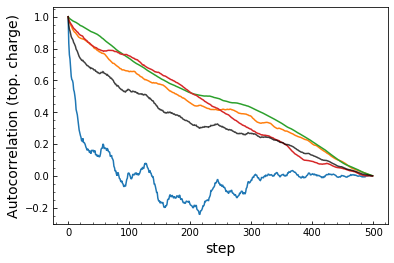

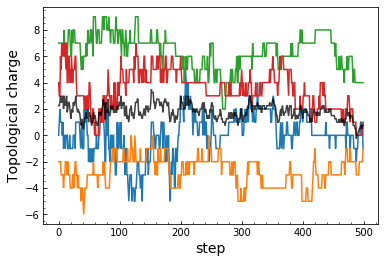

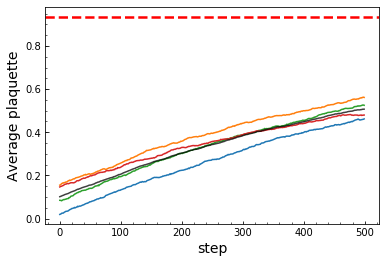

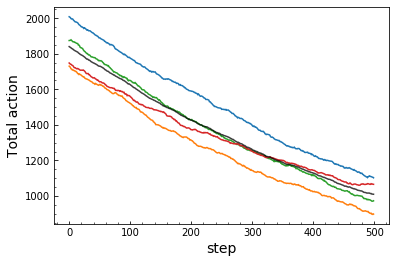

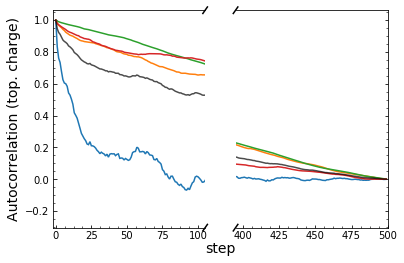

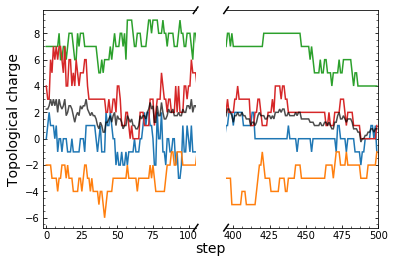

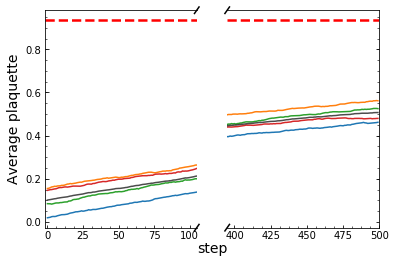

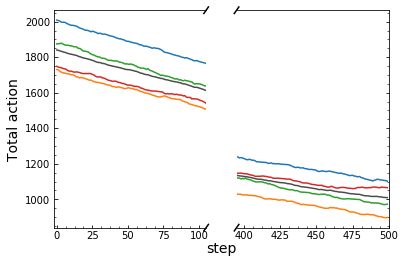

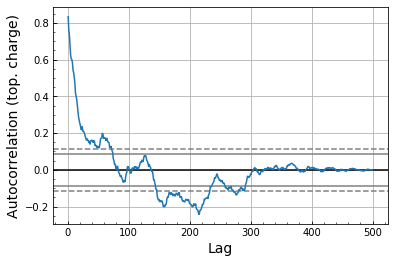

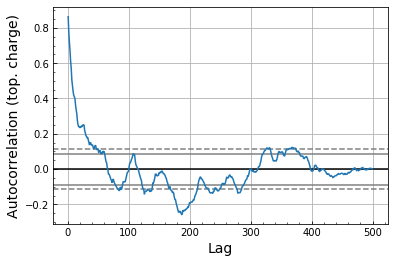

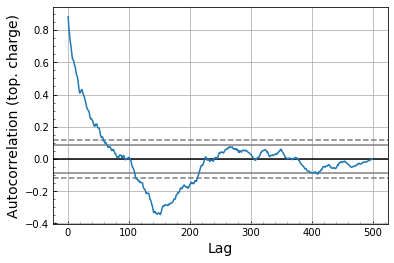

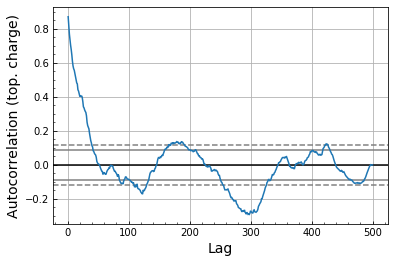

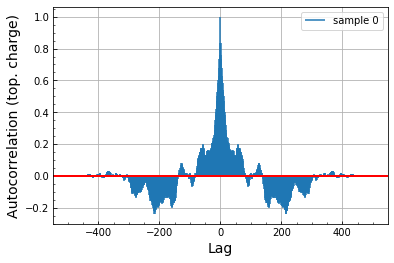

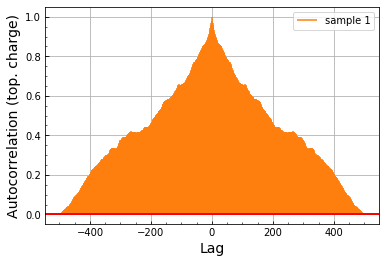

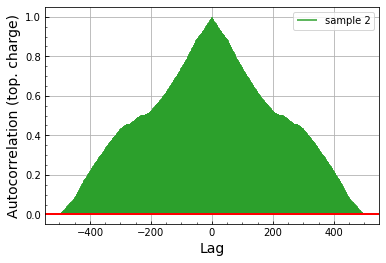

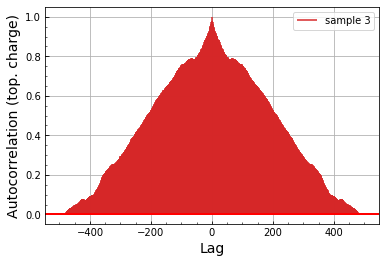

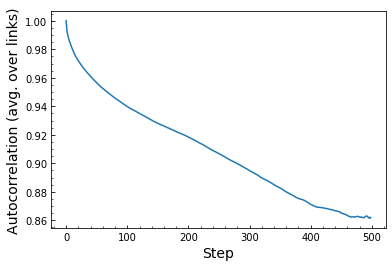

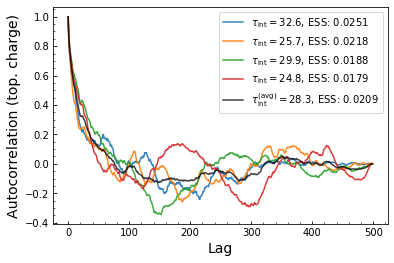

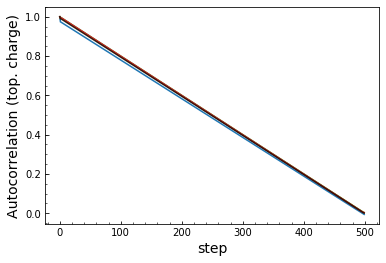

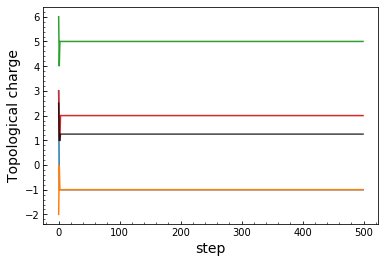

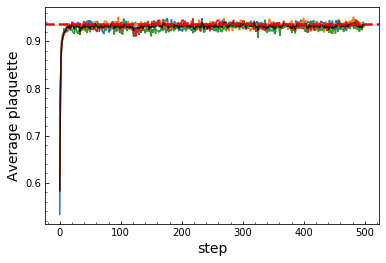

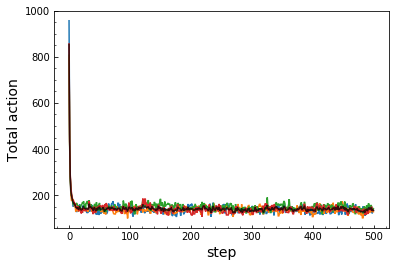

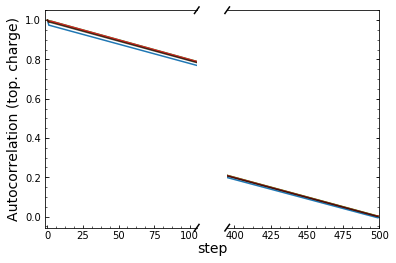

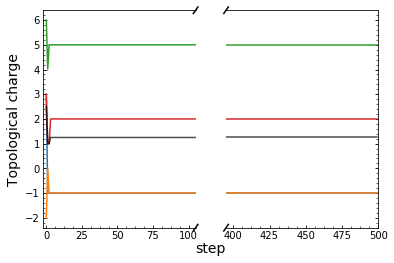

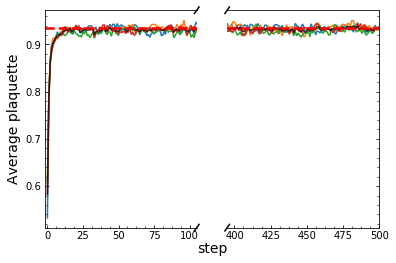

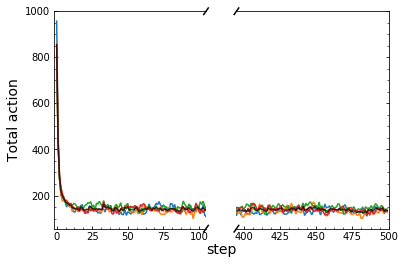

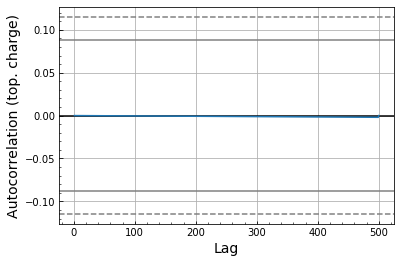

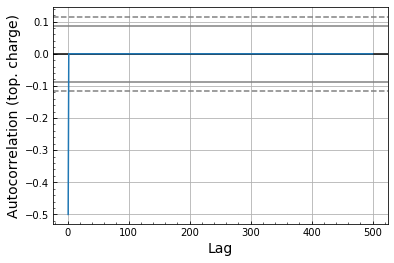

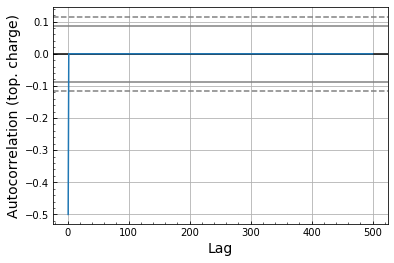

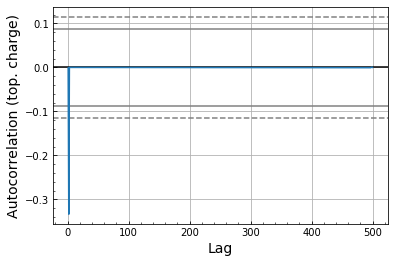

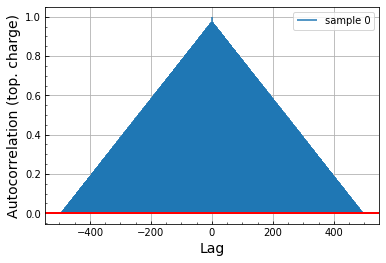

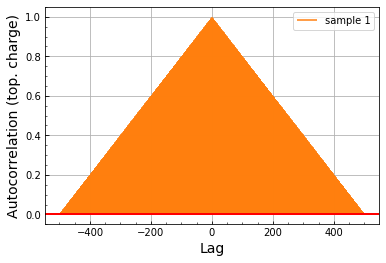

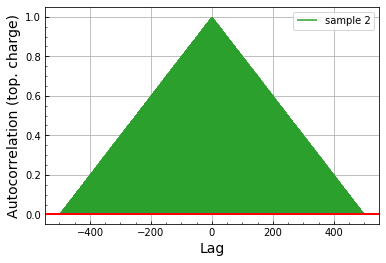

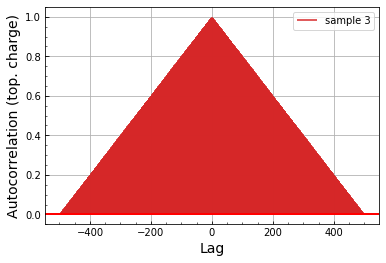

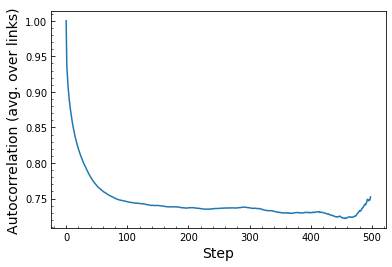

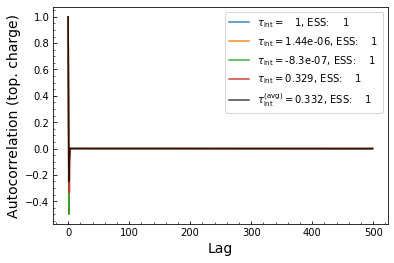

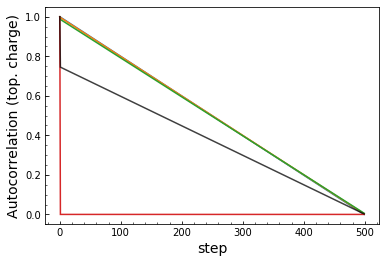

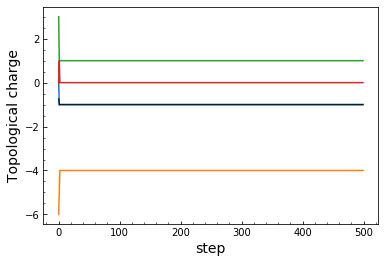

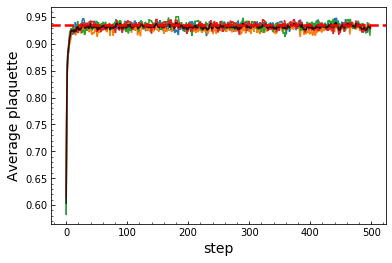

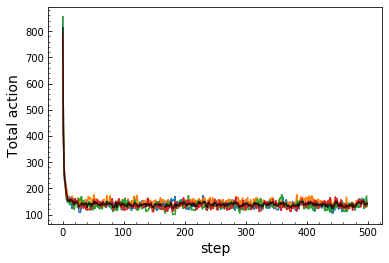

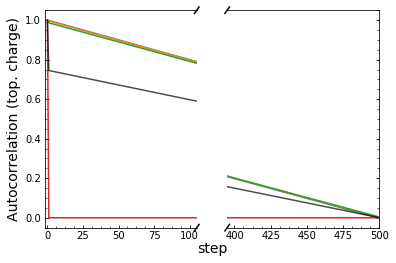

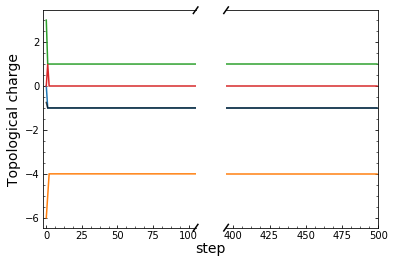

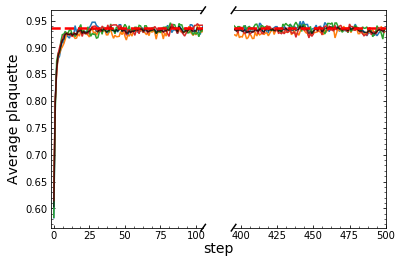

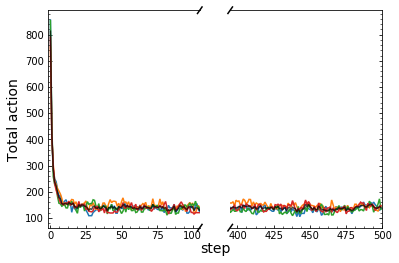

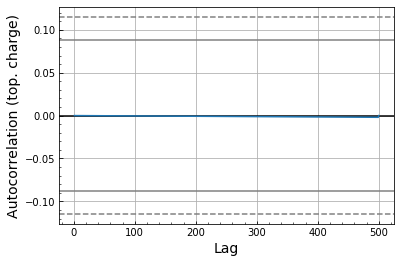

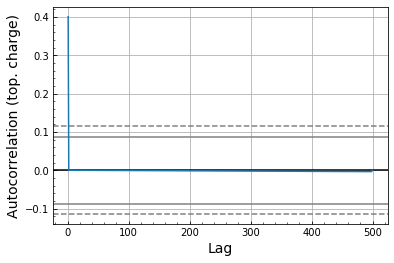

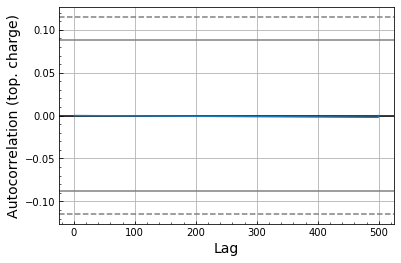

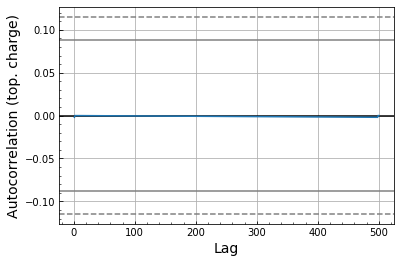

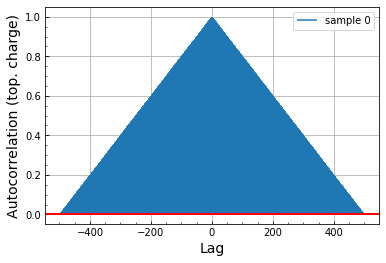

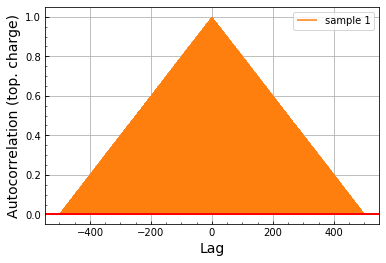

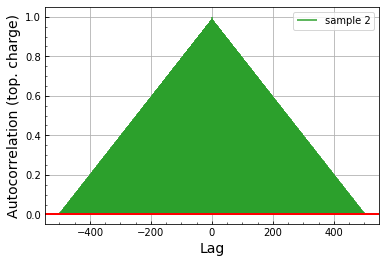

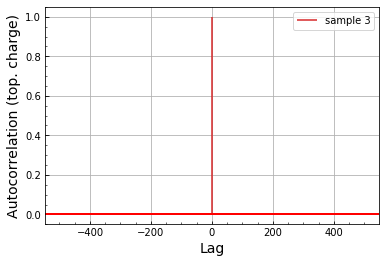

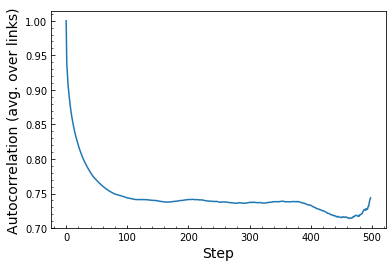

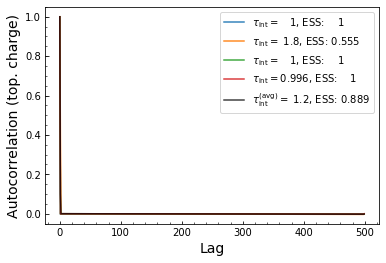

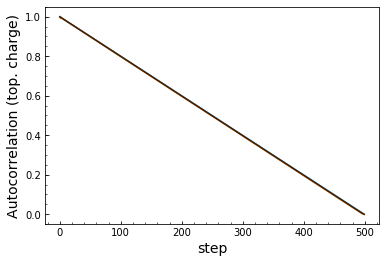

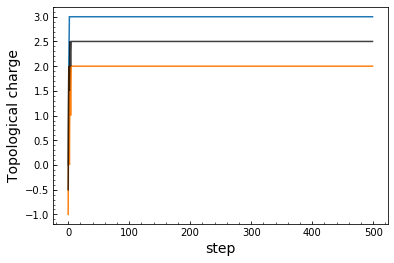

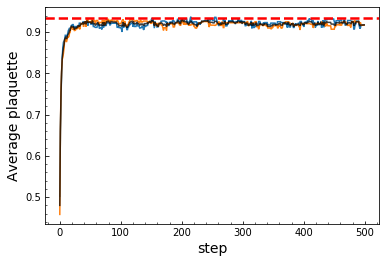

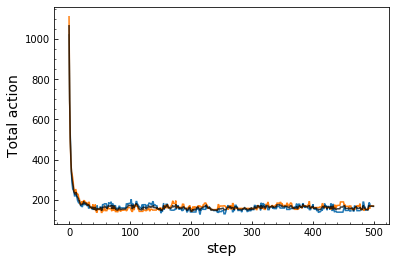

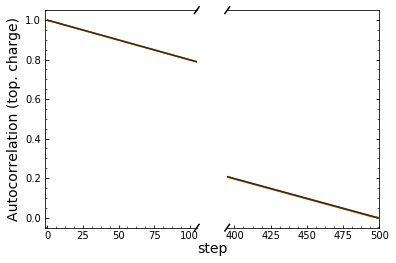

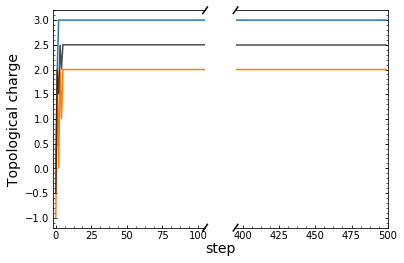

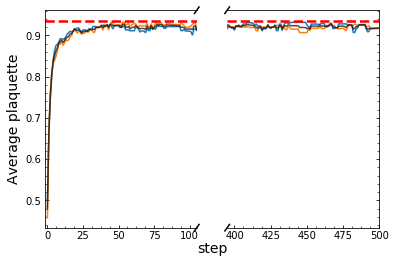

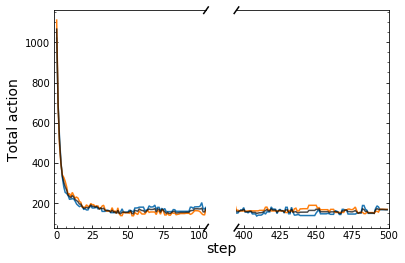

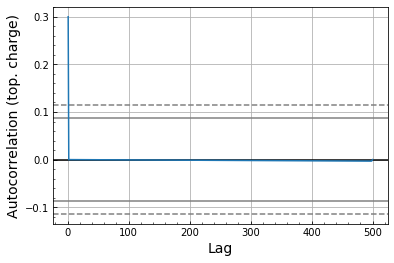

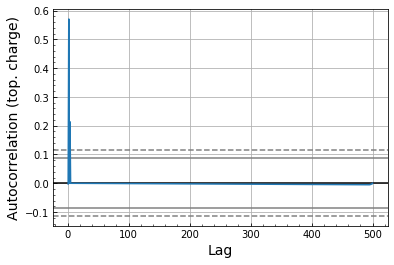

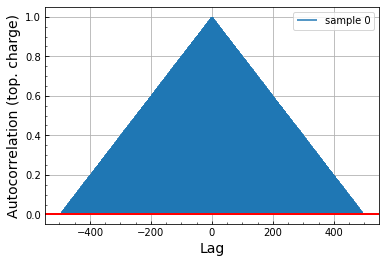

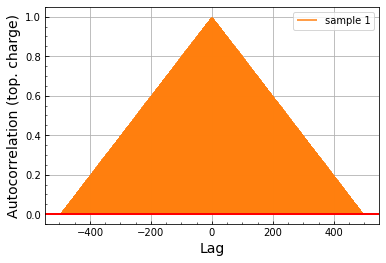

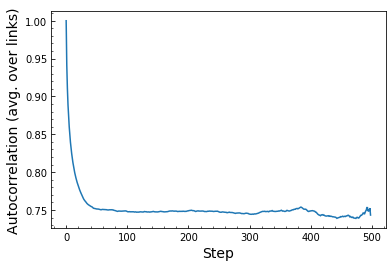

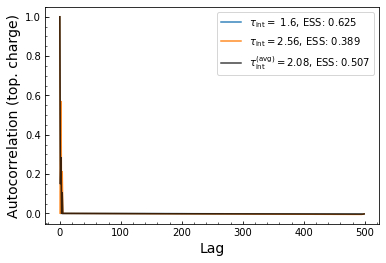

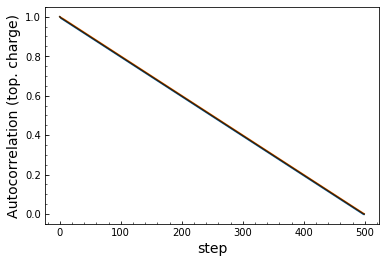

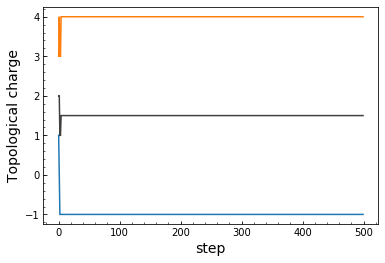

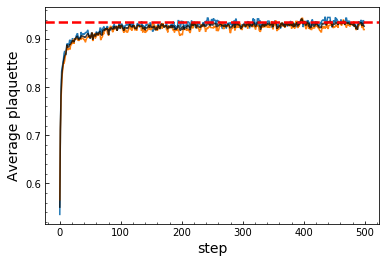

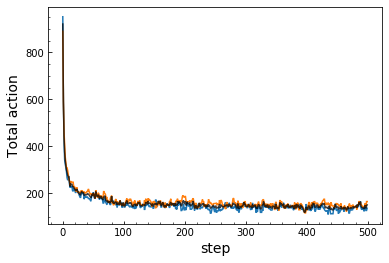

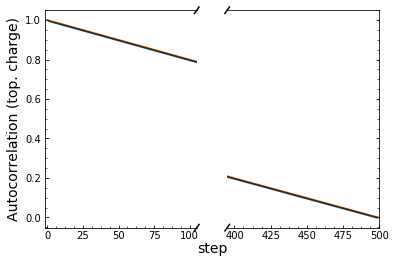

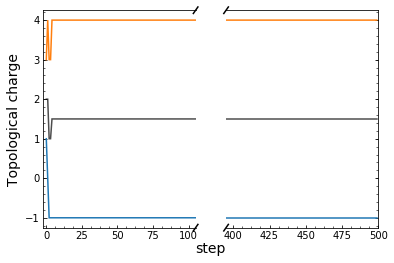

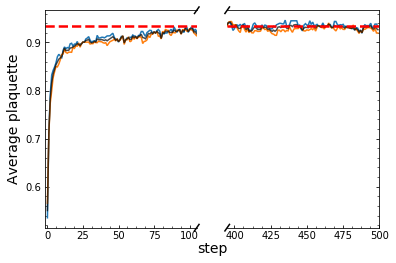

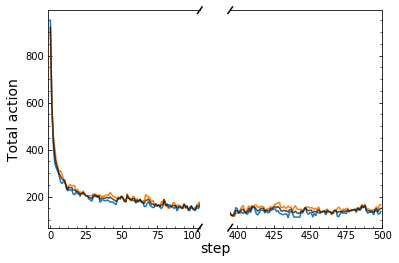

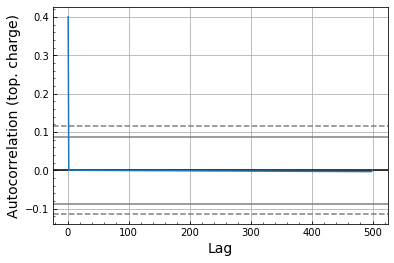

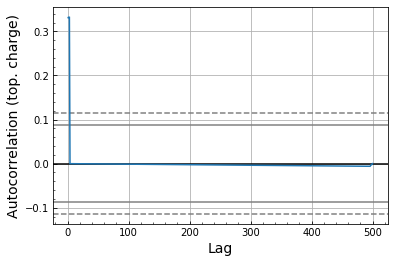

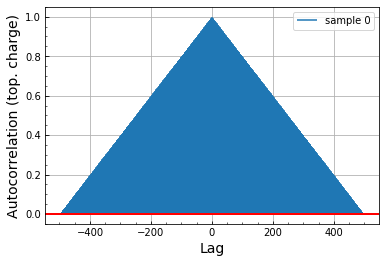

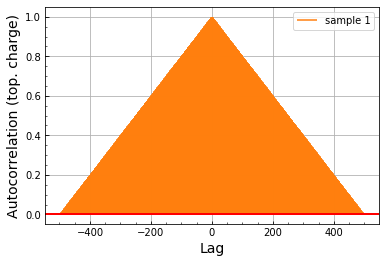

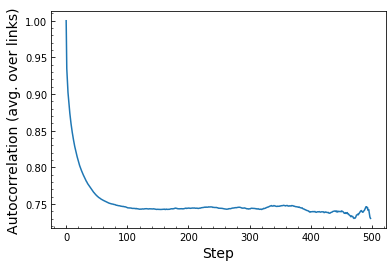

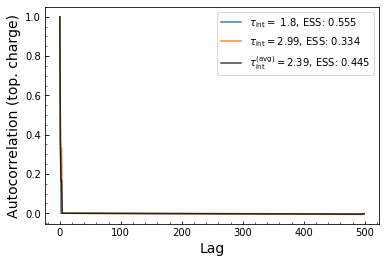

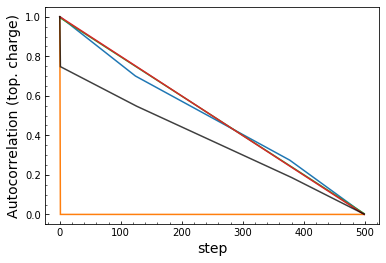

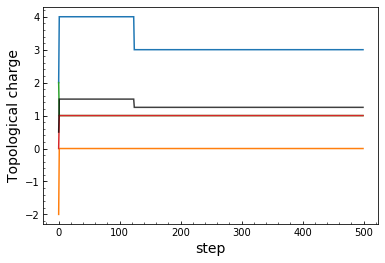

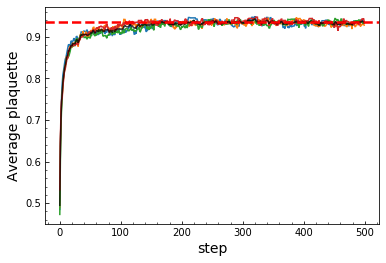

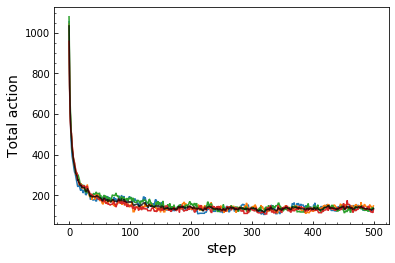

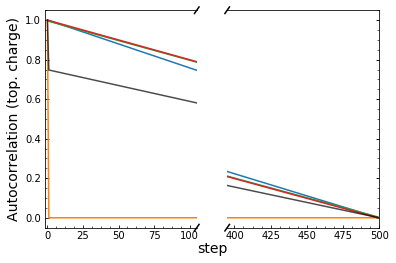

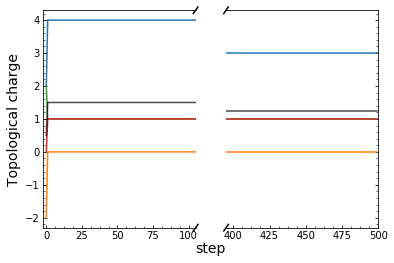

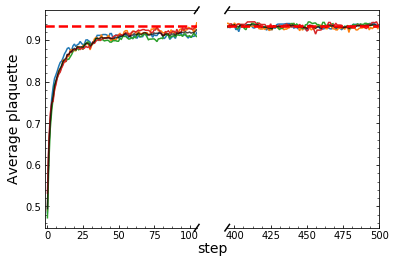

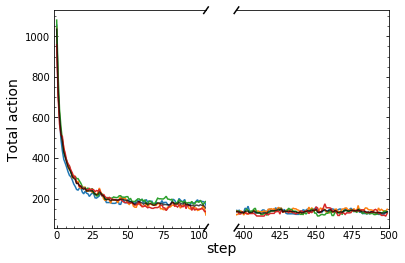

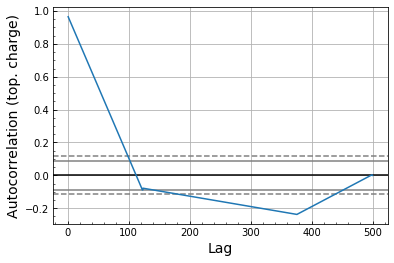

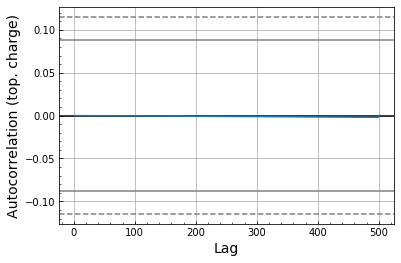

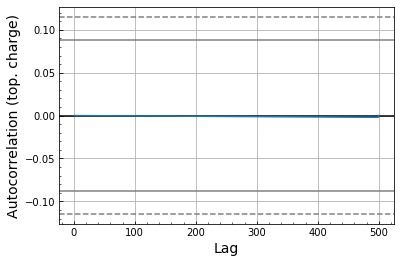

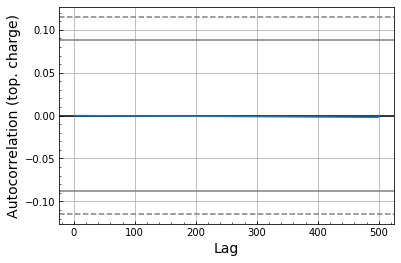

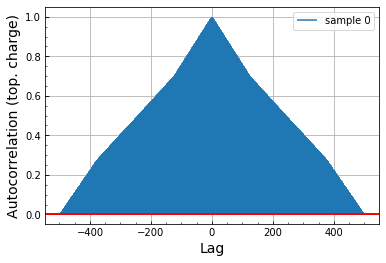

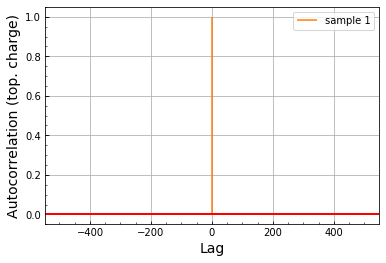

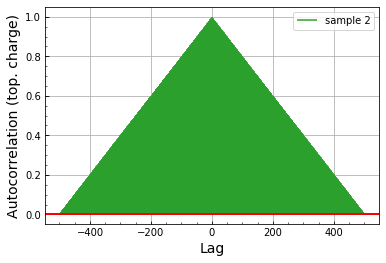

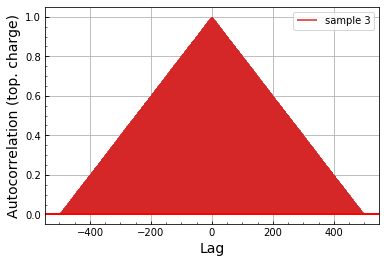

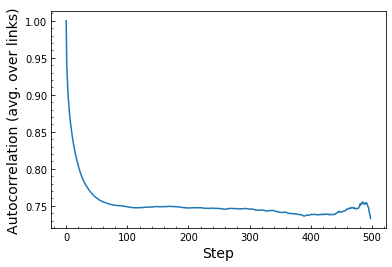

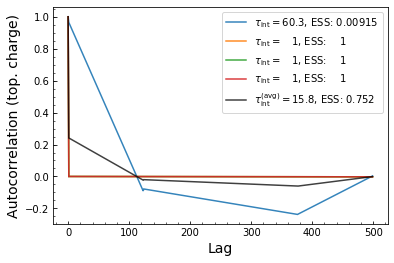

In [8]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

In [6]:
lattice = GaugeLattice(time_size=8, 
                       space_size=8,
                       dim=2, 
                       beta=8., 
                       link_type='U1',
                       num_samples=5,
                       rand=False)

In [7]:
lattice.links.shape

(8, 8, 2)

## Calculate observables and create plots step by step, dir by dir...

In [72]:
log_dir = (
    '../../gauge_logs_graph/run_139/'
)

figs_dir = os.path.join(log_dir, 'figures')
autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
#pandas_autocorr_dir = os.path.join(
#    autocorr_dir, 
#    'pandas_autocorrelation_plots'
#)
#matplotlib_autocorr_dir = os.path.join(
#    autocorr_dir, 
#    'matplotlib_autocorrelation_plots'
#)
check_else_make_dir(autocorr_dir)
#check_else_make_dir(matplotlib_autocorr_dir)
#check_else_make_dir(pandas_autocorr_dir)

Making directory: ../../gauge_logs_graph/run_139/figures/autocorrelation_plots


### Calculate observables

In [73]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

Loading samples history from: ../../gauge_logs_graph/run_139/samples_history/samples_history_500.pkl.
Reading samples from ../../gauge_logs_graph/run_139/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_139/samples_history/samples_history_1000.pkl.
Reading samples from ../../gauge_logs_graph/run_139/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_139/samples_history/samples_history_100.pkl.
Reading samples from ../../gauge_logs_graph/run_139/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_139/samples_history/samples_history_200.pkl.
Reading samples from ../../gauge_logs_graph/run_139/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_139/samples_history/samples_history_5000.pkl.
Reading samples from ../../gauge_logs_graph/run_139/samples_history/samples_history_5000.pkl.
Unable to find ../../

step: 71 time/step: 0.06356 avg action: 69.32  avg plaquette: 0.8646 top charges: 


[0, 0, 0, 0, 0]


step: 72 time/step: 0.0589 avg action: 70.56  avg plaquette: 0.8622 top charges: 


[0, 0, 0, 0, 0]


step: 73 time/step: 0.05664 avg action: 70.38  avg plaquette: 0.8625 top charges: 


[0, 0, 0, 0, -1]


step: 74 time/step: 0.05701 avg action: 66.02  avg plaquette: 0.871  top charges: 


[0, 0, 0, 0, 0]


step: 75 time/step: 0.05802 avg action:  67.9  avg plaquette: 0.8674 top charges: 


[0, 0, 0, 0, 0]


step: 76 time/step: 0.05831 avg action:  67.9  avg plaquette: 0.8674 top charges: 


[0, 0, 0, 0, 0]


step: 77 time/step: 0.05749 avg action: 66.04  avg plaquette: 0.871  top charges: 


[0, 0, 0, 0, 0]


step: 78 time/step: 0.05895 avg action: 71.47  avg plaquette: 0.8604 top charges: 


[0, 0, 0, 0, 0]


step: 79 time/step: 0.05569 avg action: 72.77  avg plaquette: 0.8579 top charges: 


[0, 0, 0, 0, 0]


step: 80 time/step: 0.05983 avg action: 72.78  avg plaquette: 0.8578 top 

step: 151 time/step: 0.06358 avg action: 67.76  avg plaquette: 0.8677 top charges: 


[0, 0, 0, 0, -1]


step: 152 time/step: 0.06196 avg action:  64.9  avg plaquette: 0.8732 top charges: 


[0, 0, 0, 0, -1]


step: 153 time/step: 0.06332 avg action: 62.95  avg plaquette: 0.8771 top charges: 


[0, 0, 0, 0, -1]


step: 154 time/step: 0.06308 avg action: 66.57  avg plaquette:  0.87  top charges: 


[0, 0, 0, 0, -1]


step: 155 time/step: 0.06413 avg action: 66.98  avg plaquette: 0.8692 top charges: 


[0, 0, 0, 0, -1]


step: 156 time/step: 0.06517 avg action: 69.45  avg plaquette: 0.8644 top charges: 


[0, 0, 0, 0, 0]


step: 157 time/step: 0.06549 avg action: 69.17  avg plaquette: 0.8649 top charges: 


[0, 0, 0, 0, 0]


step: 158 time/step: 0.06646 avg action: 67.75  avg plaquette: 0.8677 top charges: 


[0, 0, 0, 0, 0]


step: 159 time/step: 0.07019 avg action: 65.47  avg plaquette: 0.8721 top charges: 


[0, 0, 0, 0, 0]


step: 160 time/step: 0.06475 avg action: 64.06  avg plaquet

step: 231 time/step: 0.06324 avg action: 66.79  avg plaquette: 0.8696 top charges: 


[0, 0, 0, 0, 0]


step: 232 time/step: 0.05963 avg action:  66.3  avg plaquette: 0.8705 top charges: 


[0, 0, 0, 0, 0]


step: 233 time/step: 0.06068 avg action: 63.12  avg plaquette: 0.8767 top charges: 


[0, 0, 0, 0, 0]


step: 234 time/step: 0.05927 avg action: 63.93  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 0]


step: 235 time/step: 0.06099 avg action: 64.72  avg plaquette: 0.8736 top charges: 


[0, 0, 0, 0, 0]


step: 236 time/step: 0.0586 avg action: 66.07  avg plaquette: 0.871  top charges: 


[0, 0, 0, 0, 0]


step: 237 time/step: 0.05761 avg action: 66.15  avg plaquette: 0.8708 top charges: 


[0, 0, 0, 0, 0]


step: 238 time/step: 0.05934 avg action: 66.24  avg plaquette: 0.8706 top charges: 


[0, 0, 0, 0, 0]


step: 239 time/step: 0.06425 avg action: 66.24  avg plaquette: 0.8706 top charges: 


[0, 0, 0, 0, 0]


step: 240 time/step: 0.05947 avg action: 66.24  avg plaquette: 0.

step: 310 time/step: 0.06459 avg action: 74.55  avg plaquette: 0.8544 top charges: 


[0, 0, 0, 0, 0]


step: 311 time/step: 0.07053 avg action: 74.02  avg plaquette: 0.8554 top charges: 


[0, -1, 0, 0, 0]


step: 312 time/step: 0.06404 avg action: 72.76  avg plaquette: 0.8579 top charges: 


[0, -1, 0, 0, 0]


step: 313 time/step: 0.04969 avg action: 72.35  avg plaquette: 0.8587 top charges: 


[0, 0, 0, 0, 0]


step: 314 time/step: 0.05386 avg action: 76.43  avg plaquette: 0.8507 top charges: 


[0, -1, 0, 0, 0]


step: 315 time/step: 0.05799 avg action:  74.4  avg plaquette: 0.8547 top charges: 


[0, -1, 0, 0, 0]


step: 316 time/step: 0.06081 avg action: 76.51  avg plaquette: 0.8506 top charges: 


[0, -1, 0, 0, 0]


step: 317 time/step: 0.05576 avg action: 72.63  avg plaquette: 0.8582 top charges: 


[0, -1, 0, 0, 0]


step: 318 time/step: 0.05175 avg action: 71.83  avg plaquette: 0.8597 top charges: 


[0, -1, 0, 0, 0]


step: 319 time/step: 0.05372 avg action: 71.23  avg plaqu

step: 391 time/step: 0.05212 avg action:  67.5  avg plaquette: 0.8682 top charges: 


[0, 0, 0, 0, 0]


step: 392 time/step: 0.05049 avg action: 68.69  avg plaquette: 0.8658 top charges: 


[0, 0, 0, 0, 0]


step: 393 time/step: 0.04901 avg action: 68.59  avg plaquette: 0.866  top charges: 


[0, 0, 0, 0, 0]


step: 394 time/step: 0.05287 avg action:  69.4  avg plaquette: 0.8644 top charges: 


[0, 0, 0, 0, 0]


step: 395 time/step: 0.0504 avg action:  69.8  avg plaquette: 0.8637 top charges: 


[0, 0, 0, 0, 0]


step: 396 time/step: 0.05013 avg action: 69.38  avg plaquette: 0.8645 top charges: 


[0, 0, 0, 0, 0]


step: 397 time/step: 0.04922 avg action: 70.27  avg plaquette: 0.8627 top charges: 


[0, 0, 0, 0, 0]


step: 398 time/step: 0.05142 avg action: 69.78  avg plaquette: 0.8637 top charges: 


[0, 0, 0, 0, 0]


step: 399 time/step: 0.05062 avg action: 68.68  avg plaquette: 0.8659 top charges: 


[0, 0, 0, 0, 0]


step: 400 time/step: 0.05178 avg action: 69.41  avg plaquette: 0.

step: 472 time/step: 0.05704 avg action: 63.38  avg plaquette: 0.8762 top charges: 


[0, 0, 0, 0, 0]


step: 473 time/step: 0.05475 avg action: 63.69  avg plaquette: 0.8756 top charges: 


[0, 0, 0, 0, 0]


step: 474 time/step: 0.06271 avg action: 65.32  avg plaquette: 0.8724 top charges: 


[0, 0, 0, 0, 0]


step: 475 time/step: 0.05432 avg action:  63.7  avg plaquette: 0.8756 top charges: 


[0, 0, 0, 0, 0]


step: 476 time/step: 0.05783 avg action: 63.42  avg plaquette: 0.8761 top charges: 


[0, 0, 0, 0, 0]


step: 477 time/step: 0.05657 avg action: 63.42  avg plaquette: 0.8761 top charges: 


[0, 0, 0, 0, 0]


step: 478 time/step: 0.06032 avg action:  61.9  avg plaquette: 0.8791 top charges: 


[0, 0, 0, 0, 0]


step: 479 time/step: 0.05443 avg action: 61.66  avg plaquette: 0.8796 top charges: 


[0, 0, 0, 0, 0]


step: 480 time/step: 0.05158 avg action: 61.28  avg plaquette: 0.8803 top charges: 


[0, 0, 0, 0, 0]


step: 481 time/step: 0.0531 avg action: 60.98  avg plaquette: 0.

step: 51 time/step: 0.05281 avg action: 63.37  avg plaquette: 0.8762 top charges: 


[0, 0, 1, 0, 0]


step: 52 time/step: 0.05276 avg action: 67.16  avg plaquette: 0.8688 top charges: 


[0, 0, 0, -1, 0]


step: 53 time/step: 0.05545 avg action:  65.4  avg plaquette: 0.8723 top charges: 


[-1, 0, 0, -1, 0]


step: 54 time/step: 0.05009 avg action: 68.43  avg plaquette: 0.8663 top charges: 


[-1, 0, 0, -1, 1]


step: 55 time/step: 0.05551 avg action: 66.11  avg plaquette: 0.8709 top charges: 


[0, 0, 1, -1, 1]


step: 56 time/step: 0.05447 avg action: 59.89  avg plaquette: 0.883  top charges: 


[0, 0, 1, -1, 1]


step: 57 time/step: 0.05097 avg action: 58.67  avg plaquette: 0.8854 top charges: 


[-1, 0, 0, -1, 1]


step: 58 time/step: 0.04975 avg action: 58.09  avg plaquette: 0.8865 top charges: 


[-1, 0, 0, -1, 1]


step: 59 time/step: 0.04876 avg action: 56.68  avg plaquette: 0.8893 top charges: 


[0, 0, 1, -1, 0]


step: 60 time/step: 0.05112 avg action: 59.73  avg plaquette:

step: 133 time/step: 0.05786 avg action: 63.22  avg plaquette: 0.8765 top charges: 


[0, 0, 1, 0, 1]


step: 134 time/step: 0.05388 avg action: 60.52  avg plaquette: 0.8818 top charges: 


[-1, 0, 1, 0, 0]


step: 135 time/step: 0.05404 avg action: 62.15  avg plaquette: 0.8786 top charges: 


[-1, 0, 1, 0, 0]


step: 136 time/step: 0.05167 avg action: 60.69  avg plaquette: 0.8815 top charges: 


[-1, 0, 1, 0, 0]


step: 137 time/step: 0.05427 avg action: 62.73  avg plaquette: 0.8775 top charges: 


[0, 0, 1, 0, 0]


step: 138 time/step: 0.05487 avg action:  63.4  avg plaquette: 0.8762 top charges: 


[0, 0, 1, 0, 0]


step: 139 time/step: 0.05476 avg action: 57.44  avg plaquette: 0.8878 top charges: 


[0, 0, 1, 0, 0]


step: 140 time/step: 0.04892 avg action:  55.8  avg plaquette: 0.891  top charges: 


[0, 0, 1, 0, 0]


step: 141 time/step: 0.05206 avg action: 55.04  avg plaquette: 0.8925 top charges: 


[0, 0, 1, 0, 0]


step: 142 time/step: 0.05487 avg action: 55.59  avg plaquette

step: 213 time/step: 0.1009 avg action: 61.81  avg plaquette: 0.8793 top charges: 


[-1, 0, 0, -1, 0]


step: 214 time/step: 0.1097 avg action:   63   avg plaquette: 0.877  top charges: 


[-1, 0, 1, 0, 1]


step: 215 time/step: 0.1004 avg action: 63.42  avg plaquette: 0.8761 top charges: 


[-1, 0, 1, -1, 1]


step: 216 time/step: 0.06782 avg action: 63.37  avg plaquette: 0.8762 top charges: 


[0, 0, 1, -1, 1]


step: 217 time/step: 0.06737 avg action: 67.68  avg plaquette: 0.8678 top charges: 


[0, 0, 1, -1, 1]


step: 218 time/step: 0.08085 avg action:  67.9  avg plaquette: 0.8674 top charges: 


[0, 0, 1, -1, 1]


step: 219 time/step: 0.06902 avg action: 66.21  avg plaquette: 0.8707 top charges: 


[0, 0, 1, -1, 1]


step: 220 time/step: 0.0569 avg action: 64.43  avg plaquette: 0.8742 top charges: 


[-1, 0, 1, 0, 0]


step: 221 time/step: 0.05175 avg action: 63.16  avg plaquette: 0.8766 top charges: 


[-1, 0, 0, -1, 0]


step: 222 time/step: 0.05186 avg action: 58.56  avg plaq

step: 294 time/step: 0.05681 avg action: 59.74  avg plaquette: 0.8833 top charges: 


[-1, 0, 0, 0, 1]


step: 295 time/step: 0.05413 avg action: 60.69  avg plaquette: 0.8815 top charges: 


[0, 0, 0, 0, 1]


step: 296 time/step: 0.05119 avg action: 58.47  avg plaquette: 0.8858 top charges: 


[-1, 0, 0, 0, 1]


step: 297 time/step: 0.05443 avg action: 61.41  avg plaquette: 0.8801 top charges: 


[-1, 0, 0, 0, 1]


step: 298 time/step: 0.05081 avg action: 61.44  avg plaquette:  0.88  top charges: 


[-1, 0, 0, 0, 1]


step: 299 time/step: 0.05133 avg action: 62.36  avg plaquette: 0.8782 top charges: 


[-1, 0, 0, 0, 1]


step: 300 time/step: 0.05092 avg action: 59.43  avg plaquette: 0.8839 top charges: 


[-1, 0, 0, 0, 1]


step: 301 time/step: 0.05274 avg action: 63.52  avg plaquette: 0.8759 top charges: 


[-1, 0, 0, 0, 1]


step: 302 time/step: 0.05649 avg action:  65.7  avg plaquette: 0.8717 top charges: 


[-1, 0, 0, 0, 1]


step: 303 time/step: 0.05282 avg action: 64.16  avg plaq

step: 374 time/step: 0.05375 avg action: 62.29  avg plaquette: 0.8783 top charges: 


[-1, 0, 0, 0, 1]


step: 375 time/step: 0.05196 avg action: 64.17  avg plaquette: 0.8747 top charges: 


[0, 0, -1, 0, 1]


step: 376 time/step: 0.05086 avg action: 59.06  avg plaquette: 0.8846 top charges: 


[0, 0, -1, 0, 1]


step: 377 time/step: 0.05182 avg action: 60.39  avg plaquette: 0.8821 top charges: 


[0, 0, -1, 0, 0]


step: 378 time/step: 0.054  avg action: 63.52  avg plaquette: 0.8759 top charges: 


[-1, 0, -1, 0, 0]


step: 379 time/step: 0.04948 avg action: 61.87  avg plaquette: 0.8792 top charges: 


[-1, 0, -1, 0, 0]


step: 380 time/step: 0.05084 avg action: 67.38  avg plaquette: 0.8684 top charges: 


[0, 0, -1, 0, 0]


step: 381 time/step: 0.06136 avg action: 66.75  avg plaquette: 0.8696 top charges: 


[0, 0, -1, 0, 1]


step: 382 time/step: 0.04987 avg action: 67.09  avg plaquette: 0.869  top charges: 


[0, 0, 0, 0, 1]


step: 383 time/step: 0.05078 avg action: 64.95  avg pla

step: 454 time/step: 0.05139 avg action: 65.48  avg plaquette: 0.8721 top charges: 


[0, 0, -1, 0, 1]


step: 455 time/step: 0.0504 avg action: 64.87  avg plaquette: 0.8733 top charges: 


[0, 0, -1, 0, 1]


step: 456 time/step: 0.05211 avg action: 60.44  avg plaquette: 0.882  top charges: 


[-1, 0, -1, 0, 1]


step: 457 time/step: 0.05397 avg action: 61.28  avg plaquette: 0.8803 top charges: 


[0, 0, -1, 0, 1]


step: 458 time/step: 0.05456 avg action: 62.72  avg plaquette: 0.8775 top charges: 


[0, 0, 0, 0, 0]


step: 459 time/step: 0.05058 avg action: 61.01  avg plaquette: 0.8808 top charges: 


[0, 0, 0, 0, 1]


step: 460 time/step: 0.05197 avg action: 61.01  avg plaquette: 0.8808 top charges: 


[0, 0, 0, 0, 1]


step: 461 time/step: 0.05001 avg action:  60.9  avg plaquette: 0.881  top charges: 


[0, 0, 0, 0, 1]


step: 462 time/step: 0.05402 avg action: 60.52  avg plaquette: 0.8818 top charges: 


[0, 0, 0, 0, 0]


step: 463 time/step: 0.06236 avg action: 60.17  avg plaquett

step: 533 time/step: 0.07593 avg action: 60.08  avg plaquette: 0.8827 top charges: 


[0, 0, -1, 0, 0]


step: 534 time/step: 0.07287 avg action: 61.69  avg plaquette: 0.8795 top charges: 


[0, 0, -1, 0, 1]


step: 535 time/step: 0.08801 avg action: 62.67  avg plaquette: 0.8776 top charges: 


[0, 0, -1, 0, 0]


step: 536 time/step: 0.1014 avg action: 63.74  avg plaquette: 0.8755 top charges: 


[0, 0, -1, 0, 0]


step: 537 time/step: 0.106  avg action: 61.63  avg plaquette: 0.8796 top charges: 


[0, 0, -1, 0, 1]


step: 538 time/step: 0.1082 avg action: 62.95  avg plaquette: 0.8771 top charges: 


[0, 0, -1, 0, 0]


step: 539 time/step: 0.1157 avg action: 64.18  avg plaquette: 0.8746 top charges: 


[0, 0, -1, 0, 0]


step: 540 time/step: 0.105  avg action: 64.56  avg plaquette: 0.8739 top charges: 


[0, 0, -1, 0, 0]


step: 541 time/step: 0.1007 avg action: 66.72  avg plaquette: 0.8697 top charges: 


[0, 0, -1, 0, 0]


step: 542 time/step: 0.1038 avg action: 65.34  avg plaquette:

step: 612 time/step: 0.0697 avg action: 68.32  avg plaquette: 0.8666 top charges: 


[0, 0, 0, 0, 0]


step: 613 time/step: 0.06871 avg action: 68.17  avg plaquette: 0.8669 top charges: 


[0, 0, -1, 0, 0]


step: 614 time/step: 0.0687 avg action:  67.8  avg plaquette: 0.8676 top charges: 


[0, 0, -1, 0, 0]


step: 615 time/step: 0.06944 avg action: 67.76  avg plaquette: 0.8677 top charges: 


[0, 0, -1, 0, 0]


step: 616 time/step: 0.06983 avg action: 67.51  avg plaquette: 0.8681 top charges: 


[0, 0, -1, 0, 0]


step: 617 time/step: 0.06982 avg action: 70.91  avg plaquette: 0.8615 top charges: 


[0, 0, -1, 0, 0]


step: 618 time/step: 0.07034 avg action: 67.82  avg plaquette: 0.8675 top charges: 


[0, 0, 0, 0, 0]


step: 619 time/step: 0.07017 avg action: 63.93  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 1]


step: 620 time/step: 0.07115 avg action: 62.43  avg plaquette: 0.8781 top charges: 


[0, 0, 0, 0, 1]


step: 621 time/step: 0.07402 avg action: 62.88  avg plaquette

step: 691 time/step: 0.0785 avg action: 60.22  avg plaquette: 0.8824 top charges: 


[0, 0, -1, 0, 0]


step: 692 time/step: 0.0747 avg action: 58.84  avg plaquette: 0.8851 top charges: 


[0, 0, -1, 0, 0]


step: 693 time/step: 0.07417 avg action:  58.1  avg plaquette: 0.8865 top charges: 


[0, 0, 0, 0, 0]


step: 694 time/step: 0.07592 avg action: 60.39  avg plaquette: 0.882  top charges: 


[0, 0, 0, 0, 0]


step: 695 time/step: 0.07482 avg action: 62.75  avg plaquette: 0.8774 top charges: 


[0, 0, -1, 0, 0]


step: 696 time/step: 0.06823 avg action: 63.68  avg plaquette: 0.8756 top charges: 


[0, 0, -1, 0, 0]


step: 697 time/step: 0.06566 avg action: 62.03  avg plaquette: 0.8788 top charges: 


[0, 0, 0, 0, 0]


step: 698 time/step: 0.07748 avg action: 62.77  avg plaquette: 0.8774 top charges: 


[0, 0, 0, 0, 0]


step: 699 time/step: 0.06614 avg action: 65.59  avg plaquette: 0.8719 top charges: 


[0, 0, 0, 0, 1]


step: 700 time/step: 0.06604 avg action: 69.17  avg plaquette:

step: 770 time/step: 0.07635 avg action: 62.77  avg plaquette: 0.8774 top charges: 


[0, 0, -1, 0, 1]


step: 771 time/step: 0.06736 avg action: 64.15  avg plaquette: 0.8747 top charges: 


[0, 0, 0, 0, 1]


step: 772 time/step: 0.06973 avg action: 63.66  avg plaquette: 0.8757 top charges: 


[0, 0, -1, 0, 1]


step: 773 time/step: 0.07285 avg action: 66.54  avg plaquette:  0.87  top charges: 


[0, 0, -1, 0, 0]


step: 774 time/step: 0.06582 avg action: 64.58  avg plaquette: 0.8739 top charges: 


[0, 0, -1, 0, 1]


step: 775 time/step: 0.06715 avg action: 67.36  avg plaquette: 0.8684 top charges: 


[0, 0, -1, 0, 0]


step: 776 time/step: 0.06668 avg action:  69.5  avg plaquette: 0.8643 top charges: 


[0, 0, -1, 0, 0]


step: 777 time/step: 0.06954 avg action: 62.25  avg plaquette: 0.8784 top charges: 


[0, 0, -1, 0, 1]


step: 778 time/step: 0.06699 avg action: 61.59  avg plaquette: 0.8797 top charges: 


[0, 0, 0, 0, 1]


step: 779 time/step: 0.06616 avg action: 63.19  avg plaqu

step: 852 time/step: 0.06852 avg action:  64.7  avg plaquette: 0.8736 top charges: 


[0, 0, 0, 0, 1]


step: 853 time/step: 0.06693 avg action: 66.63  avg plaquette: 0.8699 top charges: 


[0, 0, 0, 0, 1]


step: 854 time/step: 0.06448 avg action: 66.63  avg plaquette: 0.8699 top charges: 


[0, 0, 0, 0, 1]


step: 855 time/step: 0.06469 avg action: 66.63  avg plaquette: 0.8699 top charges: 


[0, 0, 0, 0, 1]


step: 856 time/step: 0.06904 avg action: 67.99  avg plaquette: 0.8672 top charges: 


[0, 0, 0, 0, 0]


step: 857 time/step: 0.06553 avg action: 70.01  avg plaquette: 0.8633 top charges: 


[0, 0, -1, 0, 0]


step: 858 time/step: 0.06456 avg action: 69.35  avg plaquette: 0.8646 top charges: 


[0, 0, -1, 0, 0]


step: 859 time/step: 0.06714 avg action: 73.84  avg plaquette: 0.8558 top charges: 


[0, 0, 0, 0, 0]


step: 860 time/step: 0.06866 avg action: 74.76  avg plaquette: 0.854  top charges: 


[0, 0, -1, 0, 1]


step: 861 time/step: 0.07415 avg action: 74.71  avg plaquette

step: 931 time/step: 0.07057 avg action: 68.63  avg plaquette: 0.8659 top charges: 


[0, 0, -1, 0, 1]


step: 932 time/step: 0.06653 avg action: 67.08  avg plaquette: 0.869  top charges: 


[0, 0, -1, 0, 1]


step: 933 time/step: 0.06014 avg action: 69.23  avg plaquette: 0.8648 top charges: 


[0, 0, -1, 0, 1]


step: 934 time/step: 0.06212 avg action: 66.41  avg plaquette: 0.8703 top charges: 


[0, 0, 0, 0, 1]


step: 935 time/step: 0.06198 avg action: 65.31  avg plaquette: 0.8724 top charges: 


[0, 0, -1, 0, 0]


step: 936 time/step: 0.06007 avg action:   66   avg plaquette: 0.8711 top charges: 


[0, 0, 0, 0, 0]


step: 937 time/step: 0.06156 avg action: 67.98  avg plaquette: 0.8672 top charges: 


[0, 0, -1, 0, 0]


step: 938 time/step: 0.0651 avg action: 67.95  avg plaquette: 0.8673 top charges: 


[0, 0, -1, 0, 0]


step: 939 time/step: 0.075  avg action: 69.32  avg plaquette: 0.8646 top charges: 


[0, 0, -1, 0, 1]


step: 940 time/step: 0.06413 avg action: 72.32  avg plaquet

step: 10 time/step: 0.08031 avg action: 81.44  avg plaquette: 0.8409 top charges: 


[-1, -2, 0, 0, 0]


step: 11 time/step: 0.08029 avg action: 78.77  avg plaquette: 0.8462 top charges: 


[0, -2, -1, 0, 0]


step: 12 time/step: 0.07618 avg action: 80.35  avg plaquette: 0.8431 top charges: 


[-1, -2, -1, 0, 0]


step: 13 time/step: 0.07624 avg action: 67.15  avg plaquette: 0.8688 top charges: 


[-1, -1, 0, 1, 0]


step: 14 time/step: 0.07433 avg action: 67.31  avg plaquette: 0.8685 top charges: 


[0, -1, -1, 1, 1]


step: 15 time/step: 0.07591 avg action: 63.61  avg plaquette: 0.8758 top charges: 


[0, -1, -1, 0, 0]


step: 16 time/step: 0.0852 avg action: 62.97  avg plaquette: 0.877  top charges: 


[0, -1, 0, 0, 0]


step: 17 time/step: 0.07492 avg action: 64.24  avg plaquette: 0.8745 top charges: 


[0, -1, 0, 1, 0]


step: 18 time/step: 0.07515 avg action: 60.53  avg plaquette: 0.8818 top charges: 


[-1, -2, -1, 0, 1]


step: 19 time/step: 0.07598 avg action: 64.09  avg plaqu

step: 89 time/step: 0.08232 avg action: 54.67  avg plaquette: 0.8932 top charges: 


[-1, 0, 0, 1, 0]


step: 90 time/step: 0.07274 avg action: 53.87  avg plaquette: 0.8948 top charges: 


[-1, 0, -1, 1, 1]


step: 91 time/step: 0.06924 avg action: 58.34  avg plaquette: 0.886  top charges: 


[0, 0, -1, 0, 1]


step: 92 time/step: 0.07073 avg action: 61.45  avg plaquette:  0.88  top charges: 


[0, -1, -1, 0, 1]


step: 93 time/step: 0.07842 avg action: 59.41  avg plaquette: 0.884  top charges: 


[0, 0, -1, 1, 0]


step: 94 time/step: 0.07564 avg action:  57.9  avg plaquette: 0.8869 top charges: 


[0, 0, -1, 1, 0]


step: 95 time/step: 0.07569 avg action:  57.9  avg plaquette: 0.8869 top charges: 


[0, 0, -1, 1, 0]


step: 96 time/step: 0.0839 avg action: 57.76  avg plaquette: 0.8872 top charges: 


[-1, 0, -1, 0, 1]


step: 97 time/step: 0.07549 avg action: 55.96  avg plaquette: 0.8907 top charges: 


[0, 0, -1, 0, 1]


step: 98 time/step: 0.08272 avg action: 59.43  avg plaquette: 

step: 68 time/step: 0.06348 avg action:  58.6  avg plaquette: 0.8856 top charges: 


[1, 1, 0, 0, 0]


step: 69 time/step: 0.05988 avg action:  57.8  avg plaquette: 0.8871 top charges: 


[1, 1, 0, 0, 0]


step: 70 time/step: 0.05125 avg action: 62.06  avg plaquette: 0.8788 top charges: 


[1, 1, 0, 0, 0]


step: 71 time/step: 0.05151 avg action:  64.1  avg plaquette: 0.8748 top charges: 


[1, 1, 0, 0, 0]


step: 72 time/step: 0.05335 avg action: 62.04  avg plaquette: 0.8788 top charges: 


[1, 0, 0, 0, 0]


step: 73 time/step: 0.0591 avg action: 60.33  avg plaquette: 0.8822 top charges: 


[1, 1, 0, 0, 0]


step: 74 time/step: 0.06124 avg action: 57.84  avg plaquette: 0.887  top charges: 


[1, 1, 0, 0, 0]


step: 75 time/step: 0.06042 avg action: 58.42  avg plaquette: 0.8859 top charges: 


[2, 1, 0, 0, 0]


step: 76 time/step: 0.0631 avg action: 60.66  avg plaquette: 0.8815 top charges: 


[2, 1, 0, 0, 0]


step: 77 time/step: 0.06975 avg action: 64.07  avg plaquette: 0.8749 top ch

step: 149 time/step: 0.1907 avg action: 66.04  avg plaquette: 0.871  top charges: 


[1, 0, 0, 0, 0]


step: 150 time/step: 0.1498 avg action: 65.91  avg plaquette: 0.8713 top charges: 


[2, 1, 0, 0, 0]


step: 151 time/step: 0.143  avg action: 66.72  avg plaquette: 0.8697 top charges: 


[2, 1, 0, 0, 0]


step: 152 time/step: 0.124  avg action: 68.79  avg plaquette: 0.8656 top charges: 


[1, 1, 0, 0, 0]


step: 153 time/step: 0.1216 avg action: 65.99  avg plaquette: 0.8711 top charges: 


[2, 1, 0, 0, 0]


step: 154 time/step: 0.1061 avg action: 64.41  avg plaquette: 0.8742 top charges: 


[2, 1, 0, 0, 0]


step: 155 time/step: 0.07709 avg action: 64.41  avg plaquette: 0.8742 top charges: 


[2, 1, 0, 0, 0]


step: 156 time/step: 0.0856 avg action: 66.31  avg plaquette: 0.8705 top charges: 


[2, 1, 0, 0, 0]


step: 157 time/step: 0.09548 avg action: 68.84  avg plaquette: 0.8655 top charges: 


[2, 1, 0, 0, 0]


step: 158 time/step: 0.09751 avg action: 67.27  avg plaquette: 0.8686 t

step: 28 time/step: 0.06561 avg action: 68.24  avg plaquette: 0.8667 top charges: 


[1, 0, 0, -1, 1]


step: 29 time/step: 0.06373 avg action: 68.02  avg plaquette: 0.8672 top charges: 


[1, 0, 0, -1, 0]


step: 30 time/step: 0.06788 avg action: 67.14  avg plaquette: 0.8689 top charges: 


[1, 0, 0, 0, 0]


step: 31 time/step: 0.0631 avg action: 69.07  avg plaquette: 0.8651 top charges: 


[1, 0, 0, -1, 0]


step: 32 time/step: 0.0637 avg action: 68.37  avg plaquette: 0.8665 top charges: 


[0, 0, 0, 0, 0]


step: 33 time/step: 0.05611 avg action: 69.58  avg plaquette: 0.8641 top charges: 


[0, 0, 0, 0, 0]


step: 34 time/step: 0.05702 avg action: 68.93  avg plaquette: 0.8654 top charges: 


[0, 0, 0, -1, 0]


step: 35 time/step: 0.06368 avg action: 68.37  avg plaquette: 0.8665 top charges: 


[0, 0, 0, -1, 1]


step: 36 time/step: 0.06311 avg action: 70.34  avg plaquette: 0.8626 top charges: 


[0, 0, 0, -1, 1]


step: 37 time/step: 0.06413 avg action: 69.27  avg plaquette: 0.8647 

step: 111 time/step: 0.0695 avg action: 63.34  avg plaquette: 0.8763 top charges: 


[1, 0, 0, 0, 0]


step: 112 time/step: 0.06619 avg action: 63.84  avg plaquette: 0.8753 top charges: 


[0, 0, 0, 0, 0]


step: 113 time/step: 0.06687 avg action: 67.18  avg plaquette: 0.8688 top charges: 


[1, 0, 0, 0, 1]


step: 114 time/step: 0.06707 avg action:  65.9  avg plaquette: 0.8713 top charges: 


[1, 0, 0, 0, 1]


step: 115 time/step: 0.07152 avg action: 64.86  avg plaquette: 0.8733 top charges: 


[1, 0, 0, 0, 0]


step: 116 time/step: 0.05752 avg action: 64.59  avg plaquette: 0.8739 top charges: 


[1, 0, 0, -1, 0]


step: 117 time/step: 0.05661 avg action:  62.5  avg plaquette: 0.8779 top charges: 


[1, 0, 0, -1, 0]


step: 118 time/step: 0.05525 avg action:  61.1  avg plaquette: 0.8807 top charges: 


[1, 0, 0, -1, 0]


step: 119 time/step: 0.06463 avg action: 62.23  avg plaquette: 0.8785 top charges: 


[0, 0, 0, -1, 0]


step: 120 time/step: 0.0611 avg action: 64.26  avg plaquette:

step: 190 time/step: 0.06832 avg action: 67.38  avg plaquette: 0.8684 top charges: 


[0, 0, 0, -1, 0]


step: 191 time/step: 0.06455 avg action: 68.37  avg plaquette: 0.8665 top charges: 


[0, 0, 0, 0, 0]


step: 192 time/step: 0.06462 avg action: 67.12  avg plaquette: 0.8689 top charges: 


[0, 0, 0, 0, 0]


step: 193 time/step: 0.06453 avg action: 66.04  avg plaquette: 0.871  top charges: 


[0, 0, 0, 0, 0]


step: 194 time/step: 0.07984 avg action:  65.3  avg plaquette: 0.8725 top charges: 


[0, 0, 0, 0, 0]


step: 195 time/step: 0.06659 avg action: 65.41  avg plaquette: 0.8723 top charges: 


[0, 0, 0, 0, 0]


step: 196 time/step: 0.06394 avg action: 63.35  avg plaquette: 0.8763 top charges: 


[1, 0, 0, -1, 0]


step: 197 time/step: 0.06367 avg action:  65.8  avg plaquette: 0.8715 top charges: 


[1, 0, 0, -1, 0]


step: 198 time/step: 0.06841 avg action: 67.47  avg plaquette: 0.8682 top charges: 


[0, 0, 0, -1, 0]


step: 199 time/step: 0.06571 avg action: 66.53  avg plaquett

step: 269 time/step: 0.07873 avg action: 62.46  avg plaquette: 0.878  top charges: 


[0, 0, 0, -1, 0]


step: 270 time/step: 0.08692 avg action: 60.41  avg plaquette: 0.882  top charges: 


[1, 0, 0, -1, 0]


step: 271 time/step: 0.08462 avg action: 59.34  avg plaquette: 0.8841 top charges: 


[1, 0, 0, -1, 1]


step: 272 time/step: 0.07666 avg action: 60.92  avg plaquette: 0.881  top charges: 


[0, 0, 0, 0, 1]


step: 273 time/step: 0.07587 avg action: 62.25  avg plaquette: 0.8784 top charges: 


[0, 0, 0, 0, 0]


step: 274 time/step: 0.08017 avg action: 63.96  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 0]


step: 275 time/step: 0.08343 avg action: 65.07  avg plaquette: 0.8729 top charges: 


[0, 0, 0, 0, 0]


step: 276 time/step: 0.08844 avg action: 64.94  avg plaquette: 0.8732 top charges: 


[0, 0, 0, 0, 1]


step: 277 time/step: 0.07341 avg action: 63.68  avg plaquette: 0.8756 top charges: 


[0, 0, 0, 0, 1]


step: 278 time/step: 0.07603 avg action: 65.91  avg plaquette

step: 348 time/step: 0.1023 avg action: 66.88  avg plaquette: 0.8694 top charges: 


[0, 0, 0, 0, 0]


step: 349 time/step: 0.09554 avg action: 64.69  avg plaquette: 0.8737 top charges: 


[0, 0, 0, 0, 0]


step: 350 time/step: 0.0852 avg action: 64.38  avg plaquette: 0.8743 top charges: 


[1, 0, 0, 0, 1]


step: 351 time/step: 0.09666 avg action: 61.87  avg plaquette: 0.8792 top charges: 


[1, 0, 0, 0, 1]


step: 352 time/step: 0.1064 avg action: 60.61  avg plaquette: 0.8816 top charges: 


[0, 0, 0, -1, 0]


step: 353 time/step: 0.1056 avg action: 61.73  avg plaquette: 0.8794 top charges: 


[1, 0, 0, 0, 0]


step: 354 time/step: 0.1168 avg action: 61.75  avg plaquette: 0.8794 top charges: 


[1, 0, 0, 0, 0]


step: 355 time/step: 0.09232 avg action: 61.54  avg plaquette: 0.8798 top charges: 


[1, 0, 0, 0, 1]


step: 356 time/step: 0.07603 avg action: 57.29  avg plaquette: 0.8881 top charges: 


[1, 0, 0, 0, 0]


step: 357 time/step: 0.06948 avg action: 57.84  avg plaquette: 0.887

step: 427 time/step: 0.06967 avg action: 67.68  avg plaquette: 0.8678 top charges: 


[1, 0, 0, -1, 0]


step: 428 time/step: 0.06931 avg action: 67.21  avg plaquette: 0.8687 top charges: 


[1, 0, 0, -1, 0]


step: 429 time/step: 0.06923 avg action: 68.31  avg plaquette: 0.8666 top charges: 


[1, 0, 0, -1, 1]


step: 430 time/step: 0.08615 avg action:  69.8  avg plaquette: 0.8637 top charges: 


[1, 0, 0, -1, 1]


step: 431 time/step: 0.07212 avg action: 67.04  avg plaquette: 0.8691 top charges: 


[1, 0, 0, 0, 0]


step: 432 time/step: 0.06792 avg action: 66.96  avg plaquette: 0.8692 top charges: 


[0, 0, 0, -1, 0]


step: 433 time/step: 0.07021 avg action:  67.9  avg plaquette: 0.8674 top charges: 


[0, 0, 0, -1, 0]


step: 434 time/step: 0.06503 avg action: 68.34  avg plaquette: 0.8665 top charges: 


[0, 0, 0, -1, 0]


step: 435 time/step: 0.06562 avg action:   68   avg plaquette: 0.8672 top charges: 


[1, 0, 0, 0, 0]


step: 436 time/step: 0.06873 avg action: 67.27  avg plaqu

step: 506 time/step: 0.06474 avg action: 69.86  avg plaquette: 0.8636 top charges: 


[0, 0, 0, 0, 0]


step: 507 time/step: 0.07172 avg action: 67.06  avg plaquette: 0.869  top charges: 


[1, 0, 0, 0, 0]


step: 508 time/step: 0.06953 avg action: 67.48  avg plaquette: 0.8682 top charges: 


[1, 0, 0, 0, 0]


step: 509 time/step: 0.06827 avg action: 65.13  avg plaquette: 0.8728 top charges: 


[0, 0, 0, 0, 0]


step: 510 time/step: 0.08029 avg action: 65.19  avg plaquette: 0.8727 top charges: 


[0, 0, 0, -1, 0]


step: 511 time/step: 0.06755 avg action: 66.57  avg plaquette:  0.87  top charges: 


[1, 0, 0, -1, 0]


step: 512 time/step: 0.06656 avg action: 68.19  avg plaquette: 0.8668 top charges: 


[1, 0, 0, -1, 0]


step: 513 time/step: 0.06567 avg action: 68.37  avg plaquette: 0.8665 top charges: 


[0, 0, 0, -1, 0]


step: 514 time/step: 0.06429 avg action: 67.35  avg plaquette: 0.8685 top charges: 


[0, 0, 0, -1, 0]


step: 515 time/step: 0.06384 avg action: 67.06  avg plaquet

step: 585 time/step: 0.07437 avg action: 62.64  avg plaquette: 0.8777 top charges: 


[1, 0, -1, 0, 0]


step: 586 time/step: 0.0753 avg action: 65.94  avg plaquette: 0.8712 top charges: 


[1, 0, 0, 0, 0]


step: 587 time/step: 0.07711 avg action: 68.62  avg plaquette: 0.866  top charges: 


[1, 0, 0, 0, 0]


step: 588 time/step: 0.08171 avg action: 64.96  avg plaquette: 0.8731 top charges: 


[0, 0, -1, 0, 0]


step: 589 time/step: 0.07681 avg action: 68.21  avg plaquette: 0.8668 top charges: 


[1, 0, -1, -1, 0]


step: 590 time/step: 0.0839 avg action: 65.58  avg plaquette: 0.8719 top charges: 


[1, 0, -1, 0, 0]


step: 591 time/step: 0.0792 avg action: 65.75  avg plaquette: 0.8716 top charges: 


[1, 0, 0, 0, 0]


step: 592 time/step: 0.07574 avg action: 63.95  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 0]


step: 593 time/step: 0.08174 avg action: 62.54  avg plaquette: 0.8778 top charges: 


[0, 0, 0, -1, 0]


step: 594 time/step: 0.09617 avg action: 63.12  avg plaquette

step: 666 time/step: 0.07076 avg action: 57.67  avg plaquette: 0.8874 top charges: 


[0, 0, -1, -1, 0]


step: 667 time/step: 0.08385 avg action: 59.07  avg plaquette: 0.8846 top charges: 


[0, 0, 0, -1, 0]


step: 668 time/step: 0.09129 avg action: 60.13  avg plaquette: 0.8825 top charges: 


[0, 0, 0, -1, 0]


step: 669 time/step: 0.08594 avg action: 60.96  avg plaquette: 0.8809 top charges: 


[0, 0, 0, -1, 0]


step: 670 time/step: 0.0893 avg action: 64.15  avg plaquette: 0.8747 top charges: 


[0, 0, 0, -1, 1]


step: 671 time/step: 0.07764 avg action: 63.96  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 1]


step: 672 time/step: 0.08235 avg action: 63.96  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 1]


step: 673 time/step: 0.1136 avg action: 64.01  avg plaquette: 0.875  top charges: 


[0, 0, -1, 0, 0]


step: 674 time/step: 0.1312 avg action: 66.99  avg plaquette: 0.8692 top charges: 


[0, 0, -1, 0, 1]


step: 675 time/step: 0.1367 avg action: 62.53  avg plaquett

step: 746 time/step: 0.07453 avg action: 65.81  avg plaquette: 0.8715 top charges: 


[1, 0, -1, 0, 0]


step: 747 time/step: 0.07625 avg action: 63.83  avg plaquette: 0.8753 top charges: 


[0, 0, -1, 0, 0]


step: 748 time/step: 0.0752 avg action: 64.47  avg plaquette: 0.8741 top charges: 


[0, 0, -1, 0, 0]


step: 749 time/step: 0.08082 avg action: 65.64  avg plaquette: 0.8718 top charges: 


[0, 0, -1, -1, 1]


step: 750 time/step: 0.08023 avg action: 66.91  avg plaquette: 0.8693 top charges: 


[0, 0, -1, -1, 1]


step: 751 time/step: 0.07523 avg action: 68.15  avg plaquette: 0.8669 top charges: 


[1, 0, -1, -1, 0]


step: 752 time/step: 0.08292 avg action: 67.92  avg plaquette: 0.8673 top charges: 


[1, 0, -1, -1, 0]


step: 753 time/step: 0.09417 avg action: 65.57  avg plaquette: 0.8719 top charges: 


[1, 0, -1, -1, 0]


step: 754 time/step: 0.0819 avg action:  62.7  avg plaquette: 0.8775 top charges: 


[1, 0, -1, 0, 0]


step: 755 time/step: 0.08214 avg action: 63.29  avg 

step: 828 time/step: 0.0539 avg action: 72.42  avg plaquette: 0.8586 top charges: 


[1, 0, -1, 0, 0]


step: 829 time/step: 0.05248 avg action: 70.38  avg plaquette: 0.8625 top charges: 


[1, 0, -1, 0, 0]


step: 830 time/step: 0.05245 avg action:  71.2  avg plaquette: 0.8609 top charges: 


[0, 0, -1, 0, 0]


step: 831 time/step: 0.05648 avg action: 66.06  avg plaquette: 0.871  top charges: 


[0, 0, -1, -1, 0]


step: 832 time/step: 0.0577 avg action: 67.96  avg plaquette: 0.8673 top charges: 


[0, 0, -1, -1, 1]


step: 833 time/step: 0.05584 avg action: 67.87  avg plaquette: 0.8674 top charges: 


[0, 0, -1, -1, 1]


step: 834 time/step: 0.0535 avg action: 65.69  avg plaquette: 0.8717 top charges: 


[1, 0, 0, -1, 1]


step: 835 time/step: 0.05189 avg action:  63.1  avg plaquette: 0.8768 top charges: 


[1, 0, 0, 0, 1]


step: 836 time/step: 0.05285 avg action: 63.02  avg plaquette: 0.8769 top charges: 


[1, 0, 0, 0, 0]


step: 837 time/step: 0.05199 avg action: 60.69  avg plaqu

step: 907 time/step: 0.09169 avg action: 58.31  avg plaquette: 0.8861 top charges: 


[0, 0, -1, -1, 1]


step: 908 time/step: 0.07054 avg action: 58.31  avg plaquette: 0.8861 top charges: 


[0, 0, -1, -1, 1]


step: 909 time/step: 0.0879 avg action: 56.83  avg plaquette: 0.889  top charges: 


[0, 0, -1, 0, 1]


step: 910 time/step: 0.09833 avg action: 57.98  avg plaquette: 0.8868 top charges: 


[0, 0, -1, -1, 0]


step: 911 time/step: 0.08262 avg action: 59.91  avg plaquette: 0.883  top charges: 


[0, 0, -1, -1, 0]


step: 912 time/step: 0.08399 avg action: 59.16  avg plaquette: 0.8845 top charges: 


[0, 0, -1, -1, 0]


step: 913 time/step: 0.1116 avg action: 59.05  avg plaquette: 0.8847 top charges: 


[0, 0, -1, -1, 0]


step: 914 time/step: 0.1465 avg action: 59.15  avg plaquette: 0.8845 top charges: 


[0, 0, -1, 0, 0]


step: 915 time/step: 0.1155 avg action: 58.15  avg plaquette: 0.8864 top charges: 


[0, 0, -1, -1, 1]


step: 916 time/step: 0.1094 avg action:  59.1  avg p

step: 987 time/step: 0.06822 avg action: 69.81  avg plaquette: 0.8636 top charges: 


[1, 0, -1, -1, 0]


step: 988 time/step: 0.06917 avg action: 67.83  avg plaquette: 0.8675 top charges: 


[1, 0, -1, -1, 1]


step: 989 time/step: 0.06721 avg action: 66.85  avg plaquette: 0.8694 top charges: 


[1, 0, -1, -1, 1]


step: 990 time/step: 0.06587 avg action: 65.68  avg plaquette: 0.8717 top charges: 


[1, 0, 0, -1, 1]


step: 991 time/step: 0.06741 avg action: 67.54  avg plaquette: 0.8681 top charges: 


[1, 0, 0, -1, 1]


step: 992 time/step: 0.0745 avg action: 68.87  avg plaquette: 0.8655 top charges: 


[1, 0, 0, -1, 1]


step: 993 time/step: 0.0697 avg action: 71.26  avg plaquette: 0.8608 top charges: 


[0, 0, -1, -1, 1]


step: 994 time/step: 0.06635 avg action: 69.88  avg plaquette: 0.8635 top charges: 


[1, 0, -1, -1, 1]


step: 995 time/step: 0.06993 avg action: 67.28  avg plaquette: 0.8686 top charges: 


[1, 0, -1, -1, 1]


step: 996 time/step: 0.06675 avg action: 66.07  avg

step: 1067 time/step: 0.0795 avg action:  69.4  avg plaquette: 0.8645 top charges: 


[1, 0, 0, 0, 0]


step: 1068 time/step: 0.1406 avg action: 70.16  avg plaquette: 0.863  top charges: 


[1, 0, 0, -1, 0]


step: 1069 time/step: 0.113  avg action: 71.19  avg plaquette: 0.861  top charges: 


[1, 0, 0, 0, 0]


step: 1070 time/step: 0.1319 avg action: 67.57  avg plaquette: 0.868  top charges: 


[1, 0, -1, -1, 0]


step: 1071 time/step: 0.126  avg action: 73.85  avg plaquette: 0.8558 top charges: 


[1, 0, 0, 0, 0]


step: 1072 time/step: 0.1633 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[0, 0, 0, -1, 0]


step: 1073 time/step: 0.08101 avg action: 71.11  avg plaquette: 0.8611 top charges: 


[1, 0, 0, 0, 0]


step: 1074 time/step: 0.08879 avg action: 66.42  avg plaquette: 0.8703 top charges: 


[1, 0, -1, 0, 0]


step: 1075 time/step: 0.08381 avg action: 66.61  avg plaquette: 0.8699 top charges: 


[1, 0, -1, 0, 1]


step: 1076 time/step: 0.1032 avg action: 67.53  avg pla

step: 1146 time/step: 0.1359 avg action: 69.88  avg plaquette: 0.8635 top charges: 


[0, 0, 0, -1, 1]


step: 1147 time/step: 0.1278 avg action: 69.98  avg plaquette: 0.8633 top charges: 


[0, 0, 0, -1, 1]


step: 1148 time/step: 0.1163 avg action: 71.98  avg plaquette: 0.8594 top charges: 


[0, 0, 0, -1, 1]


step: 1149 time/step: 0.117  avg action:  71.9  avg plaquette: 0.8596 top charges: 


[0, 0, 0, 0, 1]


step: 1150 time/step: 0.1323 avg action: 73.72  avg plaquette: 0.856  top charges: 


[1, 0, 0, -1, 1]


step: 1151 time/step: 0.1118 avg action: 72.52  avg plaquette: 0.8584 top charges: 


[1, 0, 0, 0, 1]


step: 1152 time/step: 0.1142 avg action: 73.66  avg plaquette: 0.8561 top charges: 


[1, 0, 0, 0, 1]


step: 1153 time/step: 0.1191 avg action: 73.28  avg plaquette: 0.8569 top charges: 


[1, 0, 0, 0, 1]


step: 1154 time/step: 0.1034 avg action: 71.34  avg plaquette: 0.8607 top charges: 


[0, 0, 0, 0, 1]


step: 1155 time/step: 0.1149 avg action:  71.5  avg plaquett

step: 1226 time/step: 0.05958 avg action:  69.6  avg plaquette: 0.8641 top charges: 


[0, 0, 0, 0, 0]


step: 1227 time/step: 0.06504 avg action: 70.65  avg plaquette: 0.862  top charges: 


[0, 0, 0, 0, 0]


step: 1228 time/step: 0.06535 avg action: 68.91  avg plaquette: 0.8654 top charges: 


[0, 0, 0, 0, 0]


step: 1229 time/step: 0.06574 avg action: 69.89  avg plaquette: 0.8635 top charges: 


[0, 0, 0, 0, 0]


step: 1230 time/step: 0.07627 avg action: 69.39  avg plaquette: 0.8645 top charges: 


[1, 0, 0, -1, 1]


step: 1231 time/step: 0.05892 avg action: 69.37  avg plaquette: 0.8645 top charges: 


[1, 0, 0, -1, 1]


step: 1232 time/step: 0.05952 avg action: 70.69  avg plaquette: 0.8619 top charges: 


[0, 0, 0, 0, 1]


step: 1233 time/step: 0.06047 avg action: 70.69  avg plaquette: 0.8619 top charges: 


[0, 0, 0, 0, 1]


step: 1234 time/step: 0.06723 avg action: 71.84  avg plaquette: 0.8597 top charges: 


[1, 0, 0, 0, 1]


step: 1235 time/step: 0.06026 avg action: 72.27  avg 

step: 1305 time/step: 0.1033 avg action: 58.82  avg plaquette: 0.8851 top charges: 


[1, 0, 0, 0, 1]


step: 1306 time/step: 0.1217 avg action: 62.42  avg plaquette: 0.8781 top charges: 


[1, 0, 0, 0, 1]


step: 1307 time/step: 0.1045 avg action: 63.24  avg plaquette: 0.8765 top charges: 


[0, 0, 0, 0, 1]


step: 1308 time/step: 0.09402 avg action: 59.55  avg plaquette: 0.8837 top charges: 


[1, 0, 0, 0, 1]


step: 1309 time/step: 0.09095 avg action: 59.52  avg plaquette: 0.8837 top charges: 


[1, 0, 0, 0, 0]


step: 1310 time/step: 0.09353 avg action: 61.71  avg plaquette: 0.8795 top charges: 


[1, 0, 0, 0, 0]


step: 1311 time/step: 0.1119 avg action: 62.84  avg plaquette: 0.8773 top charges: 


[1, 0, 0, 0, 0]


step: 1312 time/step: 0.1139 avg action: 64.51  avg plaquette: 0.874  top charges: 


[1, 0, 0, 0, 0]


step: 1313 time/step: 0.1076 avg action: 64.98  avg plaquette: 0.8731 top charges: 


[1, 0, 0, 0, 1]


step: 1314 time/step: 0.1006 avg action: 64.47  avg plaquette

step: 1385 time/step: 0.08121 avg action: 72.01  avg plaquette: 0.8594 top charges: 


[1, 0, 0, 0, 0]


step: 1386 time/step: 0.09883 avg action: 71.32  avg plaquette: 0.8607 top charges: 


[1, 0, 0, 0, 1]


step: 1387 time/step: 0.08789 avg action:  70.6  avg plaquette: 0.8621 top charges: 


[1, 0, 0, 0, 1]


step: 1388 time/step: 0.08028 avg action: 71.03  avg plaquette: 0.8613 top charges: 


[1, 0, 0, 0, 1]


step: 1389 time/step: 0.0789 avg action: 70.55  avg plaquette: 0.8622 top charges: 


[1, 0, 0, 0, 1]


step: 1390 time/step: 0.06538 avg action: 73.02  avg plaquette: 0.8574 top charges: 


[1, 0, 0, 0, 1]


step: 1391 time/step: 0.06556 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[0, 0, 0, 0, 1]


step: 1392 time/step: 0.0662 avg action: 74.67  avg plaquette: 0.8542 top charges: 


[0, 0, 0, 0, 0]


step: 1393 time/step: 0.06837 avg action:  74.4  avg plaquette: 0.8547 top charges: 


[0, 0, 0, 0, 0]


step: 1394 time/step: 0.06121 avg action: 75.92  avg plaq

step: 1465 time/step: 0.05692 avg action: 71.62  avg plaquette: 0.8601 top charges: 


[0, 0, 0, 0, 0]


step: 1466 time/step: 0.06147 avg action: 66.36  avg plaquette: 0.8704 top charges: 


[0, 0, 0, 0, 0]


step: 1467 time/step: 0.06205 avg action: 67.32  avg plaquette: 0.8685 top charges: 


[1, 0, 0, 0, 0]


step: 1468 time/step: 0.05884 avg action:  67.6  avg plaquette: 0.868  top charges: 


[0, 0, 0, 0, 0]


step: 1469 time/step: 0.06256 avg action: 66.95  avg plaquette: 0.8692 top charges: 


[0, 0, 0, 0, 0]


step: 1470 time/step: 0.06064 avg action: 66.23  avg plaquette: 0.8706 top charges: 


[0, 0, 0, 0, 0]


step: 1471 time/step: 0.05903 avg action: 64.07  avg plaquette: 0.8749 top charges: 


[0, 0, 0, 0, 0]


step: 1472 time/step: 0.0616 avg action: 64.41  avg plaquette: 0.8742 top charges: 


[0, 0, 0, 0, 1]


step: 1473 time/step: 0.06443 avg action: 63.87  avg plaquette: 0.8753 top charges: 


[0, 0, 0, 0, 1]


step: 1474 time/step: 0.05799 avg action: 64.34  avg pla

step: 1545 time/step: 0.07475 avg action: 70.54  avg plaquette: 0.8622 top charges: 


[1, 0, 0, 0, 1]


step: 1546 time/step: 0.08347 avg action: 70.48  avg plaquette: 0.8623 top charges: 


[1, 0, 0, 0, 1]


step: 1547 time/step: 0.07214 avg action: 67.41  avg plaquette: 0.8683 top charges: 


[1, 0, 0, 0, 1]


step: 1548 time/step: 0.08701 avg action: 71.27  avg plaquette: 0.8608 top charges: 


[0, 0, 0, 0, 1]


step: 1549 time/step: 0.069  avg action: 72.84  avg plaquette: 0.8577 top charges: 


[1, 0, 0, 0, 1]


step: 1550 time/step:  0.07  avg action: 68.03  avg plaquette: 0.8671 top charges: 


[1, 0, 0, 0, 0]


step: 1551 time/step: 0.06442 avg action: 68.43  avg plaquette: 0.8664 top charges: 


[1, 0, 0, 0, 1]


step: 1552 time/step: 0.08133 avg action: 70.07  avg plaquette: 0.8631 top charges: 


[1, 0, 0, 0, 0]


step: 1553 time/step: 0.07787 avg action: 68.41  avg plaquette: 0.8664 top charges: 


[0, 0, 0, 0, 0]


step: 1554 time/step: 0.07805 avg action: 69.22  avg plaq

step: 1626 time/step: 0.07761 avg action: 64.58  avg plaquette: 0.8739 top charges: 


[1, 0, 0, 0, 0]


step: 1627 time/step: 0.06891 avg action:  63.3  avg plaquette: 0.8764 top charges: 


[1, 0, 0, 0, 0]


step: 1628 time/step: 0.05972 avg action: 63.29  avg plaquette: 0.8764 top charges: 


[1, 0, 0, 0, 0]


step: 1629 time/step: 0.05866 avg action: 62.94  avg plaquette: 0.8771 top charges: 


[1, 0, 0, 0, 1]


step: 1630 time/step: 0.05891 avg action: 60.94  avg plaquette: 0.881  top charges: 


[1, 0, 0, 0, 0]


step: 1631 time/step: 0.05862 avg action: 58.79  avg plaquette: 0.8852 top charges: 


[1, 0, 0, 0, 0]


step: 1632 time/step: 0.05956 avg action: 62.22  avg plaquette: 0.8785 top charges: 


[1, 0, 0, 0, 0]


step: 1633 time/step: 0.06028 avg action: 60.53  avg plaquette: 0.8818 top charges: 


[1, 0, 0, 0, 0]


step: 1634 time/step: 0.06234 avg action: 61.09  avg plaquette: 0.8807 top charges: 


[1, 0, 0, 0, 0]


step: 1635 time/step: 0.06053 avg action: 59.14  avg pl

step: 1705 time/step: 0.1377 avg action: 65.62  avg plaquette: 0.8718 top charges: 


[0, 0, 0, 0, 0]


step: 1706 time/step: 0.1603 avg action: 63.76  avg plaquette: 0.8755 top charges: 


[0, 0, 0, 0, 0]


step: 1707 time/step: 0.1292 avg action: 59.98  avg plaquette: 0.8829 top charges: 


[1, 0, 0, 0, 0]


step: 1708 time/step: 0.09001 avg action: 59.53  avg plaquette: 0.8837 top charges: 


[0, 0, 0, 0, 1]


step: 1709 time/step: 0.1345 avg action:  59.2  avg plaquette: 0.8844 top charges: 


[1, 0, 0, 0, 1]


step: 1710 time/step: 0.2021 avg action: 61.06  avg plaquette: 0.8807 top charges: 


[0, 0, 0, 0, 1]


step: 1711 time/step: 0.1409 avg action: 59.83  avg plaquette: 0.8831 top charges: 


[0, 0, 0, 0, 1]


step: 1712 time/step: 0.1212 avg action: 62.35  avg plaquette: 0.8782 top charges: 


[0, 0, 0, 0, 1]


step: 1713 time/step:  0.13  avg action:  59.9  avg plaquette: 0.883  top charges: 


[1, 0, 0, 0, 1]


step: 1714 time/step: 0.1495 avg action: 59.37  avg plaquette: 

step: 1785 time/step: 0.06869 avg action: 69.77  avg plaquette: 0.8637 top charges: 


[1, 0, 0, 0, 1]


step: 1786 time/step: 0.06641 avg action: 71.79  avg plaquette: 0.8598 top charges: 


[0, 0, 0, 0, 1]


step: 1787 time/step: 0.0629 avg action: 71.62  avg plaquette: 0.8601 top charges: 


[0, 0, 0, 0, 1]


step: 1788 time/step: 0.06649 avg action: 70.81  avg plaquette: 0.8617 top charges: 


[1, 0, 0, 0, 1]


step: 1789 time/step: 0.06727 avg action: 66.43  avg plaquette: 0.8703 top charges: 


[0, 0, 0, 0, 1]


step: 1790 time/step: 0.0651 avg action: 66.04  avg plaquette: 0.871  top charges: 


[0, 0, 0, 0, 1]


step: 1791 time/step: 0.06422 avg action: 65.82  avg plaquette: 0.8714 top charges: 


[1, 0, 0, 0, 0]


step: 1792 time/step: 0.09331 avg action: 65.67  avg plaquette: 0.8717 top charges: 


[1, 0, 0, 0, 0]


step: 1793 time/step: 0.09597 avg action: 65.68  avg plaquette: 0.8717 top charges: 


[1, 0, 0, 0, 1]


step: 1794 time/step: 0.09122 avg action: 64.84  avg plaq

step: 1866 time/step: 0.06526 avg action: 70.62  avg plaquette: 0.8621 top charges: 


[0, 0, 0, 0, 0]


step: 1867 time/step: 0.06085 avg action: 72.48  avg plaquette: 0.8584 top charges: 


[0, 0, 0, 0, 0]


step: 1868 time/step: 0.07553 avg action: 68.85  avg plaquette: 0.8655 top charges: 


[1, 0, 0, 0, 1]


step: 1869 time/step: 0.06484 avg action:  67.9  avg plaquette: 0.8674 top charges: 


[0, 0, 0, 0, 0]


step: 1870 time/step: 0.06429 avg action: 68.26  avg plaquette: 0.8667 top charges: 


[0, 0, 0, 0, 0]


step: 1871 time/step: 0.06045 avg action: 68.43  avg plaquette: 0.8663 top charges: 


[1, 0, 0, 0, 0]


step: 1872 time/step: 0.06034 avg action: 69.34  avg plaquette: 0.8646 top charges: 


[1, 0, 0, 0, 0]


step: 1873 time/step: 0.0636 avg action: 70.13  avg plaquette: 0.863  top charges: 


[1, 0, 0, 0, 0]


step: 1874 time/step: 0.07331 avg action: 69.45  avg plaquette: 0.8644 top charges: 


[1, 0, 0, 0, 0]


step: 1875 time/step: 0.06528 avg action:  69.9  avg pla

step: 1947 time/step: 0.1013 avg action: 67.28  avg plaquette: 0.8686 top charges: 


[1, 0, 0, 0, 1]


step: 1948 time/step: 0.1058 avg action: 66.65  avg plaquette: 0.8698 top charges: 


[0, 0, 0, 0, 1]


step: 1949 time/step: 0.1065 avg action: 66.54  avg plaquette:  0.87  top charges: 


[0, 0, 0, 0, 1]


step: 1950 time/step: 0.1245 avg action: 66.67  avg plaquette: 0.8698 top charges: 


[0, 0, 0, 0, 1]


step: 1951 time/step: 0.1214 avg action: 69.23  avg plaquette: 0.8648 top charges: 


[0, 0, 0, 0, 1]


step: 1952 time/step:  0.11  avg action: 67.42  avg plaquette: 0.8683 top charges: 


[0, 0, 0, 0, 1]


step: 1953 time/step: 0.1077 avg action: 67.77  avg plaquette: 0.8676 top charges: 


[0, 0, 0, 0, 0]


step: 1954 time/step: 0.1252 avg action: 66.96  avg plaquette: 0.8692 top charges: 


[0, 0, 0, 0, 0]


step: 1955 time/step: 0.1058 avg action: 68.52  avg plaquette: 0.8662 top charges: 


[0, 0, 0, 0, 0]


step: 1956 time/step: 0.1348 avg action: 65.63  avg plaquette: 0

step: 2026 time/step: 0.06403 avg action: 58.37  avg plaquette: 0.886  top charges: 


[1, 0, 0, 0, 0]


step: 2027 time/step: 0.05972 avg action: 59.69  avg plaquette: 0.8834 top charges: 


[0, 0, 0, 0, 0]


step: 2028 time/step: 0.05866 avg action: 58.97  avg plaquette: 0.8848 top charges: 


[0, 0, 0, 0, 1]


step: 2029 time/step: 0.06021 avg action:   61   avg plaquette: 0.8809 top charges: 


[1, 0, 0, 0, 0]


step: 2030 time/step: 0.06352 avg action: 63.76  avg plaquette: 0.8755 top charges: 


[1, 0, 0, 0, 0]


step: 2031 time/step: 0.06057 avg action:  62.9  avg plaquette: 0.8772 top charges: 


[1, 0, 0, 0, 0]


step: 2032 time/step: 0.05855 avg action: 63.09  avg plaquette: 0.8768 top charges: 


[1, 0, 0, 0, 1]


step: 2033 time/step: 0.05909 avg action:  63.4  avg plaquette: 0.8762 top charges: 


[1, 0, 0, 0, 0]


step: 2034 time/step: 0.06293 avg action: 64.14  avg plaquette: 0.8747 top charges: 


[1, 0, 0, 0, 0]


step: 2035 time/step: 0.06014 avg action: 64.14  avg pl

step: 2106 time/step: 0.07811 avg action: 60.35  avg plaquette: 0.8821 top charges: 


[0, 0, 0, 0, 0]


step: 2107 time/step: 0.06785 avg action:  57.6  avg plaquette: 0.8875 top charges: 


[1, 0, 0, 0, 0]


step: 2108 time/step: 0.06789 avg action: 57.46  avg plaquette: 0.8878 top charges: 


[1, 0, 0, 0, 0]


step: 2109 time/step: 0.07534 avg action: 54.13  avg plaquette: 0.8943 top charges: 


[1, 0, 0, 0, 0]


step: 2110 time/step: 0.07009 avg action: 54.41  avg plaquette: 0.8937 top charges: 


[1, 0, 0, 0, 0]


step: 2111 time/step: 0.06395 avg action: 54.41  avg plaquette: 0.8937 top charges: 


[1, 0, 0, 0, 0]


step: 2112 time/step: 0.06232 avg action: 55.55  avg plaquette: 0.8915 top charges: 


[1, 0, 0, 0, 0]


step: 2113 time/step: 0.06454 avg action: 55.88  avg plaquette: 0.8909 top charges: 


[1, 0, 0, 0, 0]


step: 2114 time/step: 0.06207 avg action: 57.75  avg plaquette: 0.8872 top charges: 


[1, 0, 0, 0, 0]


step: 2115 time/step: 0.06414 avg action: 54.55  avg pl

step: 2185 time/step: 0.06009 avg action: 62.42  avg plaquette: 0.8781 top charges: 


[1, 0, 0, 0, 0]


step: 2186 time/step: 0.05951 avg action: 62.42  avg plaquette: 0.8781 top charges: 


[1, 0, 0, 0, 0]


step: 2187 time/step: 0.05708 avg action: 65.23  avg plaquette: 0.8726 top charges: 


[1, 0, 0, 0, 0]


step: 2188 time/step: 0.05633 avg action: 63.54  avg plaquette: 0.8759 top charges: 


[0, 0, 0, 0, 0]


step: 2189 time/step: 0.05853 avg action:  63.4  avg plaquette: 0.8762 top charges: 


[0, 0, 0, 0, 0]


step: 2190 time/step: 0.05638 avg action: 63.62  avg plaquette: 0.8758 top charges: 


[1, 0, 0, 0, 0]


step: 2191 time/step: 0.05844 avg action: 65.78  avg plaquette: 0.8715 top charges: 


[1, 0, 0, 0, 0]


step: 2192 time/step: 0.05863 avg action:  64.8  avg plaquette: 0.8734 top charges: 


[1, 0, 0, 0, 0]


step: 2193 time/step: 0.06572 avg action: 65.31  avg plaquette: 0.8724 top charges: 


[0, 0, 0, 0, 0]


step: 2194 time/step: 0.06193 avg action: 66.61  avg pl

step: 2264 time/step: 0.06394 avg action: 65.77  avg plaquette: 0.8715 top charges: 


[1, 0, 0, 0, 0]


step: 2265 time/step: 0.06116 avg action: 66.44  avg plaquette: 0.8702 top charges: 


[1, 0, 0, 0, 0]


step: 2266 time/step: 0.05912 avg action: 62.29  avg plaquette: 0.8783 top charges: 


[0, 0, 0, 0, 0]


step: 2267 time/step: 0.0608 avg action: 64.72  avg plaquette: 0.8736 top charges: 


[1, 0, 0, 0, 0]


step: 2268 time/step: 0.06016 avg action: 64.98  avg plaquette: 0.8731 top charges: 


[1, 0, 0, 0, 0]


step: 2269 time/step: 0.05898 avg action: 67.27  avg plaquette: 0.8686 top charges: 


[0, 0, 0, 0, 0]


step: 2270 time/step: 0.05877 avg action: 67.05  avg plaquette: 0.869  top charges: 


[1, 0, 0, 0, 0]


step: 2271 time/step: 0.05891 avg action: 67.05  avg plaquette: 0.869  top charges: 


[1, 0, 0, 0, 0]


step: 2272 time/step: 0.06119 avg action: 67.01  avg plaquette: 0.8691 top charges: 


[1, 0, 0, 0, 0]


step: 2273 time/step: 0.05907 avg action: 65.89  avg pla

step: 2344 time/step: 0.05962 avg action: 70.42  avg plaquette: 0.8625 top charges: 


[1, 0, 0, 0, 0]


step: 2345 time/step: 0.05819 avg action: 68.05  avg plaquette: 0.8671 top charges: 


[1, 0, 0, 0, 0]


step: 2346 time/step: 0.05836 avg action: 68.05  avg plaquette: 0.8671 top charges: 


[0, 0, 0, 0, 0]


step: 2347 time/step: 0.0618 avg action: 67.79  avg plaquette: 0.8676 top charges: 


[0, 0, 0, 0, 0]


step: 2348 time/step: 0.06445 avg action: 68.07  avg plaquette: 0.8671 top charges: 


[0, 0, 0, 0, 0]


step: 2349 time/step: 0.06107 avg action: 70.61  avg plaquette: 0.8621 top charges: 


[0, 0, 0, 0, 0]


step: 2350 time/step: 0.06222 avg action: 67.84  avg plaquette: 0.8675 top charges: 


[0, 0, 0, 0, 0]


step: 2351 time/step: 0.05892 avg action: 69.38  avg plaquette: 0.8645 top charges: 


[0, 0, 0, 0, 0]


step: 2352 time/step: 0.06139 avg action: 69.81  avg plaquette: 0.8636 top charges: 


[0, 0, 0, 0, 0]


step: 2353 time/step: 0.05799 avg action: 67.91  avg pla

step: 2424 time/step: 0.06607 avg action: 71.29  avg plaquette: 0.8608 top charges: 


[0, 0, 0, 0, 0]


step: 2425 time/step: 0.06318 avg action: 70.58  avg plaquette: 0.8621 top charges: 


[0, 0, 0, 0, 0]


step: 2426 time/step: 0.0594 avg action: 71.42  avg plaquette: 0.8605 top charges: 


[1, 0, 0, 0, 0]


step: 2427 time/step: 0.05892 avg action: 71.14  avg plaquette: 0.8611 top charges: 


[0, 0, 0, 0, 0]


step: 2428 time/step: 0.06879 avg action: 68.65  avg plaquette: 0.8659 top charges: 


[0, 0, 0, 0, 0]


step: 2429 time/step: 0.06203 avg action: 71.37  avg plaquette: 0.8606 top charges: 


[0, 0, 0, 0, 0]


step: 2430 time/step: 0.06078 avg action: 71.62  avg plaquette: 0.8601 top charges: 


[1, 0, 0, 0, 0]


step: 2431 time/step: 0.05884 avg action: 66.87  avg plaquette: 0.8694 top charges: 


[1, 0, 0, 0, 0]


step: 2432 time/step: 0.06218 avg action: 67.91  avg plaquette: 0.8674 top charges: 


[1, 0, 0, 0, 0]


step: 2433 time/step: 0.06166 avg action: 69.56  avg pla

step: 2504 time/step: 0.07616 avg action: 65.63  avg plaquette: 0.8718 top charges: 


[0, 0, 0, 0, 0]


step: 2505 time/step: 0.06936 avg action: 66.34  avg plaquette: 0.8704 top charges: 


[0, 0, 0, 0, 0]


step: 2506 time/step: 0.06022 avg action: 64.41  avg plaquette: 0.8742 top charges: 


[0, 0, 0, 0, 0]


step: 2507 time/step: 0.05911 avg action: 64.41  avg plaquette: 0.8742 top charges: 


[0, 0, 0, 0, 0]


step: 2508 time/step: 0.06684 avg action: 64.41  avg plaquette: 0.8742 top charges: 


[0, 0, 0, 0, 0]


step: 2509 time/step: 0.06801 avg action: 65.74  avg plaquette: 0.8716 top charges: 


[0, 0, 0, 0, 0]


step: 2510 time/step: 0.0683 avg action: 66.32  avg plaquette: 0.8705 top charges: 


[0, 0, 0, 0, 0]


step: 2511 time/step: 0.0656 avg action: 65.94  avg plaquette: 0.8712 top charges: 


[0, 0, 0, 0, 0]


step: 2512 time/step: 0.07217 avg action: 65.94  avg plaquette: 0.8712 top charges: 


[0, 0, 0, 0, 0]


step: 2513 time/step: 0.06912 avg action: 65.94  avg plaq

step: 2583 time/step:  0.08  avg action: 71.41  avg plaquette: 0.8605 top charges: 


[0, 0, 0, 0, 0]


step: 2584 time/step: 0.06837 avg action: 67.38  avg plaquette: 0.8684 top charges: 


[-1, 0, 0, 0, 0]


step: 2585 time/step: 0.0614 avg action: 67.38  avg plaquette: 0.8684 top charges: 


[-1, 0, 0, 0, 0]


step: 2586 time/step: 0.06539 avg action: 66.95  avg plaquette: 0.8692 top charges: 


[-1, 0, 0, 0, 0]


step: 2587 time/step: 0.06605 avg action: 68.34  avg plaquette: 0.8665 top charges: 


[0, 0, 0, 0, 0]


step: 2588 time/step: 0.06723 avg action: 70.32  avg plaquette: 0.8627 top charges: 


[-1, 0, 0, 0, 0]


step: 2589 time/step: 0.06208 avg action: 74.27  avg plaquette: 0.8549 top charges: 


[-1, 0, 0, 0, 0]


step: 2590 time/step: 0.06767 avg action: 71.94  avg plaquette: 0.8595 top charges: 


[-1, 0, 0, 0, 0]


step: 2591 time/step: 0.07101 avg action: 71.66  avg plaquette:  0.86  top charges: 


[0, 0, 0, 0, 0]


step: 2592 time/step: 0.06975 avg action: 72.97  av

step: 2663 time/step: 0.06795 avg action: 73.55  avg plaquette: 0.8563 top charges: 


[0, 0, 0, 0, 0]


step: 2664 time/step: 0.06905 avg action: 74.75  avg plaquette: 0.854  top charges: 


[0, 0, 0, 0, 0]


step: 2665 time/step: 0.06558 avg action: 72.39  avg plaquette: 0.8586 top charges: 


[0, 0, 0, 0, 0]


step: 2666 time/step: 0.06415 avg action: 71.47  avg plaquette: 0.8604 top charges: 


[-1, 0, 0, 0, 0]


step: 2667 time/step: 0.06698 avg action: 70.03  avg plaquette: 0.8632 top charges: 


[-1, 0, 0, 0, 0]


step: 2668 time/step: 0.1123 avg action: 68.94  avg plaquette: 0.8654 top charges: 


[-1, 0, 0, 0, 0]


step: 2669 time/step: 0.1012 avg action: 66.09  avg plaquette: 0.8709 top charges: 


[-1, 0, 0, 0, 0]


step: 2670 time/step: 0.06854 avg action: 68.05  avg plaquette: 0.8671 top charges: 


[-1, 0, 0, 0, 0]


step: 2671 time/step: 0.05794 avg action: 69.54  avg plaquette: 0.8642 top charges: 


[0, 0, 0, 0, 0]


step: 2672 time/step: 0.05566 avg action: 70.42  avg

step: 2743 time/step: 0.05949 avg action:  71.9  avg plaquette: 0.8596 top charges: 


[0, 0, 0, 0, 0]


step: 2744 time/step: 0.05878 avg action: 71.92  avg plaquette: 0.8595 top charges: 


[0, 0, 0, 0, 0]


step: 2745 time/step: 0.05764 avg action:  73.2  avg plaquette: 0.857  top charges: 


[0, 0, 0, 0, 0]


step: 2746 time/step: 0.0605 avg action: 69.81  avg plaquette: 0.8637 top charges: 


[0, 0, 0, 0, 0]


step: 2747 time/step: 0.05996 avg action: 67.16  avg plaquette: 0.8688 top charges: 


[0, 0, 0, 0, 0]


step: 2748 time/step: 0.06673 avg action: 65.05  avg plaquette: 0.873  top charges: 


[0, 0, 0, 0, 0]


step: 2749 time/step: 0.06168 avg action: 68.66  avg plaquette: 0.8659 top charges: 


[0, 0, 0, 0, 0]


step: 2750 time/step: 0.06039 avg action: 68.37  avg plaquette: 0.8665 top charges: 


[0, 0, 0, 0, 0]


step: 2751 time/step: 0.06319 avg action: 66.93  avg plaquette: 0.8693 top charges: 


[0, 0, 0, 0, 0]


step: 2752 time/step: 0.06647 avg action: 64.73  avg pla

step: 2825 time/step: 0.06573 avg action: 67.09  avg plaquette: 0.869  top charges: 


[0, 0, 0, 0, 0]


step: 2826 time/step: 0.06059 avg action: 69.62  avg plaquette: 0.864  top charges: 


[0, 0, 0, 0, 0]


step: 2827 time/step: 0.06052 avg action:  70.1  avg plaquette: 0.8631 top charges: 


[0, 0, 0, 0, 0]


step: 2828 time/step: 0.058  avg action:  73.1  avg plaquette: 0.8572 top charges: 


[0, 0, 0, 0, 0]


step: 2829 time/step: 0.06076 avg action: 74.01  avg plaquette: 0.8555 top charges: 


[0, 0, 0, 0, 0]


step: 2830 time/step: 0.05859 avg action: 74.82  avg plaquette: 0.8539 top charges: 


[0, 0, 0, 0, 0]


step: 2831 time/step: 0.05853 avg action:  74.3  avg plaquette: 0.8549 top charges: 


[0, 0, 0, 0, 0]


step: 2832 time/step: 0.05902 avg action: 78.24  avg plaquette: 0.8472 top charges: 


[0, 0, 0, 0, 0]


step: 2833 time/step: 0.0598 avg action: 76.34  avg plaquette: 0.8509 top charges: 


[0, 0, 0, 0, 0]


step: 2834 time/step: 0.05919 avg action: 76.85  avg plaq

step: 2904 time/step: 0.0651 avg action: 61.37  avg plaquette: 0.8801 top charges: 


[0, 0, 0, 0, 0]


step: 2905 time/step: 0.06526 avg action: 63.34  avg plaquette: 0.8763 top charges: 


[0, 0, 0, 0, 0]


step: 2906 time/step: 0.06957 avg action: 61.85  avg plaquette: 0.8792 top charges: 


[0, 0, 0, 0, 0]


step: 2907 time/step: 0.0635 avg action: 61.85  avg plaquette: 0.8792 top charges: 


[0, 0, 0, 0, 0]


step: 2908 time/step: 0.06136 avg action: 61.85  avg plaquette: 0.8792 top charges: 


[0, 0, 0, 0, 0]


step: 2909 time/step: 0.05821 avg action: 62.81  avg plaquette: 0.8773 top charges: 


[0, 0, 0, 0, 0]


step: 2910 time/step: 0.05843 avg action: 63.63  avg plaquette: 0.8757 top charges: 


[0, 0, 0, 0, 0]


step: 2911 time/step: 0.05877 avg action: 63.63  avg plaquette: 0.8757 top charges: 


[0, 0, 0, 0, 0]


step: 2912 time/step: 0.05995 avg action: 65.28  avg plaquette: 0.8725 top charges: 


[0, 0, 0, 0, 0]


step: 2913 time/step: 0.06031 avg action:  65.9  avg plaq

step: 2983 time/step: 0.1131 avg action: 58.95  avg plaquette: 0.8849 top charges: 


[0, 0, 0, 0, 0]


step: 2984 time/step: 0.09076 avg action: 58.48  avg plaquette: 0.8858 top charges: 


[1, 0, 0, 0, 0]


step: 2985 time/step: 0.08205 avg action: 58.48  avg plaquette: 0.8858 top charges: 


[1, 0, 0, 0, 0]


step: 2986 time/step: 0.08534 avg action: 60.09  avg plaquette: 0.8826 top charges: 


[1, 0, 0, 0, 0]


step: 2987 time/step: 0.06753 avg action: 60.09  avg plaquette: 0.8826 top charges: 


[1, 0, 0, 0, 0]


step: 2988 time/step: 0.06603 avg action: 60.09  avg plaquette: 0.8826 top charges: 


[1, 0, 0, 0, 0]


step: 2989 time/step: 0.07245 avg action: 60.93  avg plaquette: 0.881  top charges: 


[1, 0, 0, 0, 0]


step: 2990 time/step: 0.07105 avg action: 63.99  avg plaquette: 0.875  top charges: 


[0, 0, 0, 0, 0]


step: 2991 time/step: 0.07559 avg action: 64.55  avg plaquette: 0.8739 top charges: 


[0, 0, 0, 0, 0]


step: 2992 time/step: 0.0726 avg action: 63.86  avg plaq

step: 3062 time/step: 0.05851 avg action: 74.98  avg plaquette: 0.8535 top charges: 


[0, 0, 0, 0, 0]


step: 3063 time/step: 0.05656 avg action: 75.86  avg plaquette: 0.8518 top charges: 


[0, 0, 0, 0, 0]


step: 3064 time/step: 0.06256 avg action: 75.86  avg plaquette: 0.8518 top charges: 


[0, 0, 0, 0, 0]


step: 3065 time/step: 0.06821 avg action: 73.74  avg plaquette: 0.856  top charges: 


[0, 0, 0, 0, 0]


step: 3066 time/step: 0.07451 avg action:  72.8  avg plaquette: 0.8578 top charges: 


[0, 0, 0, 0, 0]


step: 3067 time/step: 0.0679 avg action: 71.76  avg plaquette: 0.8598 top charges: 


[0, 0, 0, 0, 0]


step: 3068 time/step: 0.05772 avg action: 74.49  avg plaquette: 0.8545 top charges: 


[0, 0, 0, 0, 0]


step: 3069 time/step: 0.05406 avg action:  74.4  avg plaquette: 0.8547 top charges: 


[1, 0, 0, 0, 0]


step: 3070 time/step: 0.06172 avg action: 71.24  avg plaquette: 0.8609 top charges: 


[1, 0, 0, 0, 0]


step: 3071 time/step: 0.06068 avg action: 71.65  avg pla

step: 3144 time/step: 0.07198 avg action: 70.35  avg plaquette: 0.8626 top charges: 


[1, 0, 0, 0, 0]


step: 3145 time/step: 0.08372 avg action: 70.43  avg plaquette: 0.8624 top charges: 


[1, 0, 0, 0, 0]


step: 3146 time/step: 0.1016 avg action:  71.5  avg plaquette: 0.8603 top charges: 


[0, 0, 0, 0, 0]


step: 3147 time/step: 0.09087 avg action: 70.92  avg plaquette: 0.8615 top charges: 


[0, 0, 0, 0, 0]


step: 3148 time/step: 0.08938 avg action: 70.43  avg plaquette: 0.8624 top charges: 


[0, 0, 0, 0, 0]


step: 3149 time/step: 0.08792 avg action: 67.68  avg plaquette: 0.8678 top charges: 


[0, 0, 0, 0, 0]


step: 3150 time/step: 0.09489 avg action: 67.76  avg plaquette: 0.8677 top charges: 


[1, 0, 0, 0, 0]


step: 3151 time/step: 0.09069 avg action:  64.9  avg plaquette: 0.8732 top charges: 


[1, 0, 0, 0, 0]


step: 3152 time/step: 0.1089 avg action: 64.26  avg plaquette: 0.8745 top charges: 


[1, 0, 0, 0, 0]


step: 3153 time/step: 0.1202 avg action: 63.98  avg plaqu

step: 3224 time/step: 0.06739 avg action: 58.55  avg plaquette: 0.8856 top charges: 


[0, 0, 0, 0, 0]


step: 3225 time/step: 0.06071 avg action: 61.52  avg plaquette: 0.8799 top charges: 


[1, 0, 0, 0, 0]


step: 3226 time/step: 0.06512 avg action: 61.52  avg plaquette: 0.8799 top charges: 


[1, 0, 0, 0, 0]


step: 3227 time/step: 0.06345 avg action: 59.82  avg plaquette: 0.8832 top charges: 


[1, 0, 0, 0, 0]


step: 3228 time/step: 0.06317 avg action: 59.82  avg plaquette: 0.8832 top charges: 


[1, 0, 0, 0, 0]


step: 3229 time/step: 0.06186 avg action: 57.21  avg plaquette: 0.8883 top charges: 


[1, 0, 0, 0, 0]


step: 3230 time/step: 0.06834 avg action:  56.8  avg plaquette: 0.8891 top charges: 


[1, 0, 0, 0, 0]


step: 3231 time/step: 0.06031 avg action: 57.88  avg plaquette: 0.887  top charges: 


[1, 0, 0, 0, 0]


step: 3232 time/step: 0.06536 avg action: 57.88  avg plaquette: 0.887  top charges: 


[1, 0, 0, 0, 0]


step: 3233 time/step: 0.06135 avg action: 57.05  avg pl

step: 3305 time/step: 0.06562 avg action: 67.35  avg plaquette: 0.8685 top charges: 


[1, 0, 0, 0, 0]


step: 3306 time/step: 0.0644 avg action: 67.92  avg plaquette: 0.8673 top charges: 


[1, 0, 0, 0, 0]


step: 3307 time/step: 0.06154 avg action:   69   avg plaquette: 0.8652 top charges: 


[1, 0, 0, 0, 0]


step: 3308 time/step: 0.06113 avg action: 65.21  avg plaquette: 0.8726 top charges: 


[1, 0, 0, 0, 0]


step: 3309 time/step: 0.06244 avg action: 65.74  avg plaquette: 0.8716 top charges: 


[1, 0, 0, 0, 0]


step: 3310 time/step: 0.06097 avg action: 67.55  avg plaquette: 0.8681 top charges: 


[1, 0, 0, 0, 0]


step: 3311 time/step: 0.06136 avg action: 67.86  avg plaquette: 0.8675 top charges: 


[1, 0, 0, 0, 0]


step: 3312 time/step: 0.05976 avg action: 63.29  avg plaquette: 0.8764 top charges: 


[1, 0, 0, 0, 0]


step: 3313 time/step: 0.06155 avg action: 62.39  avg plaquette: 0.8782 top charges: 


[1, 0, 0, 0, 0]


step: 3314 time/step: 0.05956 avg action: 62.39  avg pla

step: 3385 time/step: 0.07207 avg action: 67.35  avg plaquette: 0.8685 top charges: 


[0, 0, 0, 0, 0]


step: 3386 time/step: 0.05973 avg action: 65.23  avg plaquette: 0.8726 top charges: 


[0, 0, 0, 0, 0]


step: 3387 time/step: 0.07205 avg action: 64.62  avg plaquette: 0.8738 top charges: 


[0, 0, 0, 0, 0]


step: 3388 time/step: 0.05799 avg action: 64.97  avg plaquette: 0.8731 top charges: 


[0, 0, 0, 0, 0]


step: 3389 time/step: 0.06325 avg action: 65.43  avg plaquette: 0.8722 top charges: 


[0, 0, 0, 0, 0]


step: 3390 time/step: 0.06288 avg action: 64.73  avg plaquette: 0.8736 top charges: 


[1, 0, 0, 0, 0]


step: 3391 time/step: 0.05845 avg action: 67.24  avg plaquette: 0.8687 top charges: 


[0, 0, 0, 0, 0]


step: 3392 time/step: 0.06073 avg action: 66.88  avg plaquette: 0.8694 top charges: 


[0, 0, 0, 0, 0]


step: 3393 time/step: 0.06362 avg action: 67.73  avg plaquette: 0.8677 top charges: 


[0, 0, 0, 0, 0]


step: 3394 time/step:  0.06  avg action: 68.21  avg pla

step: 3464 time/step: 0.06155 avg action: 64.38  avg plaquette: 0.8743 top charges: 


[1, 0, 0, 0, 0]


step: 3465 time/step: 0.05949 avg action: 65.22  avg plaquette: 0.8726 top charges: 


[1, 0, 0, 0, 0]


step: 3466 time/step: 0.0601 avg action: 64.73  avg plaquette: 0.8736 top charges: 


[1, 0, 0, 0, 0]


step: 3467 time/step: 0.06661 avg action:  64.1  avg plaquette: 0.8748 top charges: 


[1, 0, 0, 0, 0]


step: 3468 time/step: 0.06052 avg action:  64.1  avg plaquette: 0.8748 top charges: 


[1, 0, 0, 0, 0]


step: 3469 time/step: 0.06063 avg action: 68.91  avg plaquette: 0.8654 top charges: 


[1, 0, 0, 0, 0]


step: 3470 time/step: 0.05872 avg action: 70.21  avg plaquette: 0.8629 top charges: 


[1, 0, 0, 0, 0]


step: 3471 time/step: 0.05759 avg action: 70.07  avg plaquette: 0.8631 top charges: 


[1, 0, 0, 0, 0]


step: 3472 time/step: 0.06366 avg action:  70.1  avg plaquette: 0.8631 top charges: 


[1, 0, 0, 0, 0]


step: 3473 time/step: 0.06061 avg action:  71.4  avg pla

step: 3544 time/step: 0.06748 avg action: 65.12  avg plaquette: 0.8728 top charges: 


[1, 0, 0, 0, 0]


step: 3545 time/step: 0.066  avg action: 61.69  avg plaquette: 0.8795 top charges: 


[1, 0, 0, 0, 0]


step: 3546 time/step: 0.07046 avg action: 61.69  avg plaquette: 0.8795 top charges: 


[1, 0, 0, 0, 0]


step: 3547 time/step: 0.06829 avg action:  64.4  avg plaquette: 0.8742 top charges: 


[1, 0, 0, 0, 0]


step: 3548 time/step: 0.0705 avg action: 66.15  avg plaquette: 0.8708 top charges: 


[1, 0, 0, 0, 0]


step: 3549 time/step: 0.06927 avg action: 67.22  avg plaquette: 0.8687 top charges: 


[1, 0, 0, 0, 0]


step: 3550 time/step: 0.06418 avg action: 69.34  avg plaquette: 0.8646 top charges: 


[0, 0, 0, 0, 0]


step: 3551 time/step: 0.06264 avg action: 66.88  avg plaquette: 0.8694 top charges: 


[0, 0, 0, 0, 0]


step: 3552 time/step: 0.05749 avg action: 69.81  avg plaquette: 0.8637 top charges: 


[0, 0, 0, 0, 0]


step: 3553 time/step: 0.0593 avg action: 69.74  avg plaqu

step: 3625 time/step: 0.06247 avg action: 69.31  avg plaquette: 0.8646 top charges: 


[1, 0, 0, 0, 0]


step: 3626 time/step: 0.05834 avg action: 70.21  avg plaquette: 0.8629 top charges: 


[0, 0, 0, 0, 0]


step: 3627 time/step: 0.05875 avg action: 69.88  avg plaquette: 0.8635 top charges: 


[1, 0, 0, 0, 0]


step: 3628 time/step: 0.05914 avg action: 66.35  avg plaquette: 0.8704 top charges: 


[0, 0, 0, 0, 0]


step: 3629 time/step: 0.06071 avg action: 64.26  avg plaquette: 0.8745 top charges: 


[1, 0, 0, 0, 0]


step: 3630 time/step: 0.06168 avg action: 63.33  avg plaquette: 0.8763 top charges: 


[1, 0, 0, 0, 0]


step: 3631 time/step: 0.05873 avg action: 63.24  avg plaquette: 0.8765 top charges: 


[1, 0, 0, 0, 0]


step: 3632 time/step: 0.06229 avg action: 66.69  avg plaquette: 0.8698 top charges: 


[0, 0, 0, 0, 0]


step: 3633 time/step: 0.061  avg action: 63.02  avg plaquette: 0.8769 top charges: 


[1, 0, 0, 0, 0]


step: 3634 time/step: 0.05879 avg action: 63.13  avg pla

step: 3704 time/step: 0.06725 avg action: 65.42  avg plaquette: 0.8722 top charges: 


[0, 0, 0, 0, 0]


step: 3705 time/step: 0.06856 avg action: 65.45  avg plaquette: 0.8722 top charges: 


[0, 0, 0, 0, 0]


step: 3706 time/step: 0.06395 avg action:  66.6  avg plaquette: 0.8699 top charges: 


[0, 0, 0, 0, 0]


step: 3707 time/step: 0.07249 avg action: 65.56  avg plaquette: 0.8719 top charges: 


[0, 0, 0, 0, 0]


step: 3708 time/step: 0.06001 avg action: 67.22  avg plaquette: 0.8687 top charges: 


[0, 0, 0, 0, 0]


step: 3709 time/step: 0.06445 avg action: 66.57  avg plaquette:  0.87  top charges: 


[0, 0, 0, 0, 0]


step: 3710 time/step: 0.06916 avg action: 65.45  avg plaquette: 0.8722 top charges: 


[0, 0, 0, 0, 0]


step: 3711 time/step: 0.06243 avg action: 64.71  avg plaquette: 0.8736 top charges: 


[0, 0, 0, 0, 0]


step: 3712 time/step: 0.06212 avg action: 62.59  avg plaquette: 0.8778 top charges: 


[0, 0, 0, 0, 0]


step: 3713 time/step: 0.06214 avg action: 60.64  avg pl

step: 3785 time/step: 0.07176 avg action: 61.71  avg plaquette: 0.8795 top charges: 


[1, 0, 0, 0, 0]


step: 3786 time/step: 0.07779 avg action: 62.57  avg plaquette: 0.8778 top charges: 


[1, 0, 0, 0, 0]


step: 3787 time/step: 0.08264 avg action: 60.51  avg plaquette: 0.8818 top charges: 


[0, 0, 0, 0, 0]


step: 3788 time/step: 0.1174 avg action: 59.38  avg plaquette: 0.884  top charges: 


[0, 0, 0, 0, 0]


step: 3789 time/step: 0.09218 avg action: 59.38  avg plaquette: 0.884  top charges: 


[0, 0, 0, 0, 0]


step: 3790 time/step: 0.09124 avg action: 60.58  avg plaquette: 0.8817 top charges: 


[1, 0, 0, 0, 0]


step: 3791 time/step: 0.1005 avg action: 60.93  avg plaquette: 0.881  top charges: 


[1, 0, 0, 0, 0]


step: 3792 time/step: 0.1031 avg action: 59.85  avg plaquette: 0.8831 top charges: 


[0, 0, 0, 0, 0]


step: 3793 time/step:  0.11  avg action: 59.69  avg plaquette: 0.8834 top charges: 


[0, 0, 0, 0, 0]


step: 3794 time/step: 0.1206 avg action: 61.87  avg plaquet

step: 3864 time/step: 0.0617 avg action: 68.94  avg plaquette: 0.8653 top charges: 


[0, 0, 0, 0, 0]


step: 3865 time/step: 0.05963 avg action: 63.64  avg plaquette: 0.8757 top charges: 


[0, 0, 0, 0, 0]


step: 3866 time/step: 0.08446 avg action:  63.7  avg plaquette: 0.8756 top charges: 


[0, 0, 0, 0, 0]


step: 3867 time/step: 0.08641 avg action: 66.51  avg plaquette: 0.8701 top charges: 


[0, 0, 0, 0, 0]


step: 3868 time/step: 0.07727 avg action: 67.42  avg plaquette: 0.8683 top charges: 


[0, 0, 0, 0, 0]


step: 3869 time/step: 0.05873 avg action: 69.31  avg plaquette: 0.8646 top charges: 


[0, 0, 0, 0, 0]


step: 3870 time/step: 0.05922 avg action: 72.32  avg plaquette: 0.8587 top charges: 


[0, 0, 0, 0, 0]


step: 3871 time/step: 0.05896 avg action: 68.07  avg plaquette: 0.8671 top charges: 


[0, 0, 0, 0, 0]


step: 3872 time/step: 0.06452 avg action: 67.96  avg plaquette: 0.8673 top charges: 


[1, 0, 0, 0, 0]


step: 3873 time/step: 0.06483 avg action: 67.57  avg pla

step: 3946 time/step: 0.06369 avg action: 61.63  avg plaquette: 0.8796 top charges: 


[0, 0, 0, 0, 0]


step: 3947 time/step: 0.06077 avg action: 59.63  avg plaquette: 0.8835 top charges: 


[0, 0, 0, 0, 0]


step: 3948 time/step: 0.06047 avg action: 61.59  avg plaquette: 0.8797 top charges: 


[0, 0, 0, 0, 0]


step: 3949 time/step: 0.05859 avg action: 58.62  avg plaquette: 0.8855 top charges: 


[0, 0, 0, 0, 0]


step: 3950 time/step: 0.05907 avg action: 64.71  avg plaquette: 0.8736 top charges: 


[1, 0, 0, 0, 0]


step: 3951 time/step: 0.06034 avg action: 64.46  avg plaquette: 0.8741 top charges: 


[1, 0, 0, 0, 0]


step: 3952 time/step: 0.06019 avg action: 62.41  avg plaquette: 0.8781 top charges: 


[0, 0, 0, 0, 0]


step: 3953 time/step: 0.06336 avg action: 62.41  avg plaquette: 0.8781 top charges: 


[0, 0, 0, 0, 0]


step: 3954 time/step: 0.06819 avg action:  63.2  avg plaquette: 0.8766 top charges: 


[0, 0, 0, 0, 0]


step: 3955 time/step: 0.05763 avg action: 62.57  avg pl

step: 4026 time/step: 0.06397 avg action: 69.55  avg plaquette: 0.8642 top charges: 


[0, 0, 0, 0, 0]


step: 4027 time/step: 0.06171 avg action: 69.57  avg plaquette: 0.8641 top charges: 


[0, 0, 0, 0, 0]


step: 4028 time/step: 0.0584 avg action: 66.89  avg plaquette: 0.8694 top charges: 


[0, 0, 0, 0, 0]


step: 4029 time/step: 0.05891 avg action: 70.66  avg plaquette: 0.862  top charges: 


[0, 0, 0, 0, 0]


step: 4030 time/step: 0.06245 avg action: 67.64  avg plaquette: 0.8679 top charges: 


[0, 0, 0, 0, 0]


step: 4031 time/step: 0.05824 avg action:  67.4  avg plaquette: 0.8684 top charges: 


[1, 0, 0, 0, 0]


step: 4032 time/step: 0.0562 avg action: 67.45  avg plaquette: 0.8683 top charges: 


[1, 0, 0, 0, 0]


step: 4033 time/step: 0.05604 avg action: 66.98  avg plaquette: 0.8692 top charges: 


[1, 0, 0, 0, 0]


step: 4034 time/step: 0.06308 avg action: 70.33  avg plaquette: 0.8626 top charges: 


[1, 0, 0, 0, 0]


step: 4035 time/step: 0.05945 avg action: 70.33  avg plaq

step: 4108 time/step: 0.06112 avg action: 65.51  avg plaquette: 0.8721 top charges: 


[1, 0, 0, 0, 1]


step: 4109 time/step: 0.05866 avg action: 64.94  avg plaquette: 0.8732 top charges: 


[1, 0, 0, 0, 1]


step: 4110 time/step: 0.05927 avg action: 63.85  avg plaquette: 0.8753 top charges: 


[1, 0, 0, 0, 1]


step: 4111 time/step: 0.05947 avg action: 63.29  avg plaquette: 0.8764 top charges: 


[1, 0, 0, 0, 0]


step: 4112 time/step: 0.06882 avg action: 65.92  avg plaquette: 0.8712 top charges: 


[1, 0, 0, 0, 1]


step: 4113 time/step: 0.05815 avg action: 65.75  avg plaquette: 0.8716 top charges: 


[1, 0, 0, 0, 1]


step: 4114 time/step: 0.05845 avg action: 65.89  avg plaquette: 0.8713 top charges: 


[1, 0, 0, 0, 1]


step: 4115 time/step: 0.05747 avg action:  65.6  avg plaquette: 0.8719 top charges: 


[1, 0, 0, 0, 1]


step: 4116 time/step: 0.06054 avg action: 67.83  avg plaquette: 0.8675 top charges: 


[1, 0, 0, 0, 1]


step: 4117 time/step: 0.06104 avg action: 64.67  avg pl

step: 4187 time/step: 0.06185 avg action:  62.2  avg plaquette: 0.8785 top charges: 


[1, 0, 0, 0, 0]


step: 4188 time/step: 0.06102 avg action: 61.75  avg plaquette: 0.8794 top charges: 


[0, 0, 0, 0, 0]


step: 4189 time/step: 0.06106 avg action: 61.38  avg plaquette: 0.8801 top charges: 


[0, 0, 0, 0, 0]


step: 4190 time/step: 0.05816 avg action: 60.47  avg plaquette: 0.8819 top charges: 


[1, 0, 0, 0, 0]


step: 4191 time/step: 0.06404 avg action: 58.96  avg plaquette: 0.8848 top charges: 


[1, 0, 0, 0, 1]


step: 4192 time/step: 0.06343 avg action: 61.56  avg plaquette: 0.8798 top charges: 


[1, 0, 0, 0, 0]


step: 4193 time/step: 0.0582 avg action: 62.02  avg plaquette: 0.8789 top charges: 


[1, 0, 0, 0, 0]


step: 4194 time/step: 0.06041 avg action: 61.27  avg plaquette: 0.8803 top charges: 


[1, 0, 0, 0, 1]


step: 4195 time/step: 0.07003 avg action: 62.63  avg plaquette: 0.8777 top charges: 


[0, 0, 0, 0, 1]


step: 4196 time/step: 0.06606 avg action:  62.5  avg pla

step: 4268 time/step: 0.07453 avg action:  65.5  avg plaquette: 0.8721 top charges: 


[0, 0, 0, 0, 0]


step: 4269 time/step: 0.07156 avg action: 66.44  avg plaquette: 0.8702 top charges: 


[1, 0, 0, 0, 0]


step: 4270 time/step: 0.07181 avg action: 67.49  avg plaquette: 0.8682 top charges: 


[1, 0, 0, 0, 0]


step: 4271 time/step: 0.06842 avg action: 66.29  avg plaquette: 0.8705 top charges: 


[1, 0, 0, 0, 0]


step: 4272 time/step: 0.06654 avg action: 61.82  avg plaquette: 0.8793 top charges: 


[1, 0, 0, 0, 0]


step: 4273 time/step: 0.1004 avg action: 64.63  avg plaquette: 0.8738 top charges: 


[1, 0, 0, 0, 0]


step: 4274 time/step: 0.09011 avg action: 63.84  avg plaquette: 0.8753 top charges: 


[1, 0, 0, 0, 0]


step: 4275 time/step: 0.07834 avg action: 61.04  avg plaquette: 0.8808 top charges: 


[0, 0, 0, 0, 1]


step: 4276 time/step: 0.06754 avg action: 61.24  avg plaquette: 0.8804 top charges: 


[0, 0, 0, 0, 1]


step: 4277 time/step: 0.08342 avg action:  62.1  avg pla

step: 4347 time/step: 0.06944 avg action: 70.45  avg plaquette: 0.8624 top charges: 


[0, 0, 0, 0, 0]


step: 4348 time/step: 0.06757 avg action:  69.2  avg plaquette: 0.8649 top charges: 


[0, 0, 0, 0, 0]


step: 4349 time/step: 0.06038 avg action: 69.02  avg plaquette: 0.8652 top charges: 


[0, 0, 0, 0, 0]


step: 4350 time/step: 0.05741 avg action: 69.06  avg plaquette: 0.8651 top charges: 


[0, 0, 0, 0, 1]


step: 4351 time/step: 0.06121 avg action: 72.49  avg plaquette: 0.8584 top charges: 


[0, 0, 0, 0, 1]


step: 4352 time/step: 0.05784 avg action:  72.8  avg plaquette: 0.8578 top charges: 


[1, 0, 0, 0, 1]


step: 4353 time/step: 0.05898 avg action: 71.28  avg plaquette: 0.8608 top charges: 


[1, 0, 0, 0, 1]


step: 4354 time/step: 0.06033 avg action:  71.2  avg plaquette: 0.8609 top charges: 


[1, 0, 0, 0, 1]


step: 4355 time/step: 0.05977 avg action:  71.2  avg plaquette: 0.8609 top charges: 


[1, 0, 0, 0, 1]


step: 4356 time/step: 0.06126 avg action: 70.75  avg pl

step: 4427 time/step: 0.05935 avg action: 61.56  avg plaquette: 0.8798 top charges: 


[1, 0, 0, 0, 1]


step: 4428 time/step: 0.06025 avg action: 59.44  avg plaquette: 0.8839 top charges: 


[1, 0, 0, 0, 1]


step: 4429 time/step: 0.0606 avg action: 59.28  avg plaquette: 0.8842 top charges: 


[1, 0, 0, 0, 1]


step: 4430 time/step: 0.06092 avg action: 59.28  avg plaquette: 0.8842 top charges: 


[1, 0, 0, 0, 1]


step: 4431 time/step: 0.06049 avg action: 60.68  avg plaquette: 0.8815 top charges: 


[1, 0, 0, 0, 1]


step: 4432 time/step: 0.06011 avg action: 61.02  avg plaquette: 0.8808 top charges: 


[1, 0, 0, 0, 1]


step: 4433 time/step: 0.05871 avg action: 61.02  avg plaquette: 0.8808 top charges: 


[1, 0, 0, 0, 1]


step: 4434 time/step: 0.05818 avg action:  61.7  avg plaquette: 0.8795 top charges: 


[1, 0, 0, 0, 1]


step: 4435 time/step: 0.0685 avg action: 61.92  avg plaquette: 0.8791 top charges: 


[1, 0, 0, 0, 0]


step: 4436 time/step: 0.06361 avg action: 63.42  avg plaq

step: 4507 time/step: 0.06011 avg action: 67.59  avg plaquette: 0.868  top charges: 


[0, 0, 0, 0, 0]


step: 4508 time/step: 0.05824 avg action: 67.01  avg plaquette: 0.8691 top charges: 


[0, 0, 0, 0, 0]


step: 4509 time/step: 0.06138 avg action: 64.38  avg plaquette: 0.8743 top charges: 


[0, 0, 0, 0, 1]


step: 4510 time/step: 0.05723 avg action: 65.05  avg plaquette: 0.8729 top charges: 


[0, 0, 0, 0, 1]


step: 4511 time/step: 0.05817 avg action: 66.33  avg plaquette: 0.8705 top charges: 


[0, 0, 0, 0, 1]


step: 4512 time/step: 0.06807 avg action: 66.52  avg plaquette: 0.8701 top charges: 


[1, 0, 0, 0, 1]


step: 4513 time/step: 0.06489 avg action: 59.25  avg plaquette: 0.8843 top charges: 


[0, 0, 0, 0, 1]


step: 4514 time/step: 0.06009 avg action: 59.76  avg plaquette: 0.8833 top charges: 


[0, 0, 0, 0, 1]


step: 4515 time/step: 0.05794 avg action: 59.68  avg plaquette: 0.8834 top charges: 


[0, 0, 0, 0, 1]


step: 4516 time/step: 0.05504 avg action: 59.68  avg pl

step: 4587 time/step: 0.06362 avg action: 72.08  avg plaquette: 0.8592 top charges: 


[1, 0, 0, 0, 1]


step: 4588 time/step: 0.05827 avg action: 71.89  avg plaquette: 0.8596 top charges: 


[1, 0, 0, 0, 0]


step: 4589 time/step: 0.05806 avg action: 73.22  avg plaquette: 0.857  top charges: 


[1, 0, 0, 0, 0]


step: 4590 time/step: 0.0587 avg action: 75.13  avg plaquette: 0.8533 top charges: 


[1, 0, 0, 0, 0]


step: 4591 time/step: 0.0602 avg action: 72.48  avg plaquette: 0.8584 top charges: 


[1, 0, 0, 0, 1]


step: 4592 time/step: 0.0618 avg action: 67.92  avg plaquette: 0.8673 top charges: 


[1, 0, 0, 0, 1]


step: 4593 time/step: 0.05993 avg action: 66.65  avg plaquette: 0.8698 top charges: 


[1, 0, 0, 0, 1]


step: 4594 time/step: 0.05778 avg action: 65.18  avg plaquette: 0.8727 top charges: 


[1, 0, 0, 0, 1]


step: 4595 time/step: 0.06687 avg action: 63.22  avg plaquette: 0.8765 top charges: 


[1, 0, 0, 0, 1]


step: 4596 time/step: 0.05801 avg action: 63.22  avg plaqu

step: 4667 time/step: 0.06913 avg action: 62.84  avg plaquette: 0.8773 top charges: 


[1, 0, 0, 0, 0]


step: 4668 time/step: 0.06688 avg action: 59.09  avg plaquette: 0.8846 top charges: 


[1, 0, 0, 0, 0]


step: 4669 time/step: 0.06087 avg action: 60.95  avg plaquette: 0.8809 top charges: 


[1, 0, 0, 0, 0]


step: 4670 time/step: 0.0623 avg action: 57.86  avg plaquette: 0.887  top charges: 


[1, 0, 0, 0, 0]


step: 4671 time/step: 0.06847 avg action: 57.08  avg plaquette: 0.8885 top charges: 


[0, 0, 0, 0, 1]


step: 4672 time/step: 0.05873 avg action:  56.4  avg plaquette: 0.8899 top charges: 


[1, 0, 0, 0, 1]


step: 4673 time/step: 0.0613 avg action: 56.49  avg plaquette: 0.8897 top charges: 


[0, 0, 0, 0, 1]


step: 4674 time/step: 0.0608 avg action: 54.87  avg plaquette: 0.8928 top charges: 


[0, 0, 0, 0, 1]


step: 4675 time/step: 0.06182 avg action: 54.91  avg plaquette: 0.8927 top charges: 


[1, 0, 0, 0, 1]


step: 4676 time/step: 0.06008 avg action: 55.14  avg plaqu

step: 4746 time/step: 0.05632 avg action: 66.13  avg plaquette: 0.8708 top charges: 


[0, 0, 0, 0, 0]


step: 4747 time/step: 0.05782 avg action: 65.86  avg plaquette: 0.8714 top charges: 


[0, 0, 0, 0, 0]


step: 4748 time/step: 0.06219 avg action: 68.04  avg plaquette: 0.8671 top charges: 


[0, 0, 0, 0, 1]


step: 4749 time/step: 0.06558 avg action: 65.74  avg plaquette: 0.8716 top charges: 


[0, 0, 0, 0, 1]


step: 4750 time/step: 0.05892 avg action: 64.39  avg plaquette: 0.8742 top charges: 


[1, 0, 0, 0, 1]


step: 4751 time/step: 0.06195 avg action: 64.39  avg plaquette: 0.8742 top charges: 


[1, 0, 0, 0, 1]


step: 4752 time/step: 0.06108 avg action: 65.77  avg plaquette: 0.8715 top charges: 


[1, 0, 0, 0, 0]


step: 4753 time/step: 0.05853 avg action: 64.54  avg plaquette: 0.8739 top charges: 


[1, 0, 0, 0, 0]


step: 4754 time/step: 0.06166 avg action: 64.93  avg plaquette: 0.8732 top charges: 


[0, 0, 0, 0, 0]


step: 4755 time/step: 0.0608 avg action: 66.32  avg pla

step: 4826 time/step: 0.06505 avg action: 58.79  avg plaquette: 0.8852 top charges: 


[0, 0, 0, 0, 0]


step: 4827 time/step: 0.09794 avg action: 60.54  avg plaquette: 0.8818 top charges: 


[0, 0, 0, 0, 0]


step: 4828 time/step: 0.08127 avg action: 60.85  avg plaquette: 0.8812 top charges: 


[0, 0, 0, 0, 0]


step: 4829 time/step: 0.07113 avg action: 61.62  avg plaquette: 0.8797 top charges: 


[0, 0, 0, 0, 0]


step: 4830 time/step: 0.06274 avg action: 63.94  avg plaquette: 0.8751 top charges: 


[0, 0, 0, 0, 0]


step: 4831 time/step: 0.0773 avg action: 64.33  avg plaquette: 0.8744 top charges: 


[0, 0, 0, 0, 0]


step: 4832 time/step: 0.0684 avg action: 64.11  avg plaquette: 0.8748 top charges: 


[0, 0, 0, 0, 0]


step: 4833 time/step: 0.06851 avg action: 63.07  avg plaquette: 0.8768 top charges: 


[0, 0, 0, 0, 0]


step: 4834 time/step: 0.06442 avg action: 64.68  avg plaquette: 0.8737 top charges: 


[0, 0, 0, 0, 0]


step: 4835 time/step: 0.06998 avg action: 63.59  avg plaq

step: 4906 time/step: 0.06276 avg action: 63.78  avg plaquette: 0.8754 top charges: 


[0, 0, 0, 0, 0]


step: 4907 time/step: 0.05801 avg action: 61.62  avg plaquette: 0.8797 top charges: 


[0, 0, 0, 0, 0]


step: 4908 time/step: 0.05806 avg action: 60.58  avg plaquette: 0.8817 top charges: 


[0, 0, 0, 0, 0]


step: 4909 time/step: 0.06058 avg action: 60.11  avg plaquette: 0.8826 top charges: 


[0, 0, 0, 0, 0]


step: 4910 time/step: 0.06266 avg action: 59.57  avg plaquette: 0.8836 top charges: 


[0, 0, 0, 0, 0]


step: 4911 time/step: 0.0595 avg action: 61.52  avg plaquette: 0.8798 top charges: 


[0, 1, 0, 0, 0]


step: 4912 time/step: 0.06827 avg action: 62.96  avg plaquette: 0.877  top charges: 


[0, 1, 0, 0, 0]


step: 4913 time/step: 0.06957 avg action: 64.25  avg plaquette: 0.8745 top charges: 


[0, 1, 0, 0, 0]


step: 4914 time/step: 0.06854 avg action: 64.31  avg plaquette: 0.8744 top charges: 


[0, 1, 0, 0, 0]


step: 4915 time/step: 0.06117 avg action:  65.4  avg pla

step: 4988 time/step: 0.06499 avg action: 69.92  avg plaquette: 0.8634 top charges: 


[0, 1, 0, 0, 0]


step: 4989 time/step: 0.0597 avg action: 67.74  avg plaquette: 0.8677 top charges: 


[0, 1, 0, 0, 0]


step: 4990 time/step: 0.06113 avg action: 67.74  avg plaquette: 0.8677 top charges: 


[0, 1, 0, 0, 0]


step: 4991 time/step: 0.06019 avg action: 69.63  avg plaquette: 0.864  top charges: 


[0, 1, 0, 0, 0]


step: 4992 time/step: 0.06086 avg action:  68.5  avg plaquette: 0.8662 top charges: 


[0, 1, 0, 0, 0]


step: 4993 time/step: 0.05872 avg action: 70.38  avg plaquette: 0.8625 top charges: 


[0, 1, 0, 0, 0]


step: 4994 time/step: 0.05856 avg action: 67.39  avg plaquette: 0.8684 top charges: 


[0, 0, 0, 0, 0]


step: 4995 time/step: 0.06554 avg action: 66.07  avg plaquette: 0.871  top charges: 


[0, 0, 0, 0, 0]


step: 4996 time/step: 0.06632 avg action:   66   avg plaquette: 0.8711 top charges: 


[0, 0, 0, 0, 0]


step: 4997 time/step: 0.06444 avg action: 67.24  avg pla

### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [74]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:39: RuntimeWarning: invalid value encountered in true_divide
  result /= result[result.argmax()]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:123: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:128: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:67: RuntimeWarning: invalid value encountered in greater
  acl_spectrum = acl_spectrum * (acl_spectrum > 0.05)


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [24.31685372]

 Failed on idx: 1

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [44.32237269]

 Failed on idx: 4

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [97.57598962]

 Failed on idx: 0

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [95.30437834]

 Failed on idx: 2

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [87.04776499]

 Failed on idx: 3

The chain is shorter

### Create plots

In [75]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

Creating directory: ../../gauge_logs_graph/run_139/figures/figures_500.
Creating directory: ../../gauge_logs_graph/run_139/figures/figures_1000.
Creating directory: ../../gauge_logs_graph/run_139/figures/figures_100.
Creating directory: ../../gauge_logs_graph/run_139/figures/figures_200.
Creating directory: ../../gauge_logs_graph/run_139/figures/figures_5000.


Saving figure to ../../gauge_logs_graph/run_139/figures/figures_500/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_500/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_500/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_139/figures/figures_500/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_1000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_1000/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_1000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_139/figures/figures_1000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_100/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_139/figures/figures_100/average_plaquett

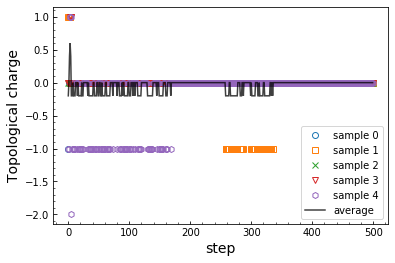

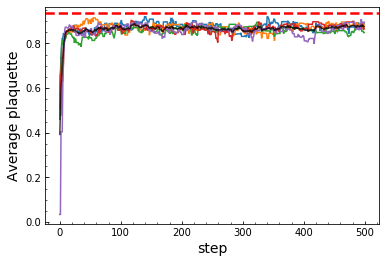

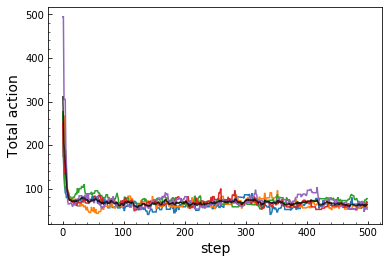

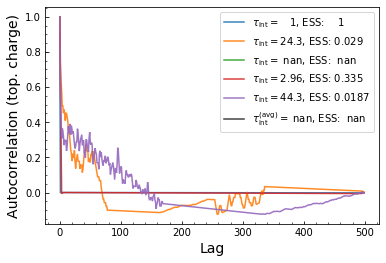

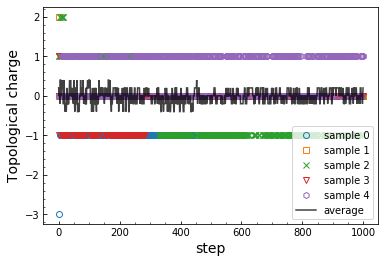

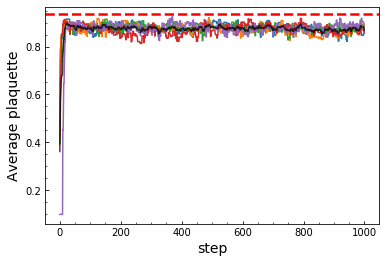

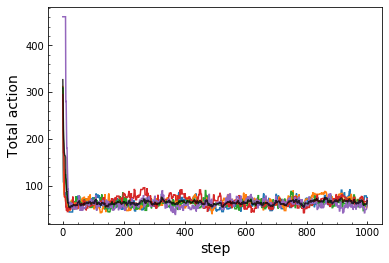

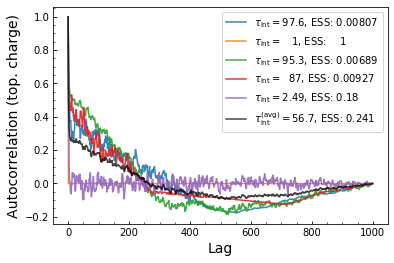

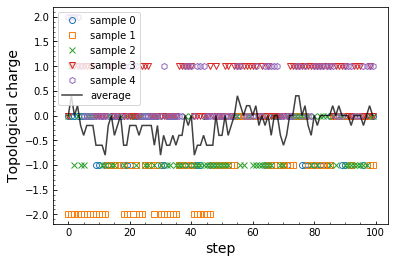

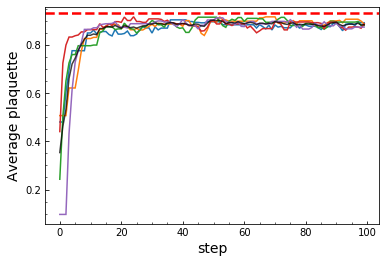

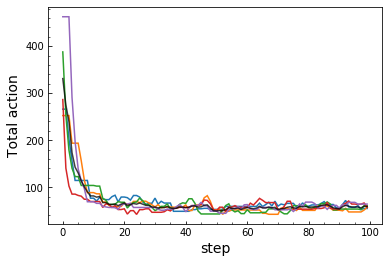

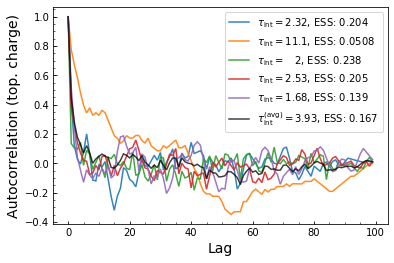

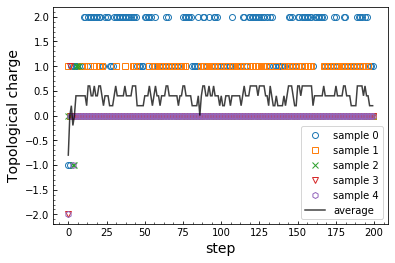

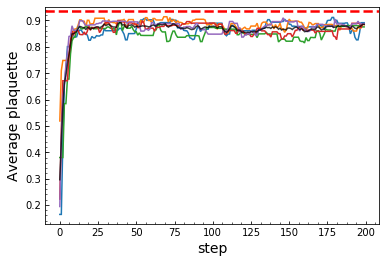

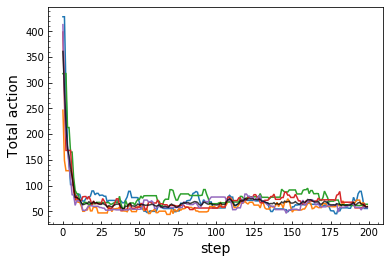

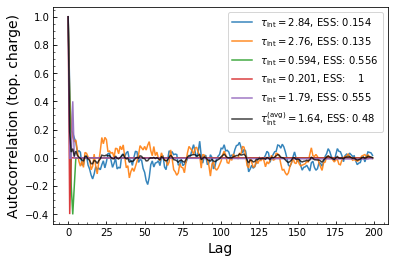

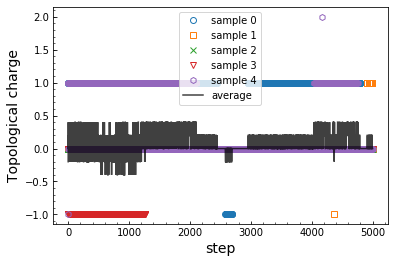

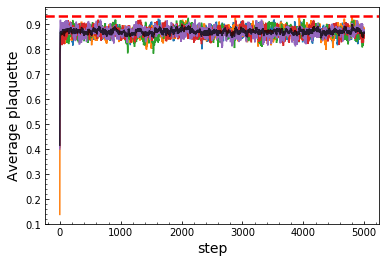

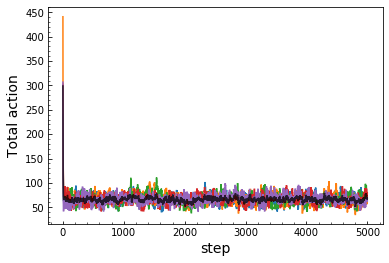

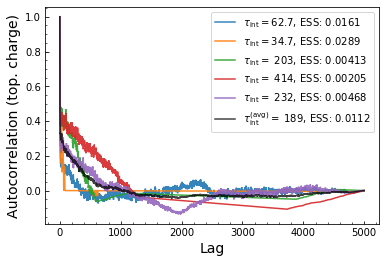

In [78]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'], 
        _observables,
        _figs_dir, 
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

#### Topological charge history

Making directory: ../../gauge_logs_graph/run_135/figures/figures_500/top_charges_figs


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_500/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_500/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_500/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_500/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_500/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_135/figures/figures_1000/top_charges_figs


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_1000/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_1000/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_1000/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_1000/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_1000/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_135/figures/figures_100/top_charges_figs


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_100/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_100/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_100/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_100/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_100/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_135/figures/figures_200/top_charges_figs


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_200/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_200/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_200/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_200/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_200/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_135/figures/figures_5000/top_charges_figs


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_5000/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_5000/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_5000/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_5000/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_135/figures/figures_5000/top_charges_figs/top_charge_history_sample_4.pdf.


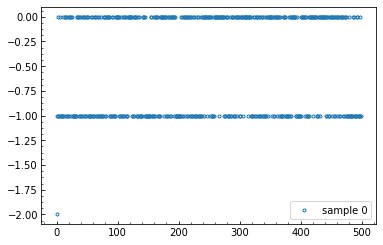

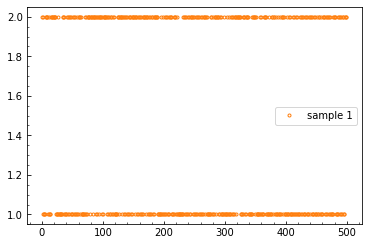

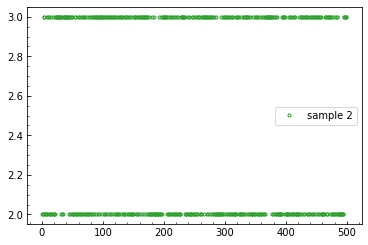

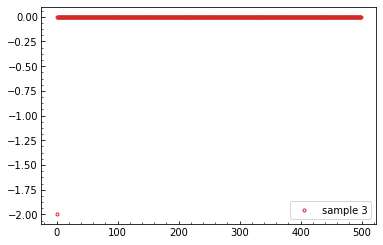

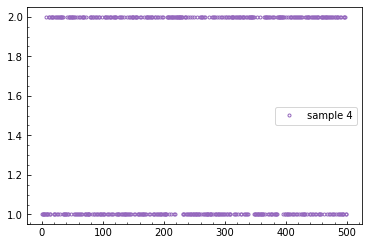

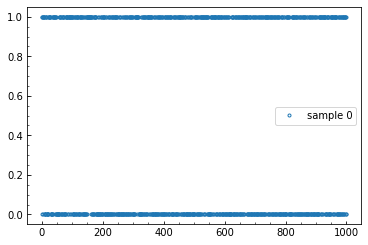

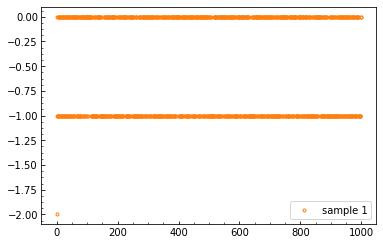

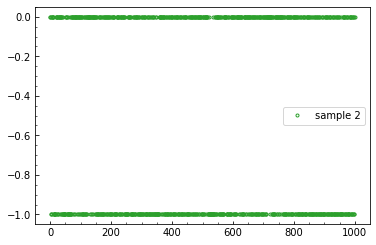

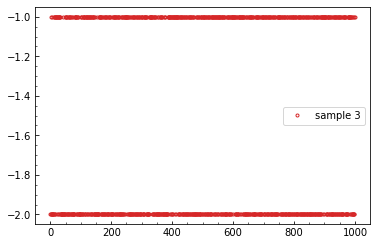

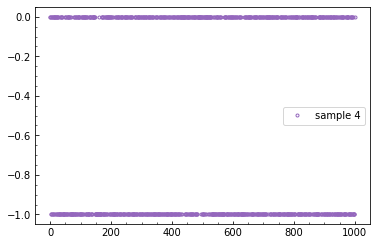

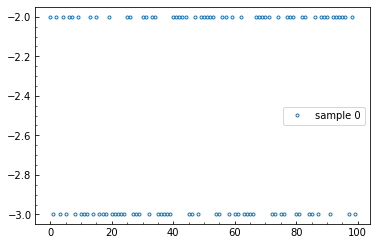

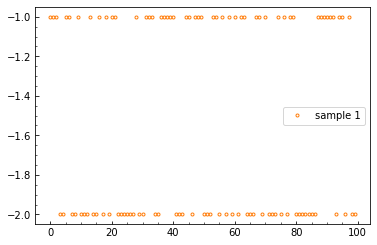

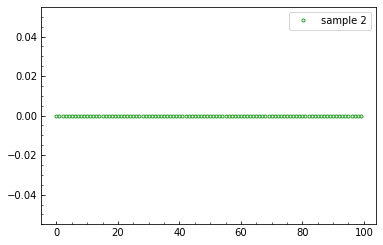

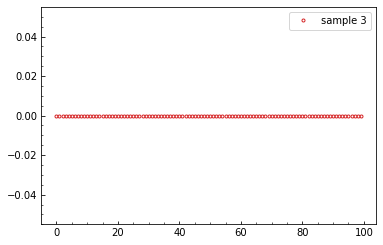

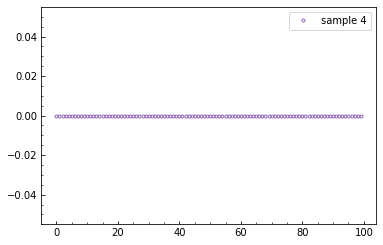

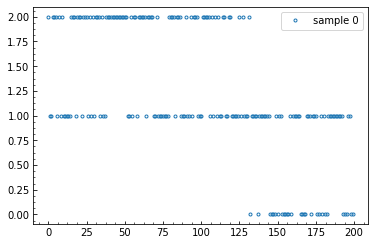

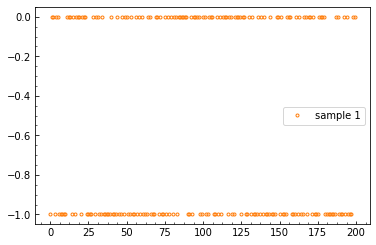

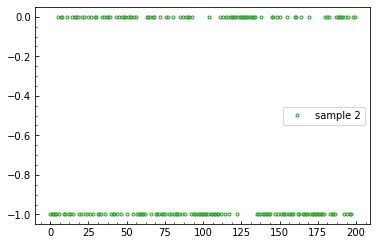

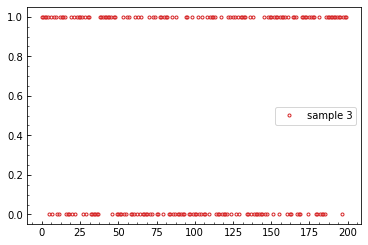

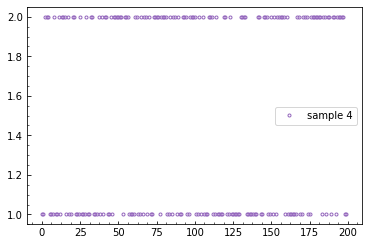

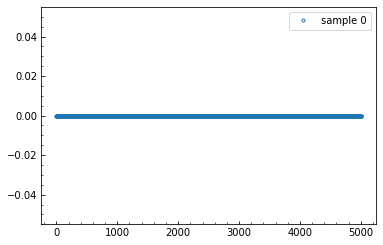

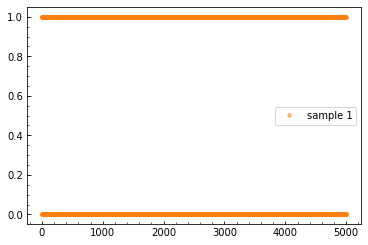

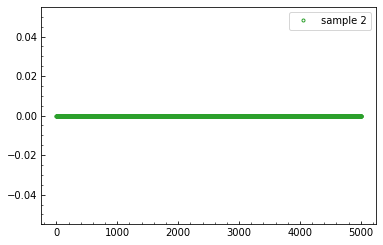

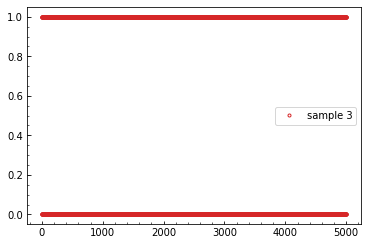

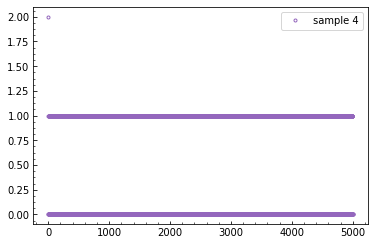

In [37]:
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_figs')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        plt.plot(val[:, idx], label=f'sample {idx}', 
                 color=COLORS[idx], marker='.', fillstyle='none', ls='')
        ax.legend(loc='best')
        out_file = os.path.join(fig_dir, 
                                f'top_charge_history_sample_{idx}.pdf')
        print(f'Saving figure to: {out_file}.')
        plt.savefig(out_file, dpi=400, bbox_inches='tight')

#### Histograms for topological charge

Making directory: ../../gauge_logs_graph/run_138/figures/figures_500/top_charges_histograms
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_500/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_500/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_500/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_500/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_500/top_charges_histograms/top_charge_history_sample_4_histogram.pdf
Making directory: ../../gauge_logs_graph/run_138/figures/figures_1000/top_charges_histograms
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_1000/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving fig

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_5000/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_5000/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_138/figures/figures_5000/top_charges_histograms/top_charge_history_sample_4_histogram.pdf


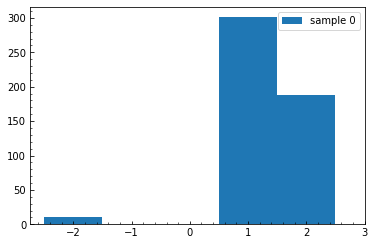

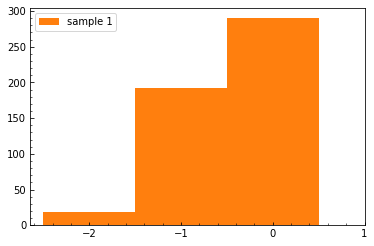

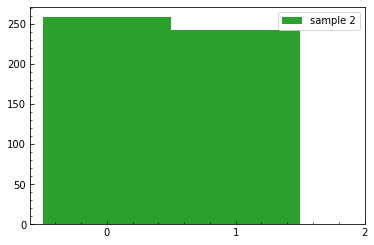

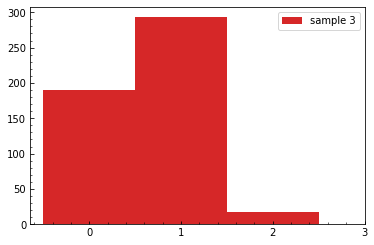

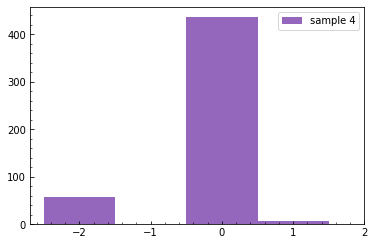

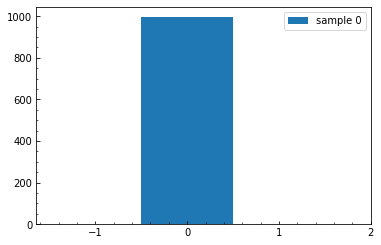

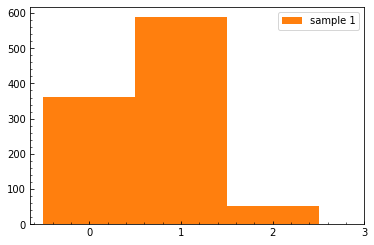

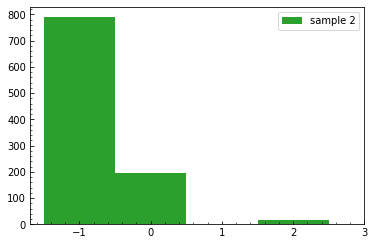

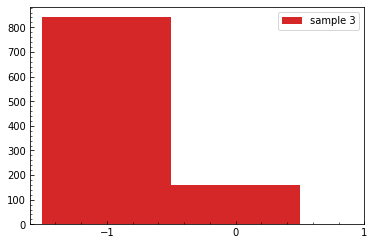

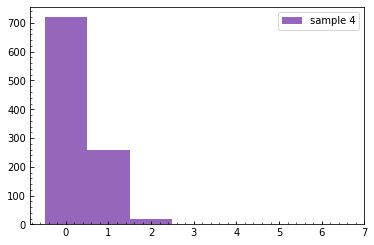

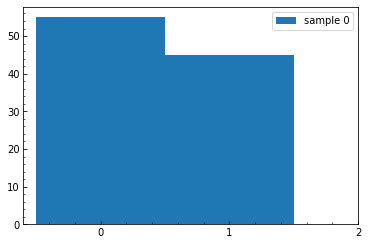

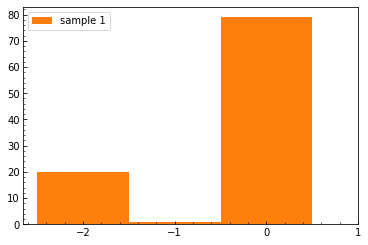

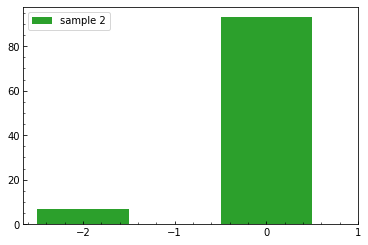

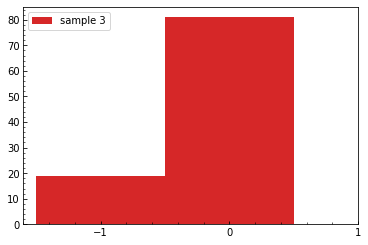

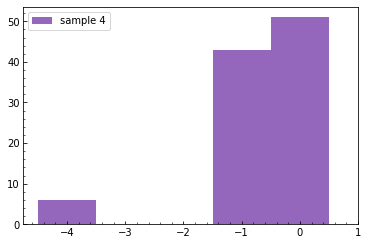

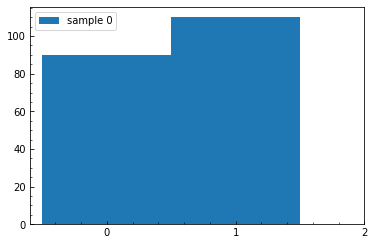

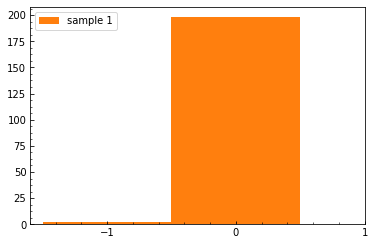

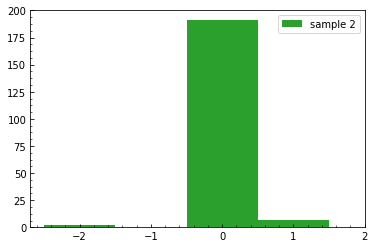

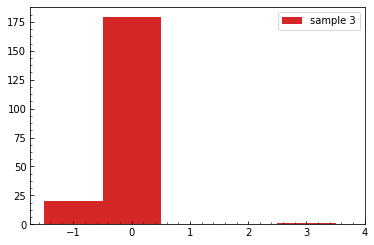

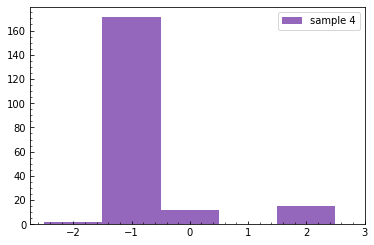

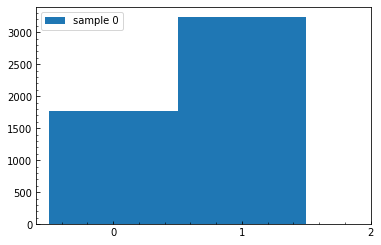

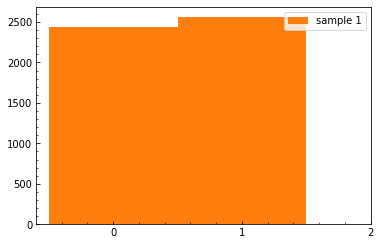

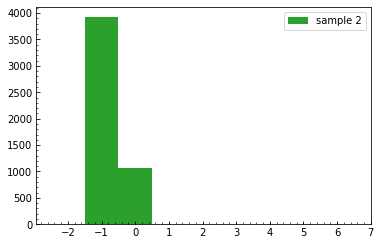

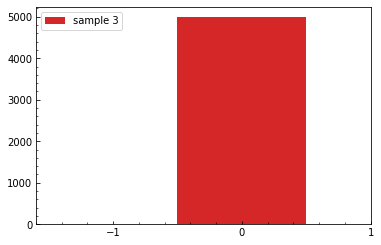

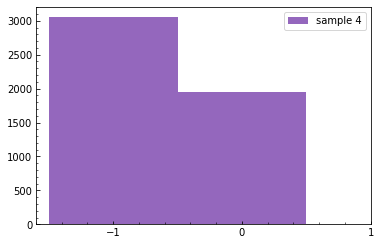

In [60]:
plt.close('all')
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_histograms')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        # the trick is to set up the bins centered on the integers, i.e.
        # -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. 
        # Then you substract -0.5 to # eliminate the extra bin at the end.
        bins = np.arange(val[:, idx].min(), val[:, idx].max() + 1.5) - 0.5
        _ = ax.hist(
            val[:, idx], 
            bins, 
            color=COLORS[idx], 
            label=f'sample {idx}'
        )
        _ = ax.set_xticks(bins + 0.5)
        #ax.hist(val[:, idx])
        _ = ax.legend(loc='best')
        out_file = os.path.join(
            fig_dir, 
            f'top_charge_history_sample_{idx}_histogram.pdf'
        )
        print(f'Saving figure to: {out_file}')
        plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Look at observables from samples generated during training 

In [70]:
from utils.gauge_observables import (
    _load_samples_from_file, _load_params, _calc_observables,
)

In [71]:
#log_dir = (
#    '../../gauge_logs_graph/run_96/'
#)
log_dir = '../../gauge_logs_graph/run_139/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')

params = _load_params(log_dir)

figs_dir = os.path.join(log_dir, 'figures')
samples_dict, actions_dict, plaqs_dict, charges_dict = {}, {}, {}, {}

In [66]:
train_samples_files = [train_samples_dir + i 
                       for i in os.listdir(train_samples_dir) 
                       if i.endswith('.pkl')]

In [67]:
train_samples_files

['../../gauge_logs_graph/run_139/samples_history/training/samples_history_1000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_5000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_2500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_4000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_3500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_3000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_4500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_2000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_139/samples_history/training/samples_history_1500_TRAIN_100.pkl']

In [68]:
step_keys = [int(i.split('/')[-1].split('_')[2]) for i in train_samples_files]
step_keys

[1000, 5000, 2500, 500, 4000, 3500, 3000, 4500, 2000, 1500]

In [ ]:
for key in charges_dict.keys():
    actions = actions_dict[key]
    plaqs = plaqs_dict[key]
    charges = charges_dict[key]
    observables = (actions, plaqs, charges)
    
        params['beta_final'], 
        _observables
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

In [69]:
for idx, sample_file in enumerate(train_samples_files):
    step = step_keys[idx]
    if step not in charges_dict.keys():
        print(f"Calculating observables for {step}...")
        with open(sample_file, 'rb') as f:
            samples = pickle.load(f)


        actions, plaqs, charges = _calc_observables(samples, params)

        actions_dict[step] = actions
        plaqs_dict[step] = plaqs
        charges_dict[step] = charges
    

Calculating observables for 5000...
step: 0 time/step: 0.07463 avg action: 371.5  avg plaquette: 0.2744 top charges: 


[0, 1, -1, 0, 0]


step: 1 time/step: 0.07655 avg action: 285.9  avg plaquette: 0.4416 top charges: 


[0, 0, 2, 0, 0]


step: 2 time/step: 0.07324 avg action: 221.1  avg plaquette: 0.5682 top charges: 


[3, 0, 2, 0, 1]


step: 3 time/step: 0.06501 avg action: 173.8  avg plaquette: 0.6606 top charges: 


[3, 0, -1, 0, 1]


step: 4 time/step: 0.06471 avg action: 128.4  avg plaquette: 0.7493 top charges: 


[1, 0, 0, 0, -1]


step: 5 time/step: 0.06301 avg action: 107.2  avg plaquette: 0.7907 top charges: 


[2, 1, 0, 0, -1]


step: 6 time/step: 0.07539 avg action: 95.04  avg plaquette: 0.8144 top charges: 


[1, 1, 0, 0, -1]


step: 7 time/step: 0.07652 avg action: 93.49  avg plaquette: 0.8174 top charges: 


[1, 1, 0, 0, 0]


step: 8 time/step: 0.06508 avg action: 93.49  avg plaquette: 0.8174 top charges: 


[1, 1, 0, 0, 0]


step: 9 time/step: 0.06642 avg action: 90

step: 82 time/step: 0.06544 avg action: 57.32  avg plaquette: 0.8881 top charges: 


[1, 0, 0, 0, 0]


step: 83 time/step: 0.06995 avg action: 60.01  avg plaquette: 0.8828 top charges: 


[1, 1, 0, 1, -1]


step: 84 time/step: 0.06862 avg action: 59.29  avg plaquette: 0.8842 top charges: 


[2, 0, 0, 1, -1]


step: 85 time/step: 0.06801 avg action: 60.51  avg plaquette: 0.8818 top charges: 


[1, 0, 0, 1, -1]


step: 86 time/step: 0.06884 avg action: 62.59  avg plaquette: 0.8778 top charges: 


[2, 1, 0, 1, -1]


step: 87 time/step: 0.06376 avg action: 60.19  avg plaquette: 0.8824 top charges: 


[2, 1, 0, 1, 0]


step: 88 time/step: 0.06832 avg action: 61.03  avg plaquette: 0.8808 top charges: 


[2, 0, 0, 1, 0]


step: 89 time/step: 0.0678 avg action: 64.26  avg plaquette: 0.8745 top charges: 


[2, 0, 0, 1, 0]


step: 90 time/step: 0.06388 avg action: 64.07  avg plaquette: 0.8749 top charges: 


[1, 0, 0, 1, -1]


step: 91 time/step: 0.06584 avg action: 63.83  avg plaquette: 0.8753 

step: 61 time/step: 0.07122 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 62 time/step: 0.06823 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 63 time/step: 0.07093 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 64 time/step: 0.06437 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 65 time/step: 0.06935 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 66 time/step: 0.0684 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 67 time/step: 0.06513 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 68 time/step: 0.07316 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 69 time/step: 0.07337 avg action: 469.6  avg plaquette: 0.08288 top charges: 


[1, 0, 6, 0, 0]


step: 70 time/step: 0.06876 avg action: 469.6  avg plaquette: 0.0

step: 41 time/step: 0.06742 avg action: 175.9  avg plaquette: 0.6564 top charges: 


[0, 2, 0, 0, 0]


step: 42 time/step: 0.07572 avg action: 176.7  avg plaquette: 0.655  top charges: 


[0, 2, 0, 0, 0]


step: 43 time/step: 0.06651 avg action: 176.7  avg plaquette: 0.655  top charges: 


[0, 2, 0, 0, 0]


step: 44 time/step: 0.06663 avg action: 176.7  avg plaquette: 0.655  top charges: 


[0, 2, 0, 0, 0]


step: 45 time/step: 0.06673 avg action: 176.7  avg plaquette: 0.655  top charges: 


[0, 2, 0, 0, 0]


step: 46 time/step: 0.06643 avg action: 137.2  avg plaquette: 0.7321 top charges: 


[0, -3, 0, 0, 0]


step: 47 time/step: 0.07127 avg action: 138.1  avg plaquette: 0.7303 top charges: 


[0, -3, 0, 0, 0]


step: 48 time/step: 0.06839 avg action: 119.6  avg plaquette: 0.7665 top charges: 


[0, 0, 0, 0, 0]


step: 49 time/step: 0.06659 avg action: 102.7  avg plaquette: 0.7993 top charges: 


[0, 1, 0, 0, 0]


step: 50 time/step: 0.06645 avg action: 103.1  avg plaquette: 0.7987 to

step: 21 time/step: 0.06666 avg action: 262.1  avg plaquette: 0.4882 top charges: 


[2, 0, 3, -2, 0]


step: 22 time/step: 0.07064 avg action: 262.3  avg plaquette: 0.4877 top charges: 


[2, 0, 3, -1, 0]


step: 23 time/step: 0.06947 avg action: 262.3  avg plaquette: 0.4877 top charges: 


[2, 0, 3, -1, 0]


step: 24 time/step: 0.072  avg action: 250.6  avg plaquette: 0.5106 top charges: 


[2, 0, 1, -1, 0]


step: 25 time/step: 0.0692 avg action: 250.6  avg plaquette: 0.5106 top charges: 


[2, 0, 1, -1, 0]


step: 26 time/step: 0.06931 avg action: 242.9  avg plaquette: 0.5257 top charges: 


[2, 0, 1, -1, 0]


step: 27 time/step: 0.09599 avg action: 242.9  avg plaquette: 0.5257 top charges: 


[2, 0, 1, -1, 0]


step: 28 time/step: 0.06786 avg action: 242.9  avg plaquette: 0.5257 top charges: 


[2, 0, 1, -1, 0]


step: 29 time/step: 0.06497 avg action: 242.9  avg plaquette: 0.5257 top charges: 


[2, 0, 1, -1, 0]


step: 30 time/step: 0.06714 avg action: 229.5  avg plaquette: 0.55

step: 0 time/step: 0.118  avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 1 time/step: 0.1121 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 2 time/step: 0.1053 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 3 time/step: 0.1393 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 4 time/step: 0.1081 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 5 time/step: 0.06955 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 6 time/step: 0.07021 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 7 time/step: 0.08179 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 8 time/step: 0.0795 avg action: 399.4  avg plaquette: 0.2199 top charges: 


[2, -1, 0, 0, 0]


step: 9 time/step: 0.09323 avg action: 367.7  avg plaquette: 0.2819 top charges

step: 79 time/step: 0.0698 avg action: 322.9  avg plaquette: 0.3693 top charges: 


[-1, -1, 0, 0, -1]


step: 80 time/step: 0.06653 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 81 time/step: 0.06807 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 82 time/step: 0.07079 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 83 time/step: 0.06804 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 84 time/step: 0.0681 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 85 time/step: 0.06804 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 86 time/step: 0.07731 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 87 time/step: 0.07233 avg action: 318.7  avg plaquette: 0.3776 top charges: 


[-2, -1, 0, 0, -1]


step: 88 time/step: 0.07117 avg action: 318.7  a

step: 59 time/step: 0.06682 avg action: 69.53  avg plaquette: 0.8642 top charges: 


[0, -1, 0, 0, -1]


step: 60 time/step: 0.07053 avg action: 67.83  avg plaquette: 0.8675 top charges: 


[0, -1, 0, 0, -1]


step: 61 time/step: 0.0715 avg action:  70.2  avg plaquette: 0.8629 top charges: 


[0, -1, 0, 0, 0]


step: 62 time/step: 0.06124 avg action:  70.2  avg plaquette: 0.8629 top charges: 


[0, -1, 0, 0, 0]


step: 63 time/step: 0.06985 avg action:  70.2  avg plaquette: 0.8629 top charges: 


[0, -1, 0, 0, 0]


step: 64 time/step: 0.06648 avg action:  71.7  avg plaquette:  0.86  top charges: 


[0, -1, 0, 0, 0]


step: 65 time/step: 0.06637 avg action:  71.7  avg plaquette:  0.86  top charges: 


[0, -1, 0, 0, 0]


step: 66 time/step: 0.07074 avg action: 69.62  avg plaquette: 0.864  top charges: 


[0, -1, 0, 0, 0]


step: 67 time/step: 0.06739 avg action: 69.37  avg plaquette: 0.8645 top charges: 


[-1, -1, 0, 0, 0]


step: 68 time/step: 0.06711 avg action: 69.37  avg plaquette: 

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

## OLD PLOTS

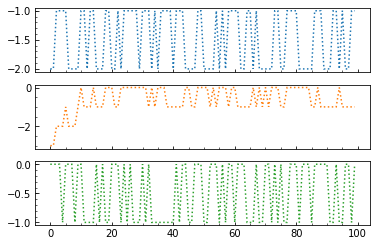

In [28]:
ax1 = plt.subplot(311)
_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(312, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(313, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
#_ = plt.setp(ax3.get_xticklabels(), visible=False)

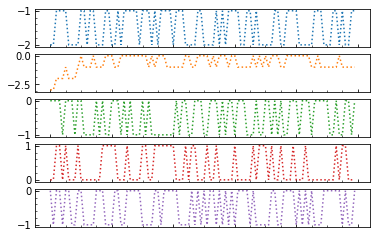

In [27]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [116]:
plt.close('all')

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/autocorrelation_plots/pandas_autocorrel

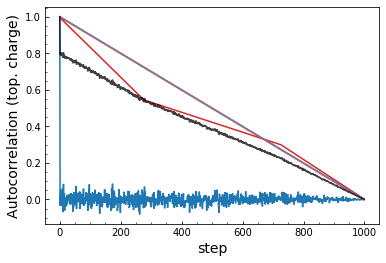

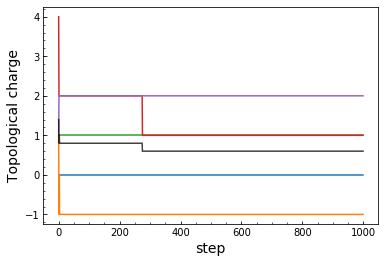

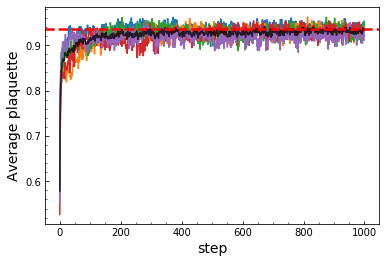

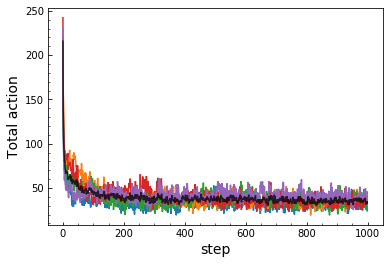

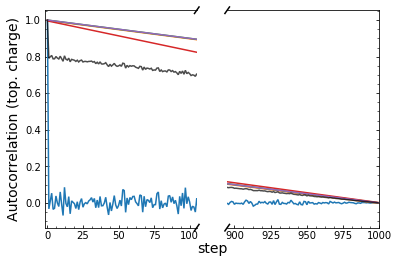

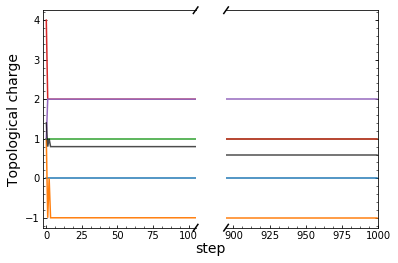

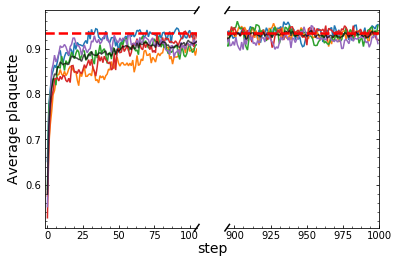

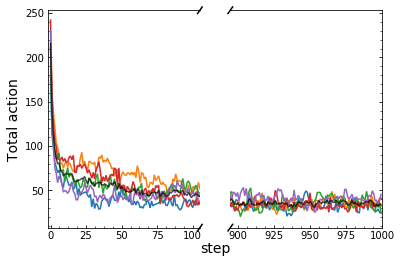

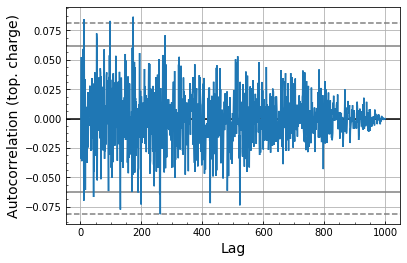

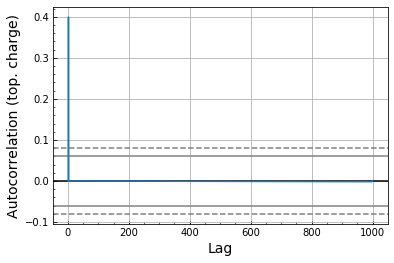

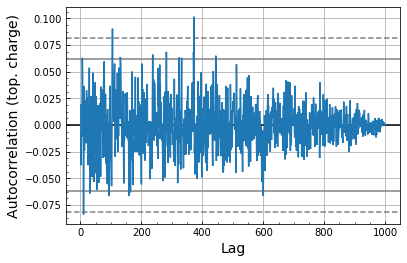

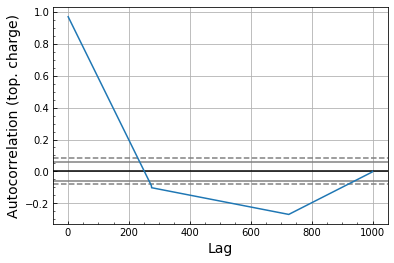

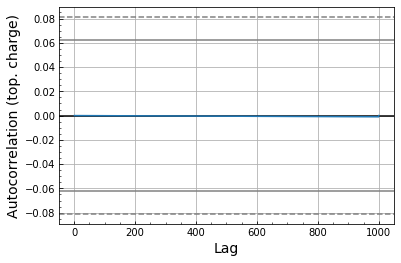

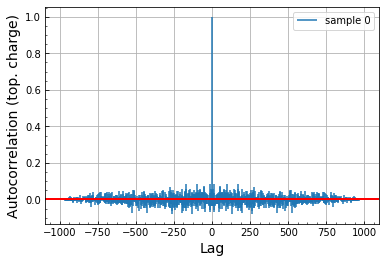

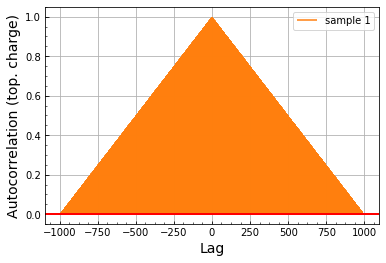

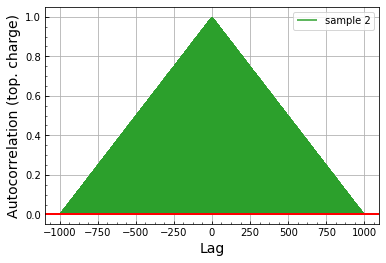

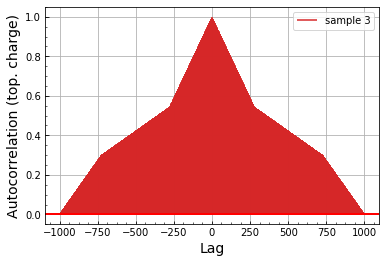

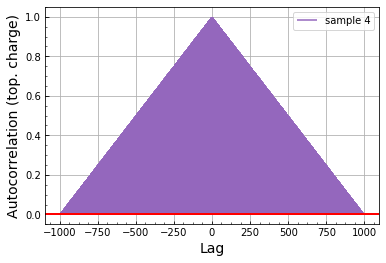

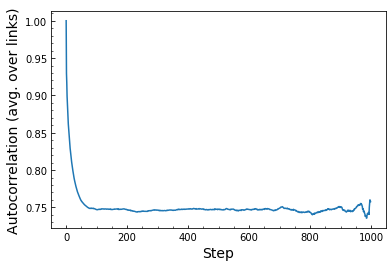

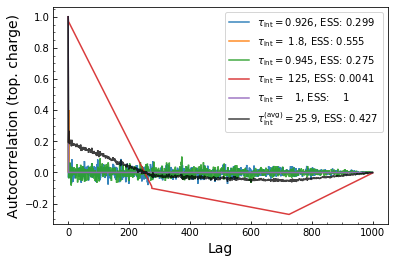

In [8]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [81]:
plt.close('all')

Saving figure to: ../../gauge_logs_graph/run_19/figures/integrated_autocorrelation_time_plot.pdf.


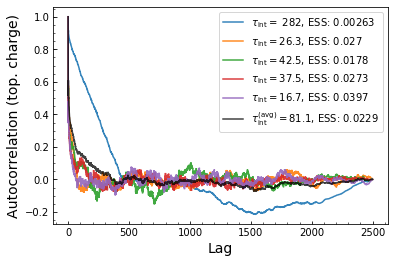

In [24]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

# OLD

In [ ]:
np.mean(ESS_arr)

Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/matplotlib_autocorrelation_plots/top_charges_autocorr_matplotlib.pdf.


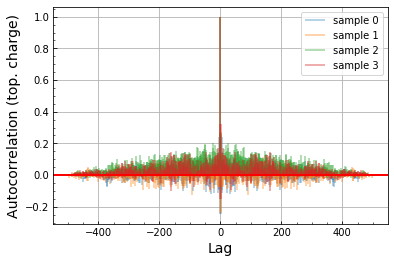

In [224]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [300]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [301]:
lattice.num_links

128

##### Old approach (unsure of validity)

In [25]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [26]:
iac2, iac4, iac10

(2.1520862694468614, 1.5014179402207577, 1.9374474465140532)

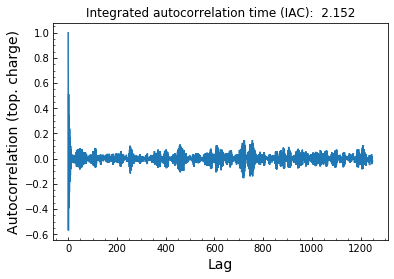

In [27]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

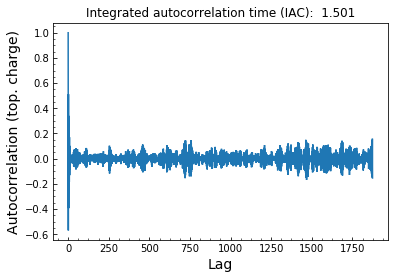

In [28]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

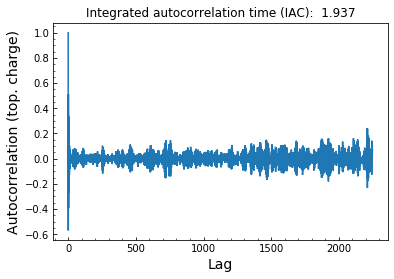

In [29]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})